# First import the necessary library

In [1]:
import pytplot 
from pytplot import *
from pytplot import tplot
from pytplot import store_data, get_data
from pytplot import options, annotate,tplot_options
from pytplot import tlimit,highlight,timebar,time_double,time_string,time_datetime

from datetime import datetime
import numpy as np

import pandas as pd
import xarray as xr

import cdflib
import datetime,glob,os,re
from matplotlib import style,ticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

In [2]:
taistarttime = '20151016105454'

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set up the font properties
rcParams['font.family'] = 'Times New Roman'  # Default font for numbers
rcParams['font.size'] = 10.5  # Font size for numbers



In [4]:
def create_directories_if_not_exist(*paths):
    for path in paths:
        if not os.path.exists(path):
            os.makedirs(path)
# Define the file paths
file_path = os.path.join(os.getcwd(), 'Phase1b')
output_folder = os.path.join(os.getcwd(),'Plots',f"{taistarttime}")

# Call the function to create directories
create_directories_if_not_exist(file_path, output_folder)

# FPI PyTplot

In [5]:
def search(date):
    directory = os.path.join(os.getcwd(), 'Phase1a')
    # Define the pattern to match the file names
    pattern = re.compile(rf'mms([1-4])_(mec|fpi|fgm|edp)_brst_l2(?:_(des-moms|dis-moms|epht89d|dce))?_{date}_v\d+\.\d+\.\d+')

    # Initialize dictionary to store file paths
    file_paths = {'fgm': [], 'fpi': [], 'edp': []}

    # Iterate over files in the directory
    for filename in os.listdir(directory):
        # Match the filename with the pattern
        match = pattern.match(filename)
        if match:
            datatype = match.group(3) if match.group(3) else ''  # Extracting datatype, if available
             
            # Construct the full file path
            filepath = os.path.join(directory, filename)
                        
            if datatype in ['des-moms', 'dis-moms']:
                file_paths['fpi'].append(filepath)
            elif match.group(2) == 'fgm' and (datatype in ['', 'epht89d']):
                file_paths['fgm'].append(filepath)
            elif datatype == 'dce':
                file_paths['edp'].append(filepath)

    return file_paths
    
def convolve(data,window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

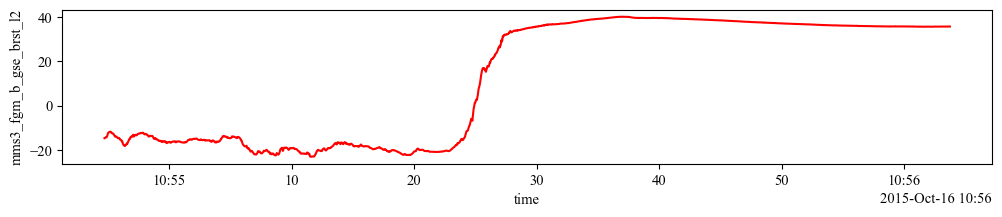

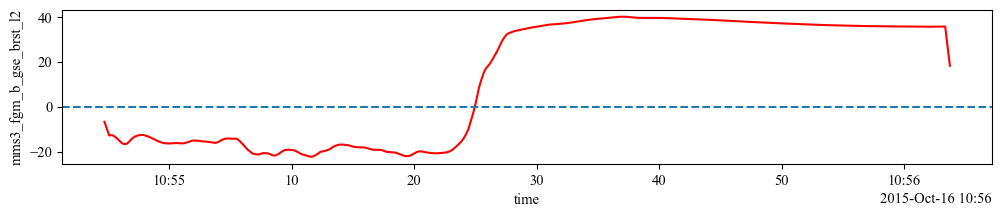

In [6]:
fgm_paths = search(f"{taistarttime}")['fgm']

b_fgm_paths =  [path for path in fgm_paths if 'fgm' in path]
num_paths_b = len(fgm_paths) # Number of elements in dis_moms_paths
paths_per_b = 4 # Number of paths to process in each iteration

# Loop through des_moms_paths and create pytplot objects
for i in range(0, num_paths_b, paths_per_b):
    paths_slice = b_fgm_paths[i:i+paths_per_b]
    bfield = pytplot.cdf_to_tplot(paths_slice)

b1 = pytplot.get_data('mms1_fgm_b_gse_brst_l2',xarray=True,dt=True)
r1 = pytplot.get_data('mms1_fgm_r_gse_brst_l2',xarray=True,dt=True).rename({'time': 'epoch'})
b2 = pytplot.get_data('mms2_fgm_b_gse_brst_l2',xarray=True,dt=True)
r2 = pytplot.get_data('mms2_fgm_r_gse_brst_l2',xarray=True,dt=True).rename({'time': 'epoch'})
b3 = pytplot.get_data('mms3_fgm_b_gse_brst_l2',xarray=True,dt=True)
r3 = pytplot.get_data('mms3_fgm_r_gse_brst_l2',xarray=True,dt=True).rename({'time': 'epoch'})
b4 = pytplot.get_data('mms4_fgm_b_gse_brst_l2',xarray=True,dt=True)
r4 = pytplot.get_data('mms4_fgm_r_gse_brst_l2',xarray=True,dt=True).rename({'time': 'epoch'})

mms1_bdataset = xr.merge([b1,r1]).sel(epoch=~xr.merge([b1,r1]).indexes['epoch'].duplicated())
mms2_bdataset = xr.merge([b2,r2]).sel(epoch=~xr.merge([b2,r2]).indexes['epoch'].duplicated())
mms3_bdataset = xr.merge([b3,r3]).sel(epoch=~xr.merge([b3,r3]).indexes['epoch'].duplicated())
mms4_bdataset = xr.merge([b4,r4]).sel(epoch=~xr.merge([b4,r4]).indexes['epoch'].duplicated())
 
mms3_bdataset.mms3_fgm_b_gse_brst_l2.isel(v_dim=2).plot(figsize=(12,2),c='r')
xr.apply_ufunc(convolve,mms3_bdataset.mms3_fgm_b_gse_brst_l2.isel(v_dim=2),kwargs={'window_size': 100}).plot(figsize=(12,2),c='r')
plt.axhline(y=0,ls='--')
plt.show()

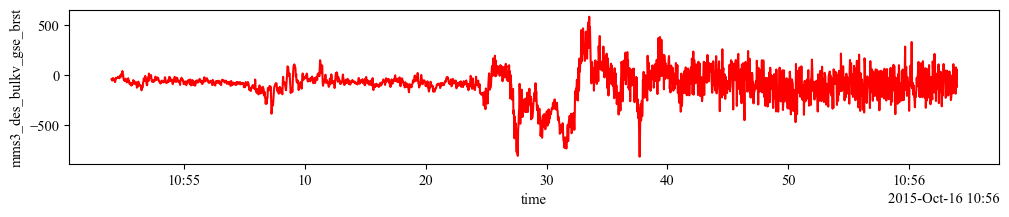

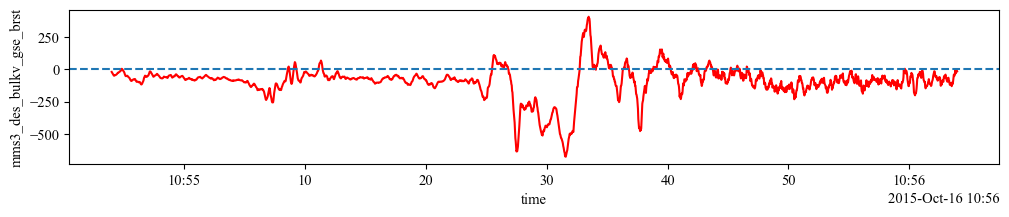

In [7]:
des_fpi_paths = search(f"{taistarttime}")['fpi']
des_moms_paths =  [path for path in des_fpi_paths if 'des-moms' in path]
num_paths_e = len(des_moms_paths) # Number of elements in dis_moms_paths
paths_per_e = 4 # Number of paths to process in each iteration

# Loop through des_moms_paths and create pytplot objects
for i in range(0, num_paths_e, paths_per_e):
    paths_slice = des_moms_paths[i:i+paths_per_e]
    efield = pytplot.cdf_to_tplot(paths_slice)

EE1 = pytplot.get_data('mms3_des_energyspectr_omni_brst',xarray=True,metadata=False,dt=True,units=True).rename({'v_dim': 'e_dim'}) 
EN1 = pytplot.get_data('mms3_des_numberdensity_brst',xarray=True,dt=True)
EV1 = pytplot.get_data('mms3_des_bulkv_gse_brst',xarray=True,dt=True)
ET1 = pytplot.get_data('mms3_des_temppara_brst',xarray=True,dt=True)
ETP1 = pytplot.get_data('mms3_des_tempperp_brst',xarray=True,dt=True)
mms3_edataset = xr.merge([EE1,EN1,EV1,ET1,ETP1])

uniform_time_series = pd.date_range(start= mms3_edataset.time.values.min(), 
                                    end= mms3_edataset.time.values.max(), 
                                    freq='30ms').tz_localize('UTC').values
mms3i_edataset = mms3_edataset.interp(time=uniform_time_series,method="linear",kwargs={"fill_value": "extrapolate"}) 

mms1i_bdataset = mms1_bdataset.interp_like(mms3i_edataset,method='linear',kwargs={"fill_value": "extrapolate"})
mms2i_bdataset = mms2_bdataset.interp_like(mms3i_edataset,method='linear',kwargs={"fill_value": "extrapolate"})
mms3i_bdataset = mms3_bdataset.interp_like(mms3i_edataset,method='linear',kwargs={"fill_value": "extrapolate"})
mms4i_bdataset = mms4_bdataset.interp_like(mms3i_edataset,method='linear',kwargs={"fill_value": "extrapolate"})

mms1i_brdataset = mms1i_bdataset.interp(epoch=mms3i_edataset.time,method="linear",kwargs={"fill_value": "extrapolate"}) 
mms2i_brdataset = mms2i_bdataset.interp(epoch=mms3i_edataset.time,method="linear",kwargs={"fill_value": "extrapolate"}) 
mms3i_brdataset = mms3i_bdataset.interp(epoch=mms3i_edataset.time,method="linear",kwargs={"fill_value": "extrapolate"}) 
mms4i_brdataset = mms4i_bdataset.interp(epoch=mms3i_edataset.time,method="linear",kwargs={"fill_value": "extrapolate"}) 

mms3i_edataset.mms3_des_bulkv_gse_brst.isel(v_dim=2).plot(figsize=(12, 2), color='r')

# Apply the convolve function with a specific window size (e.g., 100)
xr.apply_ufunc(convolve, mms3i_edataset.mms3_des_bulkv_gse_brst.isel(v_dim=2), kwargs={'window_size': 10}).plot(figsize=(12, 2), color='r')

# Add a horizontal line at y=0
plt.axhline(y=0, linestyle='--')
plt.show()                            

In [8]:
des_fpi_paths

['D:\\hallsim\\mms\\pydata\\trial\\Phase1a\\mms1_fpi_brst_l2_des-moms_20151016105454_v3.3.0.cdf',
 'D:\\hallsim\\mms\\pydata\\trial\\Phase1a\\mms1_fpi_brst_l2_dis-moms_20151016105454_v3.3.0.cdf',
 'D:\\hallsim\\mms\\pydata\\trial\\Phase1a\\mms2_fpi_brst_l2_des-moms_20151016105454_v3.3.0.cdf',
 'D:\\hallsim\\mms\\pydata\\trial\\Phase1a\\mms2_fpi_brst_l2_dis-moms_20151016105454_v3.3.0.cdf',
 'D:\\hallsim\\mms\\pydata\\trial\\Phase1a\\mms3_fpi_brst_l2_des-moms_20151016105454_v3.3.0.cdf',
 'D:\\hallsim\\mms\\pydata\\trial\\Phase1a\\mms3_fpi_brst_l2_dis-moms_20151016105454_v3.3.0.cdf',
 'D:\\hallsim\\mms\\pydata\\trial\\Phase1a\\mms4_fpi_brst_l2_des-moms_20151016105454_v3.3.0.cdf',
 'D:\\hallsim\\mms\\pydata\\trial\\Phase1a\\mms4_fpi_brst_l2_dis-moms_20151016105454_v3.3.0.cdf']

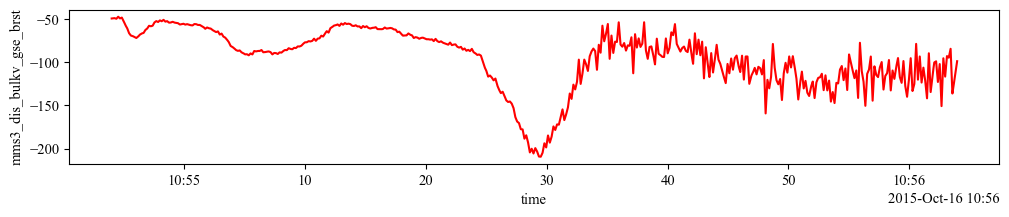

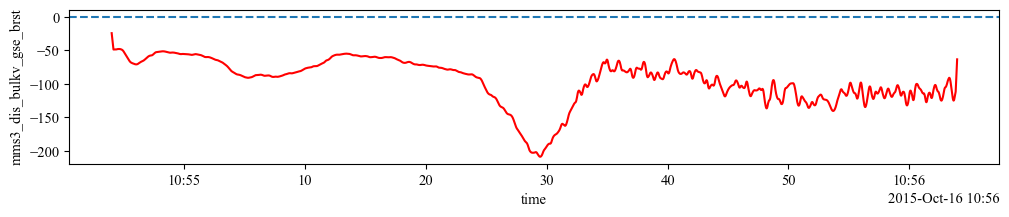

In [11]:
dis_fpi_paths = search(f"{taistarttime}")['fpi']
dis_moms_paths =  [path for path in dis_fpi_paths if 'dis-moms' in path]
num_paths_i = len(dis_moms_paths) # Number of elements in dis_moms_paths
paths_per_i = 4 # Number of paths to process in each iteration

# Loop through dis_moms_paths and create pytplot objects
for i in range(0, num_paths_i, paths_per_i):
    paths_slice = dis_moms_paths[i:i+paths_per_i]
    ion = pytplot.cdf_to_tplot(paths_slice)
    
IE1 = pytplot.get_data('mms3_dis_energyspectr_omni_brst',xarray=True,metadata=False,dt=True,units=True).rename({'v_dim': 'e_dim'})
IN1 = pytplot.get_data('mms3_dis_numberdensity_brst',xarray=True,metadata=False,dt=True,units=True)
IV1 = pytplot.get_data('mms3_dis_bulkv_gse_brst',xarray=True,metadata=False,dt=True,units=True)
IT1 = pytplot.get_data('mms3_dis_temppara_brst',xarray=True,metadata=False,dt=True,units=True)
ITP1 = pytplot.get_data('mms3_dis_tempperp_brst',xarray=True,metadata=False,dt=True,units=True)
mms3_idataset = xr.merge([IE1,IN1,IV1,IT1,ITP1])
mms3i_idataset = mms3_idataset.interp_like(mms3i_edataset.time,method='linear', kwargs={"fill_value": "extrapolate"}) 
                                                    
mms3i_idataset.mms3_dis_bulkv_gse_brst.isel(v_dim=2).plot(figsize=(12, 2), color='r')

# Apply the convolve function with a specific window size (e.g., 100)
xr.apply_ufunc(convolve, mms3i_idataset.mms3_dis_bulkv_gse_brst.isel(v_dim=2), kwargs={'window_size': 10}).plot(figsize=(12, 2), color='r')

# Add a horizontal line at y=0
plt.axhline(y=0, linestyle='--')
plt.show()                                                    

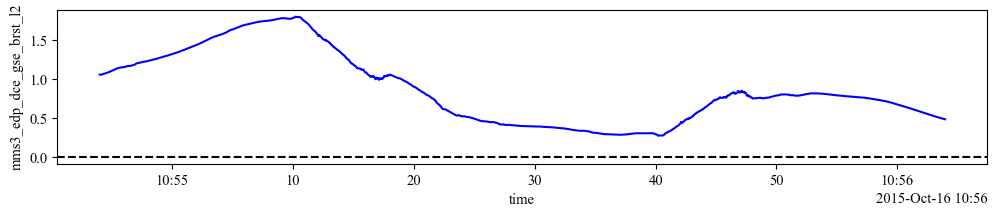

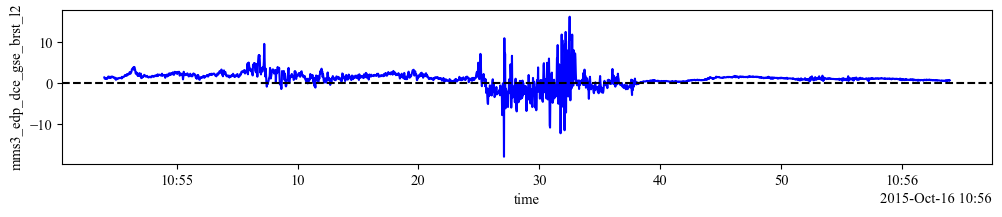

In [12]:
edp_paths = search(f"{taistarttime}")['edp']
E_edp_paths =  [path for path in edp_paths if 'edp' in path]
num_paths_E = len(edp_paths) # Number of elements in dis_moms_paths
paths_per_E = 4 # Number of paths to process in each iteration

# Loop through des_moms_paths and create pytplot objects
for i in range(0, num_paths_E, paths_per_E):
    paths_slice = E_edp_paths[i:i+paths_per_E]
    efield = pytplot.cdf_to_tplot(paths_slice)

mms3_Edataset = pytplot.get_data('mms3_edp_dce_gse_brst_l2',xarray=True,dt=True)
mms3i_Edataset = mms3_Edataset.interp_like(mms3i_edataset,method='linear', kwargs={"fill_value": "extrapolate"}) 

xr.apply_ufunc(convolve, mms3i_Edataset.isel(v_dim=0), kwargs={'window_size': 1000}).plot(figsize=(12, 2), color='b')
plt.axhline(y=0, ls='--',c='k')
mms3i_Edataset.isel(v_dim=0).plot(figsize=(12,2),c='b')
# Add a horizontal line at y=0
plt.axhline(y=0, ls='--',c='k')
plt.show()

In [13]:
def find(dataset,v_dim=None,LMN=None,d1=None, d2=None):
    # If d1 and d2 are not provided, use the dataset's time range
    if d1 is None:
        d1 = dataset.time.min().values  # Start from the first time entry
    if d2 is None:
        d2 = dataset.time.max().values  # End at the last time entry

    # If v_dim is provided, select based on v_dim
    if v_dim is not None:
        variable = dataset.sel(v_dim=v_dim, time=slice(d1, d2))
    # If LMN is provided, select based on LMN (assuming it's a predefined dimension in your dataset)
    elif LMN is not None:
        variable = dataset.sel(LMN=LMN, time=slice(d1, d2))
    else:
        raise ValueError("Either v_dim or LMN must be provided.")

    # Find where the variable crosses zero
    zero_crossing = np.where(np.diff(np.sign(variable)))[0]
    crossing_index = zero_crossing[0]  # Select the reversal time here
    time_before = variable.time.isel(time=crossing_index)
    time_after = variable.time.isel(time=crossing_index + 1)
    value_before = variable.isel(time=crossing_index)
    value_after = variable.isel(time=crossing_index + 1)

    # Choose the reversal time based on the absolute value comparison
    if np.abs(value_before) < np.abs(value_after):
        reversal_time = time_before
    else:
        reversal_time = time_after

    return reversal_time, crossing_index
Bz = find(mms1i_bdataset.mms1_fgm_b_gse_brst_l2,v_dim=2)
Bz[0].values,Bz[1]

(np.datetime64('2015-10-16T10:55:24.739474000'), np.int64(1024))

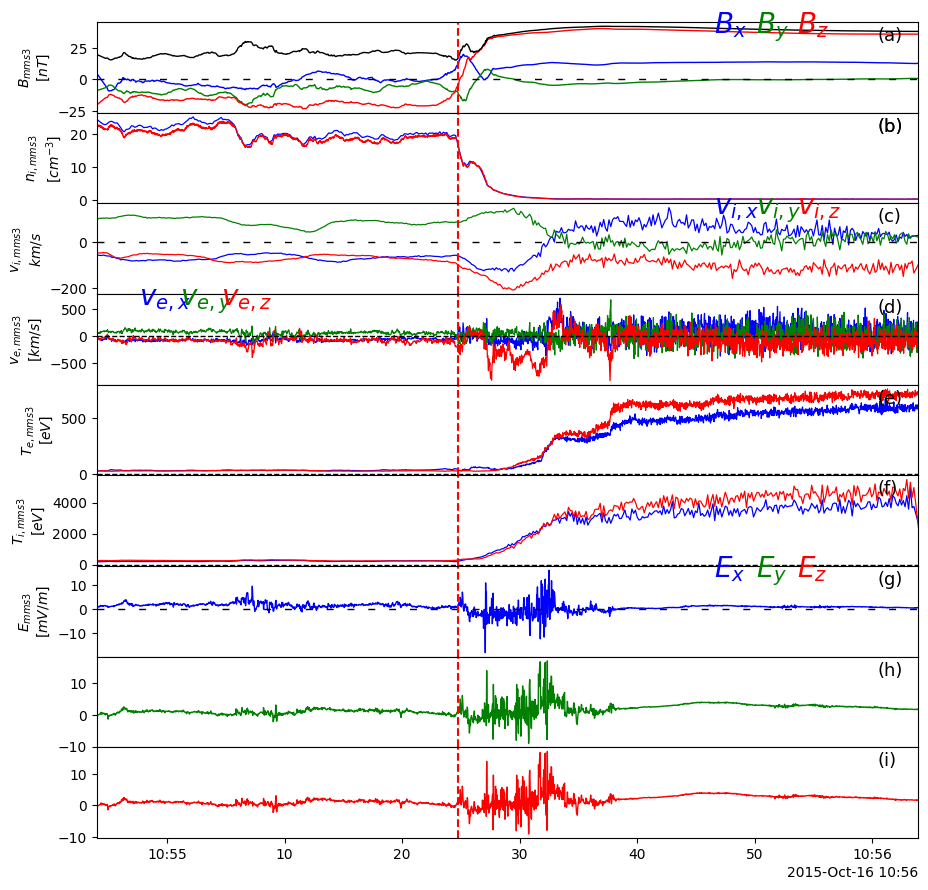

In [24]:
plt.style.use('default')

fig, axs = plt.subplots(9, 1, figsize=[10.4, 8.5], sharex=True, gridspec_kw={'hspace': 0})

# Plot data on the subplots
axs[0].text(0.95,0.95, '(a)', transform=axs[0].transAxes, fontsize=13, va='top') 
axs[1].text(0.95,0.95, '(b)', transform=axs[1].transAxes, fontsize=13, va='top') 
axs[2].text(0.95,0.95, '(c)', transform=axs[2].transAxes, fontsize=13, va='top') 
axs[3].text(0.95,0.95, '(d)', transform=axs[3].transAxes, fontsize=13, va='top') 
axs[4].text(0.95,0.95, '(e)', transform=axs[4].transAxes, fontsize=13, va='top') 
axs[5].text(0.95,0.95, '(f)', transform=axs[5].transAxes, fontsize=13, va='top') 
axs[6].text(0.95,0.95, '(g)', transform=axs[6].transAxes, fontsize=13, va='top') 
axs[7].text(0.95,0.95, '(h)', transform=axs[7].transAxes, fontsize=13, va='top')
axs[8].text(0.95,0.95, '(i)', transform=axs[8].transAxes, fontsize=13, va='top')

axs[0].plot(mms3i_bdataset.time.sel(time=slice(None)), mms3i_bdataset.mms3_fgm_b_gse_brst_l2.sel(v_dim=0), c='b', lw=1,label='Bx')
axs[0].plot(mms3i_bdataset.time.sel(time=slice(None)), mms3i_bdataset.mms3_fgm_b_gse_brst_l2.sel(v_dim=1), c='g', lw=1,label='By')
axs[0].plot(mms3i_bdataset.time.sel(time=slice(None)), mms3i_bdataset.mms3_fgm_b_gse_brst_l2.sel(v_dim=2), c='r', lw=1,label='Bz')
axs[0].plot(mms3i_bdataset.time.sel(time=slice(None)), mms3i_bdataset.mms3_fgm_b_gse_brst_l2.sel(v_dim=3), c='k', lw=1,label='Bz')
axs[0].axhline(y=0, c='k', ls=(0, (5, 10)), lw=1)
axs[0].annotate(r'$\mathit{B_x}$', xy=(0.75, 0.9), xycoords='axes fraction', style='italic',
                fontsize=20, color='b', xytext=(1, -1), textcoords='offset points')  # Annotation for Bx in blue
axs[0].annotate(r'$\mathit{B_y}$', xy=(0.80, 0.9), xycoords='axes fraction', style='italic',
                fontsize=20, color='g', xytext=(1, -1), textcoords='offset points')  # Annotation for By in green
axs[0].annotate(r'$\mathit{B_z}$', xy=(0.85, 0.9), xycoords='axes fraction', style='italic',
                fontsize=20, color='r', xytext=(1, -1), textcoords='offset points')  # Annotation for Bz in red
axs[0].set_xlim(mms3i_bdataset.time[0],mms3i_bdataset.time[-1])
#axs[0].axvspan(timestamps_of_sign_changes.time[0].values,timestamps_of_sign_changes.time[1].values, color='yellow', alpha=0.5)  # highlight the region 
axs[0].set_ylabel(r'$\mathbf{\mathit{B_{mms3}}}$' + '\n' + r'$\mathit{[nT]}$', fontsize=10)
axs[0].yaxis.label.set_size(10)


axs[1].plot(mms3i_idataset.time, mms3i_idataset.mms3_dis_numberdensity_brst, c='b', lw=0.9)
axs[1].plot(mms3i_edataset.time, mms3i_edataset.mms3_des_numberdensity_brst, c='r', lw=0.9)
axs[1].text(0.95,0.95, '(b)', transform=axs[1].transAxes, fontsize=13, va='top')
axs[1].set_ylabel(r'$\mathbf{\mathit{n_{i,mms3}}}$' + '\n' + r'$\mathit{[cm^{-3}]}$', fontsize=10)
axs[1].yaxis.label.set_size(10)
axs[1].set_xlim(mms3i_idataset.time[0],mms3i_idataset.time[-1])

axs[2].plot(mms3i_idataset.time, mms3i_idataset.mms3_dis_bulkv_gse_brst.sel(v_dim=0), c='b', lw=0.9,label='Vi,x')
axs[2].plot(mms3i_idataset.time, mms3i_idataset.mms3_dis_bulkv_gse_brst.sel(v_dim=1), c='g', lw=0.9,label='Vi,y')
axs[2].plot(mms3i_idataset.time, mms3i_idataset.mms3_dis_bulkv_gse_brst.sel(v_dim=2), c='r', lw=0.9,label='Vi,z')
axs[2].axhline(y=0, c='k',  ls=(0, (5, 10)), lw=1)
axs[2].annotate(r'$\mathit{v_{i,x}}$', xy=(0.75, 0.9), xycoords='axes fraction', style='italic',
                fontsize=20, color='b', xytext=(1, -1), textcoords='offset points')  # Annotation for Bx in blue
axs[2].annotate(r'$\mathit{v_{i,y}}$', xy=(0.80, 0.9), xycoords='axes fraction', style='italic',
                fontsize=20, color='g', xytext=(1, -1), textcoords='offset points')  # Annotation for By in green
axs[2].annotate(r'$\mathit{v_{i,z}}$', xy=(0.85, 0.9), xycoords='axes fraction', style='italic',
                fontsize=20, color='r', xytext=(1, -1), textcoords='offset points')  # Annotation for Bz in red
#axs[2].axvspan(timestamps_of_sign_changes.time[0].values,timestamps_of_sign_changes.time[1].values, color='yellow', alpha=0.5)  # highlight the region 
axs[2].set_ylabel(r'$\mathbf{\mathit{v_{i,mms3}}}$' + '\n' + r'$\mathit{km/s}$', fontsize=10)
axs[2].set_xlim(mms3i_idataset.time[0],mms3i_idataset.time[-1])

axs[3].plot(mms3i_idataset.time.sel(time=slice(None)), mms3i_edataset.mms3_des_bulkv_gse_brst.sel(v_dim=0).sel(time=slice(None)), c='b', lw=0.9,label='Vi,x')
axs[3].plot(mms3i_edataset.time.sel(time=slice(None)), mms3i_edataset.mms3_des_bulkv_gse_brst.sel(v_dim=1).sel(time=slice(None)), c='g', lw=0.9,label='Vi,y')
axs[3].plot(mms3i_edataset.time.sel(time=slice(None)), mms3i_edataset.mms3_des_bulkv_gse_brst.sel(v_dim=2).sel(time=slice(None)), c='r', lw=0.9,label='Vi,z')
axs[3].axhline(y=0, c='k', ls='--', lw=1)
axs[3].annotate(r'$\mathit{v_{e,x}}$', xy=(0.05, 0.9), xycoords='axes fraction', style='italic',
                fontsize=20, color='b', xytext=(1, -1), textcoords='offset points')  # Annotation for Bx in blue
axs[3].annotate(r'$\mathit{v_{e,y}}$', xy=(0.10, 0.9), xycoords='axes fraction', style='italic',
                fontsize=20, color='g', xytext=(1, -1), textcoords='offset points')  # Annotation for By in green
axs[3].annotate(r'$\mathit{v_{e,z}}$', xy=(0.15, 0.9), xycoords='axes fraction', style='italic',
                fontsize=20, color='r', xytext=(1, -1), textcoords='offset points')  # Annotation for Bz in red
axs[3].set_ylabel(r"$\mathbf{\mathit{v_{e,mms3}}}$" + '\n' + r"$[\mathit{km/s}]$", fontsize=10)

axs[4].plot(mms3i_edataset.time.sel(time=slice(None)), mms3i_edataset.mms3_des_temppara_brst.sel(time=slice(None)), c='b', lw=0.9,label='Te,par')
axs[4].plot(mms3i_edataset.time.sel(time=slice(None)), mms3i_edataset.mms3_des_tempperp_brst.sel(time=slice(None)), c='r', lw=0.9,label='Te,per')

axs[4].axhline(y=0, c='k', ls='--', lw=1)
axs[4].set_ylabel(r"$\mathbf{\mathit{T_{e,mms3}}}$" + '\n' + r"$[\mathit{eV}]$", fontsize=10)

axs[5].plot(mms3i_idataset.time.sel(time=slice(None)), mms3i_idataset.mms3_dis_temppara_brst.sel(time=slice(None)), c='b', lw=0.9,label='Ti,par')
axs[5].plot(mms3i_idataset.time.sel(time=slice(None)), mms3i_idataset.mms3_dis_tempperp_brst.sel(time=slice(None)), c='r', lw=0.9,label='Ti,per')
axs[5].axhline(y=0, c='k', ls='--', lw=1)
axs[5].set_ylabel(r"$\mathbf{\mathit{T_{i,mms3}}}$" + '\n' + r"$[\mathit{eV}]$", fontsize=10)


axs[6].plot(mms3i_Edataset.time.sel(time=slice(None)), mms3i_Edataset.isel(v_dim=0), c='b', lw=1,label='Bx')
# axs[6].plot(mms2i_Edataset.time.sel(time=slice(None)), mms2i_Edataset.sel(v_dim=1), c='g', lw=1,label='By')
# axs[6].plot(mms2i_Edataset.time.sel(time=slice(None)), mms2i_Edataset.sel(v_dim=2), c='r', lw=1,label='Bz')
axs[6].axhline(y=0, c='k', ls=(0, (5, 10)), lw=1)
axs[6].annotate(r'$\mathit{E_x}$', xy=(0.75, 0.9), xycoords='axes fraction', style='italic',
                fontsize=20, color='b', xytext=(1, -1), textcoords='offset points')  # Annotation for Bx in blue
axs[6].annotate(r'$\mathit{E_y}$', xy=(0.80, 0.9), xycoords='axes fraction', style='italic',
                fontsize=20, color='g', xytext=(1, -1), textcoords='offset points')  # Annotation for By in green
axs[6].annotate(r'$\mathit{E_z}$', xy=(0.85, 0.9), xycoords='axes fraction', style='italic',
                fontsize=20, color='r', xytext=(1, -1), textcoords='offset points')  # Annotation for Bz in red
axs[6].set_xlim(mms3i_bdataset.time[0],mms3i_bdataset.time[-1])
#axs[0].axvspan(timestamps_of_sign_changes.time[0].values,timestamps_of_sign_changes.time[1].values, color='yellow', alpha=0.5)  # highlight the region 
axs[6].set_ylabel(r'$\mathbf{\mathit{E_{mms3}}}$' + '\n' + r'$\mathit{[mV/m]}$', fontsize=10)
axs[6].yaxis.label.set_size(10)
axs[7].plot(mms3i_Edataset.time.sel(time=slice(None)), mms3i_Edataset.isel(v_dim=1), c='g', lw=1,label='Bx')
axs[8].plot(mms3i_Edataset.time.sel(time=slice(None)), mms3i_Edataset.isel(v_dim=1), c='r', lw=1,label='Bx')
for ax in axs:
    ax.axvline(Bz[0].values,ls='--',c='r') #value obtained form below,change to MP crossing timestamp accordingly

plt.tight_layout(pad=1)  # Adjust padding
plt.subplots_adjust(top=0.98, bottom=0.02, left=0.11, right=0.9, hspace=0.1)
plt.savefig(os.path.join(output_folder, f"{taistarttime}.png"), dpi=1200,format='png',bbox_inches='tight')
plt.show()

In [25]:
mms3i_brdataset.time.isel(time=0).values,Bz[0].values,mms3i_brdataset.time.isel(time=-1).values

(np.datetime64('2015-10-16T10:54:54.019474000'),
 np.datetime64('2015-10-16T10:55:24.739474000'),
 np.datetime64('2015-10-16T10:56:03.949474000'))

In [143]:

del3 = np.datetime64('2015-10-16T10:55:10.000000000')
del4 = np.datetime64('2015-10-16T10:55:40.000000000')

setting timestamps

In [27]:
17.9/10.1,13.1/19.2

(1.7722772277227723, 0.6822916666666666)

In [28]:
def xticks(t1, t2):
    # Define intervals
    major_interval = np.timedelta64(1, 's')      # 1 second interval
    minor_interval = np.timedelta64(200, 'ms')   # 200 ms interval

    # Convert to np.datetime64
    start_time = np.datetime64(t1)
    end_time = np.datetime64(t2)

    # Generate tick positions
    major_ticks = np.arange(start_time, end_time + major_interval, major_interval)
    minor_ticks = np.arange(start_time, end_time, minor_interval)

    # Format major tick labels
    major_tick_labels = []
    for i, tick in enumerate(major_ticks):
        dt = pd.to_datetime(str(tick))
        if i == 0:
            label = f"UT\n {dt.strftime('%H:%M:%S')}"
        else:
            label = dt.strftime('%S')  # Show only seconds
        major_tick_labels.append(label)
       
    return major_ticks, minor_ticks, major_tick_labels 

In [29]:
Bz = [mms3i_bdataset.time.sel(time=slice(del3,del4)).isel(time=mms3i_bdataset.mms3_fgm_b_gse_brst_l2.sel(time=slice(del3,del4),v_dim=3).argmin()).values,
      mms3i_bdataset.mms3_fgm_b_gse_brst_l2.sel(time=slice(del3,del4),v_dim=3).argmin()]
Bz[0],Bz[1].values

09-Jul-25 15:53:58: D:\hallsim\Lib\site-packages\xarray\core\dataarray.py:6208: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead of da.argmin() or da.argmax().
  result = self.variable.argmin(dim, axis, keep_attrs, skipna)

09-Jul-25 15:53:58: D:\hallsim\Lib\site-packages\xarray\core\dataarray.py:6208: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead of da.argmin() or da.argmax().
  result = self.variable.argmin(dim, axis, keep_attrs, skipna)



(np.datetime64('2015-10-16T10:55:24.499474000'), array(483))

In [30]:
major_ticks, minor_ticks, major_tick_labels = xticks(del3,del4)
print(major_tick_labels)


['UT\n 10:55:10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40']


In [31]:
Bz = find(mms3i_bdataset.mms3_fgm_b_gse_brst_l2,v_dim=2,d1=del3,d2=del4)
Bz[0].values,Bz[1]

(np.datetime64('2015-10-16T10:55:24.919474000'), np.int64(496))

09-Jul-25 15:54:05: C:\Users\DIPS\AppData\Local\Temp\ipykernel_2368\900161864.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1)  # Adjust padding



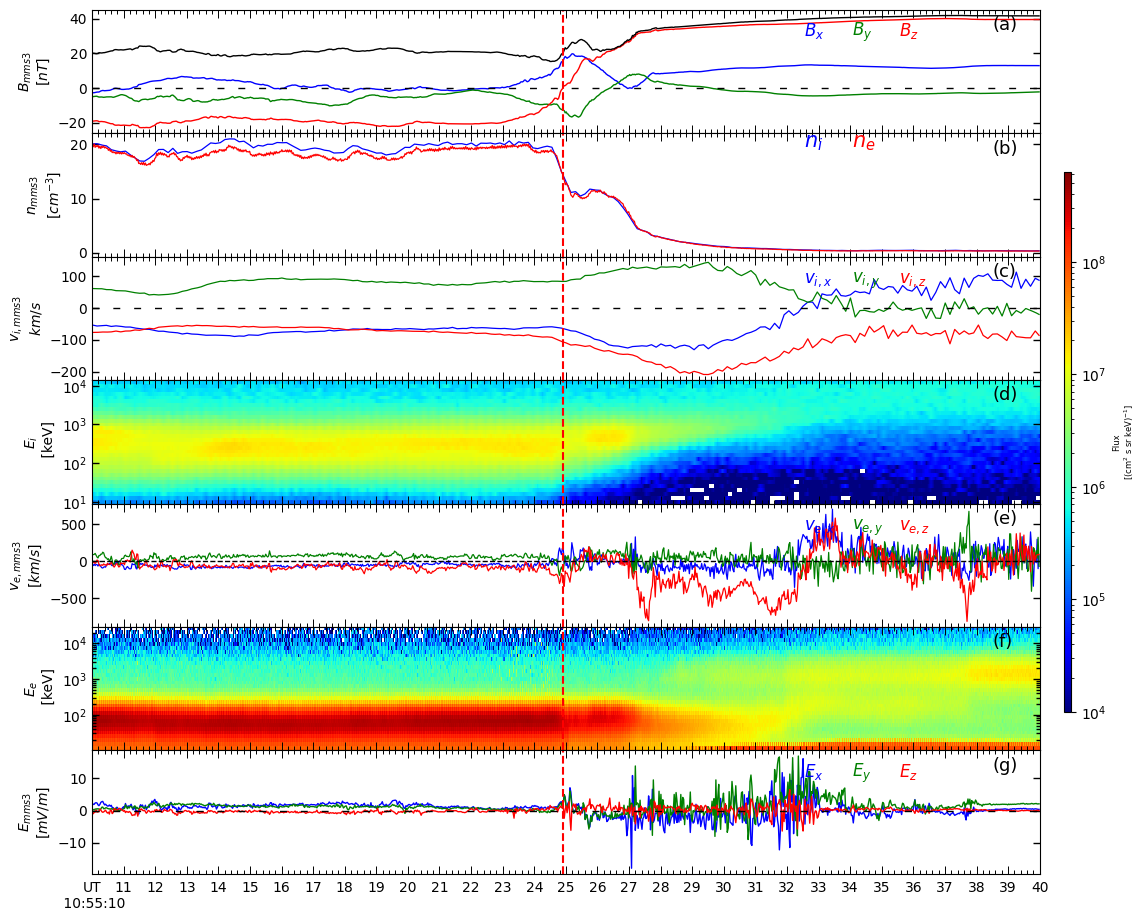

In [32]:
figh, axsh = plt.subplots(7, 1, figsize=[12, 9], sharex=True, gridspec_kw={'hspace': 0})

axsh[0].plot(mms3i_bdataset.time.sel(time=slice(del3,del4)), mms3i_bdataset.mms3_fgm_b_gse_brst_l2.sel(time=slice(del3,del4),v_dim=0), c='b', lw=1,label='Bx')
axsh[0].plot(mms3i_bdataset.time.sel(time=slice(del3,del4)), mms3i_bdataset.mms3_fgm_b_gse_brst_l2.sel(time=slice(del3,del4),v_dim=1), c='g', lw=1,label='By')
axsh[0].plot(mms3i_bdataset.time.sel(time=slice(del3,del4)), mms3i_bdataset.mms3_fgm_b_gse_brst_l2.sel(time=slice(del3,del4),v_dim=2), c='r', lw=1,label='Bz')
axsh[0].plot(mms3i_bdataset.time.sel(time=slice(del3,del4)), mms3i_bdataset.mms3_fgm_b_gse_brst_l2.sel(time=slice(del3,del4),v_dim=3), c='k', lw=1,label='Bz')
axsh[0].axhline(y=0, c='k', ls=(0, (5, 10)), lw=1)
axsh[0].text(0.95,0.95, '(a)', transform=axsh[0].transAxes, fontsize=13, va='top')
axsh[0].annotate(r'$\mathit{B_x}$', xy=(0.75, 0.8), xycoords='axes fraction', style='italic',
                fontsize=12, color='b', xytext=(1, -1), textcoords='offset points')  # Annotation for Bx in blue
axsh[0].annotate(r'$\mathit{B_y}$', xy=(0.80, 0.8), xycoords='axes fraction', style='italic',
                fontsize=12, color='g', xytext=(1, -1), textcoords='offset points')  # Annotation for By in green
axsh[0].annotate(r'$\mathit{B_z}$', xy=(0.85, 0.8), xycoords='axes fraction', style='italic',
                fontsize=12, color='r', xytext=(1, -1), textcoords='offset points')  # Annotation for Bz in red
axsh[0].set_xlim(mms3i_bdataset.time.sel(time=slice(del3,del4))[0],mms3i_bdataset.time.sel(time=slice(del3,del4))[-1])
axsh[0].set_ylabel(r'$\mathbf{\mathit{B_{mms3}}}$' + '\n' + r'$\mathit{[nT]}$', fontsize=10)


axsh[1].plot(mms3i_idataset.time.sel(time=slice(del3,del4)), 
            mms3i_idataset.mms3_dis_numberdensity_brst.sel(time=slice(del3,del4)), c='b', lw=0.9)
axsh[1].plot(mms3i_edataset.time.sel(time=slice(del3,del4)), 
            mms3i_edataset.mms3_des_numberdensity_brst.sel(time=slice(del3,del4)), c='r', lw=0.9) 
axsh[1].set_ylabel(r'$\mathbf{\mathit{n_{mms3}}}$' + '\n' + r'$\mathit{[cm^{-3}]}$', fontsize=10)
axsh[1].text(0.95,0.95, '(b)', transform=axsh[1].transAxes, fontsize=13, va='top')
axsh[1].set_xlim(mms3i_idataset.time.sel(time=slice(del3,del4))[0],
                mms3i_idataset.time.sel(time=slice(del3,del4))[-1])
axsh[1].annotate(r'$\mathit{n_i}$', xy=(0.75, 0.9), xycoords='axes fraction', style='italic',
                fontsize=15, color='b', xytext=(1, -1), textcoords='offset points')  # Annotation for Bx in blue
axsh[1].annotate(r'$\mathit{n_e}$', xy=(0.80, 0.9), xycoords='axes fraction', style='italic',fontsize=15, color='red', xytext=(1, -1), textcoords='offset points')  # Annotation for By in green

axsh[2].plot(mms3i_idataset.time.sel(time=slice(del3,del4)), 
            mms3i_idataset.mms3_dis_bulkv_gse_brst.sel(time=slice(del3,del4)).sel(v_dim=0), c='b', lw=0.9)
axsh[2].plot(mms3i_idataset.time.sel(time=slice(del3,del4)), 
            mms3i_idataset.mms3_dis_bulkv_gse_brst.sel(time=slice(del3,del4)).sel(v_dim=1), c='g', lw=0.9)
axsh[2].plot(mms3i_idataset.time.sel(time=slice(del3,del4)), 
            mms3i_idataset.mms3_dis_bulkv_gse_brst.sel(time=slice(del3,del4)).sel(v_dim=2), c='r', lw=0.9)
axsh[2].set_xlim(mms3i_idataset.time.sel(time=slice(del3,del4))[0],
                mms3i_idataset.time.sel(time=slice(del3,del4))[-1])
axsh[2].set_ylabel(r'$\mathbf{\mathit{v_{i,mms3}}}$' + '\n' + r'$\mathit{km/s}$', fontsize=10)
axsh[2].text(0.95,0.95, '(c)', transform=axsh[2].transAxes, fontsize=13, va='top')
axsh[2].axhline(y=0, c='k',  ls=(0, (5, 10)), lw=1)
axsh[2].annotate(r'$\mathit{v_{i,x}}$', xy=(0.75, 0.8), xycoords='axes fraction', style='italic',
                fontsize=12, color='b', xytext=(1, -1), textcoords='offset points')  # Annotation for Bx in blue
axsh[2].annotate(r'$\mathit{v_{i,y}}$', xy=(0.80, 0.8), xycoords='axes fraction', style='italic',
                fontsize=12, color='g', xytext=(1, -1), textcoords='offset points')  # Annotation for By in green
axsh[2].annotate(r'$\mathit{v_{i,z}}$', xy=(0.85, 0.8), xycoords='axes fraction', style='italic',
                fontsize=12, color='r', xytext=(1, -1), textcoords='offset points')  # Annotation for Bz in red
#axs[2].axvspan(timestamps_of_sign_changes.time[0].values,timestamps_of_sign_changes.time[1].values, color='yellow', alpha=0.5)  # highlight the region 
axsh[2].set_ylabel(r'$\mathbf{\mathit{v_{i,mms3}}}$' + '\n' + r'$\mathit{km/s}$', fontsize=10)



# Plot using pcolormesh with LogNorm
pcmi = axsh[3].pcolormesh(mms3i_idataset.mms3_dis_energyspectr_omni_brst.time.sel(time=slice(del3,del4)),
                     mms3i_idataset.mms3_dis_energyspectr_omni_brst.spec_bins.sel(time=slice(del3,del4)).e_dim,
                     mms3i_idataset.mms3_dis_energyspectr_omni_brst.sel(time=slice(del3,del4)).T, cmap='jet',
                     norm=mcolors.LogNorm(vmin=1e4, vmax=1e8 * 10 ** 0.8), rasterized=True, shading="auto")

axsh[3].set_ylabel("$E_{i}$ \n [keV]")

# Set y-axis ticks as powers of 10
ticks = [f'$10^{{{int(np.log10(value))}}}$' if value > 0 else '0' for value in
         mms3i_edataset.mms3_des_energyspectr_omni_brst.spec_bins.sel(time=slice(del3,del4), e_dim=[0, 10, 20, 30])[0]]
axsh[3].set_yticks([0, 10, 20, 30], ticks)
axsh[3].text(0.95,0.95, '(d)', transform=axsh[3].transAxes, fontsize=13, va='top')

axsh[4].plot(mms3i_edataset.time.sel(time=slice(del3,del4)), mms3i_edataset.mms3_des_bulkv_gse_brst.sel(v_dim=0).sel(time=slice(del3,del4)), c='b', lw=0.9,label='Vi,x')
axsh[4].plot(mms3i_edataset.time.sel(time=slice(del3,del4)), mms3i_edataset.mms3_des_bulkv_gse_brst.sel(v_dim=1).sel(time=slice(del3,del4)), c='g', lw=0.9,label='Vi,y')
axsh[4].plot(mms3i_edataset.time.sel(time=slice(del3,del4)), mms3i_edataset.mms3_des_bulkv_gse_brst.sel(v_dim=2).sel(time=slice(del3,del4)), c='r', lw=0.9,label='Vi,z')
axsh[4].axhline(y=0, c='k', ls='--', lw=1)
axsh[4].text(0.95,0.95, '(e)', transform=axsh[4].transAxes, fontsize=13, va='top')
axsh[4].annotate(r'$\mathit{v_{e,x}}$', xy=(0.75, 0.8), xycoords='axes fraction', style='italic',
                fontsize=12, color='b', xytext=(1, -1), textcoords='offset points')  # Annotation for Bx in blue
axsh[4].annotate(r'$\mathit{v_{e,y}}$', xy=(0.80, 0.8), xycoords='axes fraction', style='italic',
                fontsize=12, color='g', xytext=(1, -1), textcoords='offset points')  # Annotation for By in green
axsh[4].annotate(r'$\mathit{v_{e,z}}$', xy=(0.85, 0.8), xycoords='axes fraction', style='italic',
                fontsize=12, color='r', xytext=(1, -1), textcoords='offset points')  # Annotation for Bz in red
axsh[4].set_ylabel(r"$\mathbf{\mathit{v_{e,mms3}}}$" + '\n' + r"$[\mathit{km/s}]$", fontsize=10)


# Plot using pcolormesh with LogNorm
pcme = axsh[5].pcolormesh(mms3i_edataset.mms3_des_energyspectr_omni_brst.time.sel(time=slice(del3,del4)),
                     mms3i_edataset.mms3_des_energyspectr_omni_brst.spec_bins.sel(time=slice(del3,del4)).mean(dim='time'),
                     mms3i_edataset.mms3_des_energyspectr_omni_brst.sel(time=slice(del3,del4)).T, cmap='jet',
                     norm=mcolors.LogNorm(vmin=1e4, vmax=1e8 * 10 ** 0.8), rasterized=True, shading="auto")

axsh[5].set_ylabel("$E_{e}$ \n [keV]")
axsh[5].set_yscale('log')
axsh[5].text(0.95,0.95, '(f)', transform=axsh[5].transAxes, fontsize=13, va='top')
# Create a new axis for the colorbar
cbar_ax = plt.axes([0.92, 0.2, 0.006, 0.6])  #  
# 92% of the width of the figure from the left edge.
#10% of the height of the figure from the bottom edge.
#2% of the width of the figure.
#80% of the height of the figure
# Add colorbar
cbar = plt.colorbar(pcme, cax=cbar_ax)
cbar.set_label("Flux" + "\n" + "[(cm$^2$ s sr keV)$^{-1}$]", fontsize=6)
axsh[6].plot(mms3i_Edataset.time.sel(time=slice(del3,del4)), mms3i_Edataset.sel(v_dim=0,time=slice(del3,del4)), c='b', lw=1,label='Bx')
axsh[6].plot(mms3i_Edataset.time.sel(time=slice(del3,del4)), mms3i_Edataset.sel(v_dim=1,time=slice(del3,del4)), c='g', lw=1,label='By')
axsh[6].plot(mms3i_Edataset.time.sel(time=slice(del3,del4)), mms3i_Edataset.sel(v_dim=2,time=slice(del3,del4)), c='r', lw=1,label='Bz')
axsh[6].axhline(y=0, c='k', ls=(0, (5, 10)), lw=1)
axsh[6].text(0.95,0.95, '(g)', transform=axsh[6].transAxes, fontsize=13, va='top')
axsh[6].annotate(r'$\mathit{E_x}$', xy=(0.75, 0.8), xycoords='axes fraction', style='italic',
                fontsize=12, color='b', xytext=(1, -1), textcoords='offset points')  # Annotation for Bx in blue
axsh[6].annotate(r'$\mathit{E_y}$', xy=(0.80, 0.8), xycoords='axes fraction', style='italic',
                fontsize=12, color='g', xytext=(1, -1), textcoords='offset points')  # Annotation for By in green
axsh[6].annotate(r'$\mathit{E_z}$', xy=(0.85, 0.8), xycoords='axes fraction', style='italic',
                fontsize=12, color='r', xytext=(1, -1), textcoords='offset points')  # Annotation for Bz in red
axsh[6].set_xlim(mms3i_Edataset.time.sel(time=del3,method='nearest'),mms3i_Edataset.time.sel(time=del4,method='nearest'))
#axs[0].axvspan(timestamps_of_sign_changes.time[0].values,timestamps_of_sign_changes.time[1].values, color='yellow', alpha=0.5)  # highlight the region 
axsh[6].set_ylabel(r'$\mathbf{\mathit{E_{mms3}}}$' + '\n' + r'$\mathit{[mV/m]}$', fontsize=9)
axsh[6].yaxis.label.set_size(10)
for ax in axsh:
    major_tick_labels[0] = (major_tick_labels[0], 'left') 
    ax.tick_params(axis='x', which='major', labelsize=9,size=6,width=0.7,pad=5,direction='in',top=True,bottom=True)
    ax.tick_params(axis='x', which='minor', labelsize=9,size=3,width=0.7,pad=1,direction='in',top=True,bottom=True)
    ax.tick_params(axis='y', which='major', direction='in',left=True,right=True,
                 width=1, length=5,labelsize=10)  # Adjust width and length as needed
    ax.tick_params(axis='y', which='minor', direction='in',left=True,right=True, 
                   width=1, length=3,labelsize=10)
    ax.set_xticks(xticks(del3,del4)[0])
    # Set minor x-axis ticks
    ax.set_xticks(xticks(del3,del4)[1], minor=True)
   # Format x-axis tick labels using the custom function
    ax.set_xticklabels(xticks(del3,del4)[2], rotation=0, fontsize=10)
    ax.axvline(Bz[0].values,ls='--',c='r') #value obtained form below,change to MP crossing timestamp accordingly
    

plt.tight_layout(pad=1)  # Adjust padding
plt.subplots_adjust(top=0.98, bottom=0.02, left=0.11, right=0.9, hspace=0.1)
plt.savefig(os.path.join(output_folder, f"{taistarttime}_b.png"), dpi=1200,format='png',bbox_inches='tight')

plt.show()

In [33]:
output_folder

'D:\\hallsim\\mms\\pydata\\trial\\Plots\\20151016105454'

In [34]:
def get_data(t1,t2):
    
    B1 = mms1i_brdataset.mms1_fgm_b_gse_brst_l2.sel(time=slice(t1,t2),v_dim=slice(0, 3))
    B2 = mms2i_brdataset.mms2_fgm_b_gse_brst_l2.sel(time=slice(t1,t2),v_dim=slice(0, 3))
    B3 = mms3i_brdataset.mms3_fgm_b_gse_brst_l2.sel(time=slice(t1,t2),v_dim=slice(0, 3))
    B4 = mms4i_brdataset.mms4_fgm_b_gse_brst_l2.sel(time=slice(t1,t2),v_dim=slice(0, 3))

    R1 = mms1i_brdataset.mms1_fgm_r_gse_brst_l2.sel(time=slice(t1,t2),v_dim=slice(0, 3))
    R2 = mms2i_brdataset.mms2_fgm_r_gse_brst_l2.sel(time=slice(t1,t2),v_dim=slice(0, 3))
    R3 = mms3i_brdataset.mms3_fgm_r_gse_brst_l2.sel(time=slice(t1,t2),v_dim=slice(0, 3))
    R4 = mms4i_brdataset.mms4_fgm_r_gse_brst_l2.sel(time=slice(t1,t2),v_dim=slice(0, 3))
    
    BT_concat = xr.concat([B1,B2,B3,B4],dim='time')
    BS_concat = xr.concat([B1,B2,B3,B4],dim='spacecraft')
    RS_concat = xr.concat([R1,R2,R3,R4],dim='spacecraft')

    BS_mean = xr.apply_ufunc(np.mean,BS_concat,
                                    input_core_dims=[['spacecraft']],
                                    kwargs={"axis": -1})
    BS_cov = xr.apply_ufunc(np.cov,BS_mean,exclude_dims={'time'},
                                   input_core_dims=[['time','v_dim']],
                                   output_core_dims=[['dim1','v_dim']],
                                   kwargs={"rowvar": False})
    eigen = xr.apply_ufunc(np.linalg.eigh,BS_cov,
                           input_core_dims=[['dim1','v_dim']])
    #w = eigen.item().eigenvalues
    #v = eigen.item().eigenvectors
    
    return [BT_concat,BS_concat,RS_concat,BS_mean]

# MVA Analysis

__Single Spacecraft Analysis__: 
- MVAB is applied independently to the dataset from each individual spacecraft involved in the study. 
- Each spacecraft's dataset is analyzed separately to determine the minimum variance direction of the magnetic field.

In [35]:
def mva_b(mms):
    np_mean = np.mean(mms,axis = mms.get_axis_num("time"))
    np_mean = np.mean(mms, axis=0)
    vecavg = np.nanmean(np.nan_to_num(mms, nan=0.0), axis=0)
    xr_mean = mms.mean(dim='time')
    xr_mean = xr.apply_ufunc(
    # function to apply
    np.mean,
    # object with data to pass to function
    mms,
    # keyword arguments to pass to np.mean
    input_core_dims=[["time"]],  # core dimension for ds
    kwargs={"axis": -1})
    # Covariance Matrix Calculation
    np_cov = np.cov(mms, rowvar=False)
    np1_cov = np.cov(mms.T)
    
    
    mvamat = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            mvamat[i, j] = np.nanmean(np.nan_to_num(mms[:, i] * mms[:, j], nan=0.0)) - vecavg[i] * vecavg[j]
        
    xr_cov = xr.apply_ufunc(np.cov,mms,exclude_dims=({'time'}),input_core_dims=[['time','v_dim']],output_core_dims=[['dim1','v_dim']],kwargs={"rowvar": False})

    # Eigenvalue Decomposition
    w, v = np.linalg.eigh(mvamat, UPLO='U')
    [eigenvalues, eigenvectors] = np.linalg.eigh(np_cov)
    eigenvalues,eigenvectors = np.linalg.eigh(np.cov(mms.T))
    eigenvec = xr.apply_ufunc(np.linalg.eigh,xr_cov,input_core_dims=[['dim1','v_dim']])

    # Sorting to ensure descending order
    w_index = np.abs(w)
    idx = np.flip(np.argsort(w_index))
    w = np.sort(w)[::-1]
    v = v[:, idx]

    # Ensure maxvar direction is along +Z (for FAC system)
    if v[2, 0] < 0:
        v[:, 0] = - v[:, 0]
    if v[0,2] < 0:
        v[:,2] = - v[:, 2]

    # Rotate intermediate var direction if system is not Right Handed
    if v[0, 0] * (v[1, 1] * v[2, 2] - v[2, 1] * v[1, 2]) < 0:
        v[:,1] = -v[:,1]
    
    # Calculate ratios of sorted eigenvalues
    lambda_1_2 = w[0] / w[1]
    lambda_2_3 = w[1] / w[2]

    #if lambda_1_2 > 10 and lambda_2_3 > 2:
     #   print("Minimum variance direction (N) is adequately defined.", lambda_1_2,lambda_2_3)
        
   # else:
    #    print("Minimum variance direction (N) may not be adequately defined.", lambda_1_2,lambda_2_3)

    LMN = xr.Dataset({'eigenrat':xr.DataArray(np.array([lambda_1_2,lambda_2_3]),dims=['ratios']),
                      'eigenval':xr.DataArray(w,dims=['values']),
                      'eigenvec':xr.DataArray(v,dims=['vec','LMN'])})
    return [LMN,lambda_1_2,lambda_2_3]

In [36]:
del3,del4

(np.datetime64('2015-10-16T10:55:10.000000000'),
 np.datetime64('2015-10-16T10:55:40.000000000'))

In [37]:
Bz = find(mms3i_brdataset.mms3_fgm_b_gse_brst_l2,v_dim=2,d1=del3,d2=del4)
Bz[0].values,Bz[1]

(np.datetime64('2015-10-16T10:55:24.919474000'), np.int64(496))

09-Jul-25 15:54:41: C:\Users\DIPS\AppData\Local\Temp\ipykernel_2368\495184109.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1)  # Adjust padding



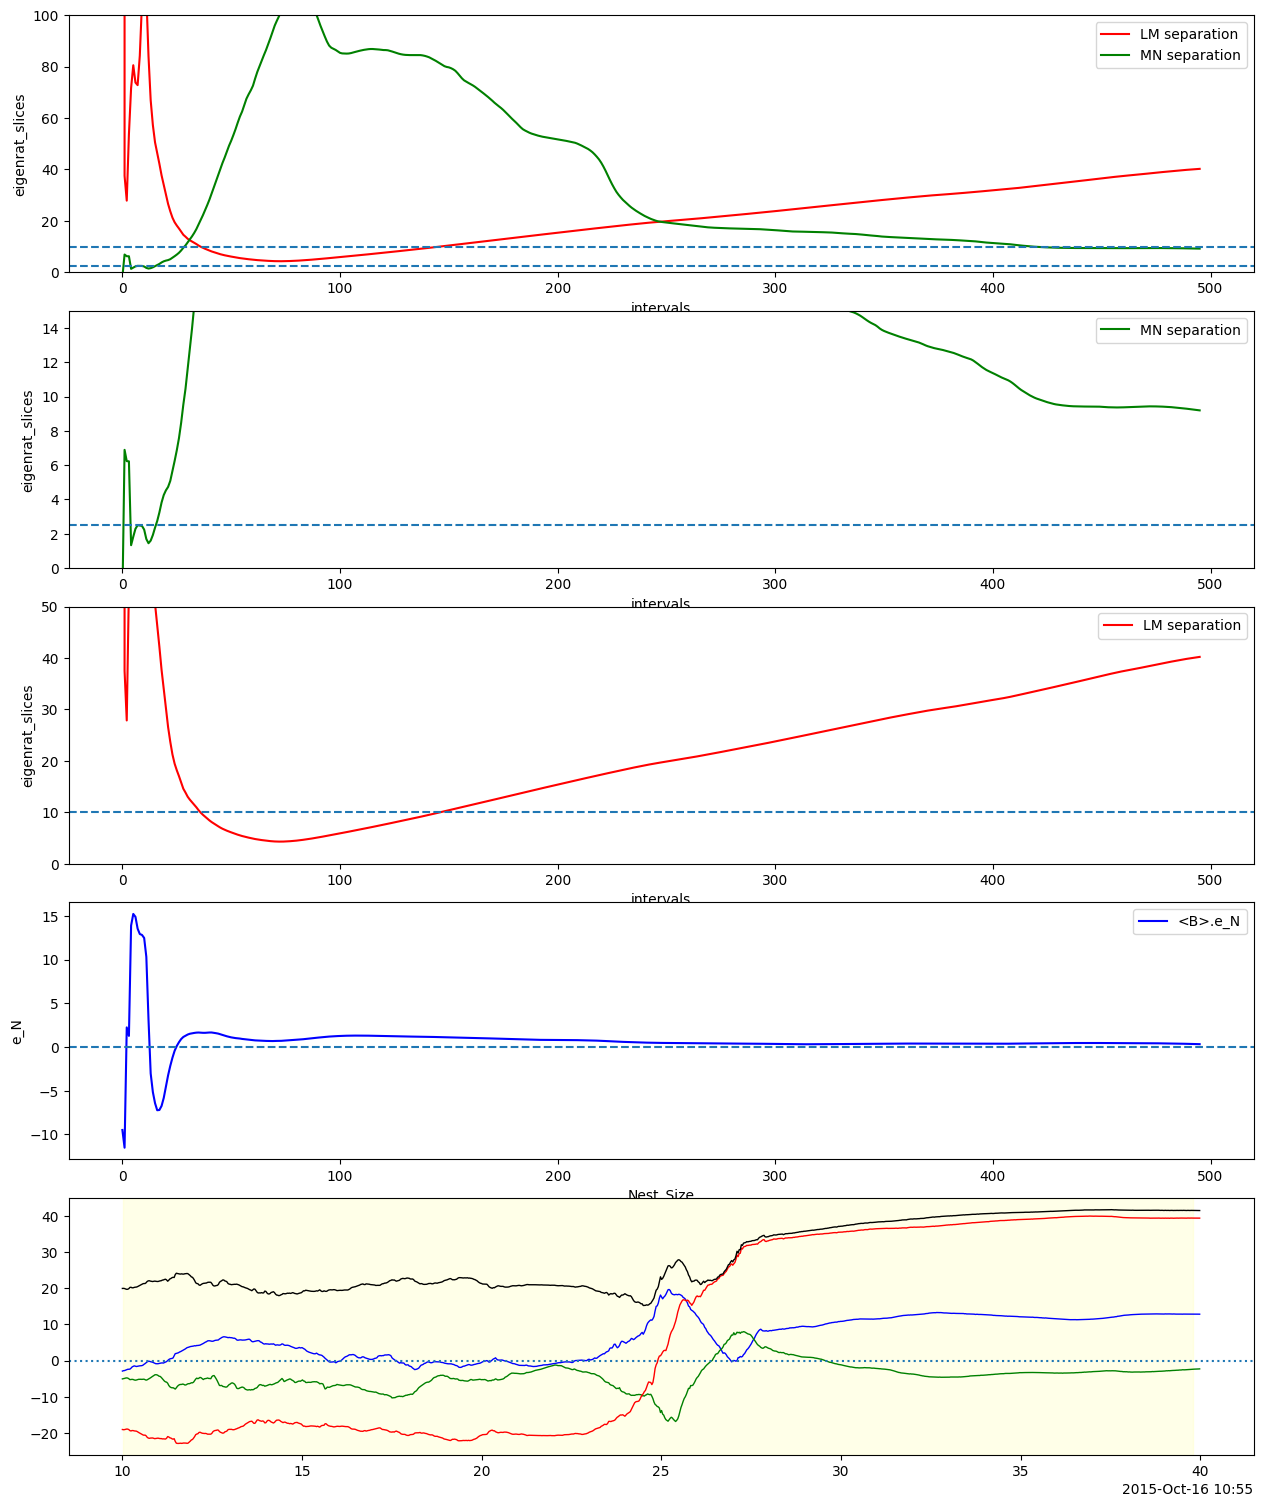

In [38]:
eigenrat_slices = []
eigenval_slices = []
mean_slices = []
eigenvec_slices = []
ndot_slices = []

indices_data = []
time_data = []
index_data= []

additional_points = range(0, Bz[1] +1)  # Adjust range based on crossing_index
start_index =  Bz[1]
end_index =  Bz[1] + 2

while True:
    if start_index <= 0 or end_index >= len(mms3i_bdataset.mms3_fgm_b_gse_brst_l2.time.sel(time=slice(del3, del4))):
         break
        # Get start and end times
    start_time = mms3i_bdataset.mms3_fgm_b_gse_brst_l2.time.sel(time=slice(del3, del4)).isel(time=start_index).values
    end_time = mms3i_bdataset.mms3_fgm_b_gse_brst_l2.time.sel(time=slice(del3, del4)).isel(time=end_index).values
    mean = mms3i_bdataset.mms3_fgm_b_gse_brst_l2.sel(time=slice(del3, del4),v_dim=slice(0,3)).isel(time=slice(start_index,end_index)).mean(dim='time')
        # Append data
    LMN = mva_b(mms3i_bdataset.mms3_fgm_b_gse_brst_l2.sel(time=slice(del3, del4)).isel(time=slice(start_index, end_index)))[0]
    eigenrat_slices.append(LMN.eigenrat.values)
    eigenval_slices.append(LMN.eigenval.values)
    mean_slices.append(mean)
    eigenvec_slices.append(LMN.eigenvec.sel(LMN=2).values)
    indices_data.append([start_index, end_index])
    index_data.append(start_index)
    time_data.append([start_time, end_time])
        # Update start_index and end_index for the next iteration
    start_index -= 1
    end_index += 1
       
nested_mva = xr.Dataset({
    'eigenrat_slices': (['intervals', 'ratios'], eigenrat_slices),
    'eigenval_slices': (['intervals', 'values'], eigenval_slices),
    'e_N': (['intervals','values'], eigenvec_slices),
    'B_av': (['intervals','values'], mean_slices),
}, coords={
    'indices': (['intervals', 'range'], indices_data),
    'start_index': (['intervals'], index_data),
    'time': (['intervals', 'range'], time_data)
})

fig, ax = plt.subplots(5,1,figsize=(15, 15),sharex=False, gridspec_kw={'hspace': 0.15})
nested_mva.eigenrat_slices.sel(ratios=0).plot(ax=ax[0], color='r', label='LM separation')
nested_mva.eigenrat_slices.sel(ratios=1).plot(ax=ax[0], color='g', label='MN separation')
ax[0].set_ylim(0, 100)
ax[0].axhline(y=2.5,ls='--')
ax[0].axhline(y=10,ls='--')
ax[0].legend()
nested_mva.eigenrat_slices.sel(ratios=1).plot(ax=ax[1], color='g', label='MN separation')
ax[1].set_ylim(0, 15)
ax[1].axhline(y=2.5,ls='--')
ax[1].legend()
nested_mva.eigenrat_slices.sel(ratios=0).plot(ax=ax[2], color='r', label='LM separation')
ax[2].set_ylim(0, 50)
ax[2].axhline(y=10,ls='--')
ax[2].legend()
xr.dot(nested_mva.e_N,nested_mva.B_av,dim=['values']).plot(ax=ax[3], color='b',label='<B>.e_N')
ax[3].set_xlabel('Nest_Size')
ax[3].axhline(y=0,ls='--')
ax[3].legend()

ax[4].plot(mms3i_bdataset.time.sel(time=slice(del3,del4)),mms3i_bdataset.mms3_fgm_b_gse_brst_l2.sel(time=slice(del3,del4),v_dim=0), c='b', lw=1, label='Bx')
ax[4].plot(mms3i_bdataset.time.sel(time=slice(del3,del4)),mms3i_bdataset.mms3_fgm_b_gse_brst_l2.sel(time=slice(del3,del4),v_dim=1), c='g', lw=1, label='By')
ax[4].plot(mms3i_bdataset.time.sel(time=slice(del3,del4)),mms3i_bdataset.mms3_fgm_b_gse_brst_l2.sel(time=slice(del3,del4),v_dim=2), c='r', lw=1, label='Bz')
ax[4].plot(mms3i_bdataset.time.sel(time=slice(del3,del4)),mms3i_bdataset.mms3_fgm_b_gse_brst_l2.sel(time=slice(del3,del4),v_dim=3), c='k', lw=1, label='Bz')
ax[4].axvspan(nested_mva.time[-1][0].values, nested_mva.time[-1][1].values,color=(1, 1, 0.7), alpha=0.3, label='Highlighted Span')
ax[4].axhline(y=0,ls=':')

plt.tight_layout(pad=1)  # Adjust padding
plt.subplots_adjust(top=0.98, bottom=0.02, left=0.11, right=0.9, hspace=0.1)
plt.savefig(os.path.join(output_folder, f"{taistarttime}_{'mva'}.png"), dpi=1200,format='png',bbox_inches='tight')

plt.show()

09-Jul-25 21:51:34: C:\Users\DIPS\AppData\Local\Temp\ipykernel_2368\3299697861.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1)  # Adjust padding



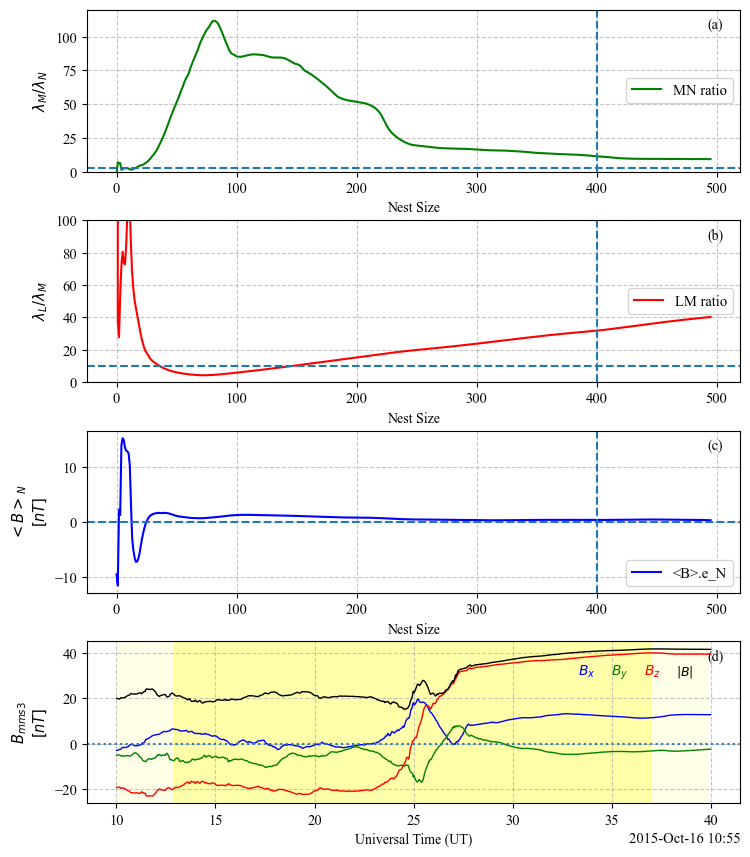

In [157]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set up the font properties
rcParams['font.family'] = 'Times New Roman'  # Default font for numbers
rcParams['font.size'] = 10.5  # Font size for numbers

fig, ax = plt.subplots(4, 1, figsize=(8.27, 8.27), sharex=False, gridspec_kw={'hspace': 0.3})

# First plot (a) - MN ratio
nested_mva.eigenrat_slices.sel(ratios=1).plot(ax=ax[0], color='g', label='MN ratio')
ax[0].set_ylim(0, 120)
ax[0].axhline(y=2.5, ls='--')
ax[0].legend()
ax[0].axvline(x=400, ls='--')
ax[0].set_ylabel(r'$\lambda_M/\lambda_N$', fontsize=10.5)  # Set font size to 10.5 pt for SimSun text
ax[0].set_xlabel('Nest Size', fontsize=10) 

# Second plot (b) - LM ratio
nested_mva.eigenrat_slices.sel(ratios=0).plot(ax=ax[1], color='r', label='LM ratio')
ax[1].set_ylim(0, 100)
ax[1].axhline(y=10, ls='--')
ax[1].legend()
ax[1].axvline(x=400, ls='--')
ax[1].set_ylabel(r'$\lambda_L/\lambda_M$', fontsize=10.5)
ax[1].set_xlabel('Nest Size', fontsize=10) 

# Third plot (c) - <B>.e_N
xr.dot(nested_mva.e_N, nested_mva.B_av, dim=['values']).plot(ax=ax[2], color='b', label='<B>.e_N')
ax[2].set_xlabel('Nest Size', fontsize=10)  # Font size for numbers in axis labels
ax[2].axhline(y=0, ls='--')
ax[2].legend()
ax[2].axvline(x=400, ls='--')
ax[2].set_ylabel(r'$<B>_N$' + '\n' + r'$[nT]$', fontsize=10.5)  # 10.5 pt SimSun for text

# Fourth plot (d) - Magnetic field components
ax[3].plot(mms3i_bdataset.time.sel(time=slice(del3, del4)), mms3i_bdataset.mms3_fgm_b_gse_brst_l2.sel(time=slice(del3, del4), v_dim=0), c='b', lw=1, label='Bx')
ax[3].plot(mms3i_bdataset.time.sel(time=slice(del3, del4)), mms3i_bdataset.mms3_fgm_b_gse_brst_l2.sel(time=slice(del3, del4), v_dim=1), c='g', lw=1, label='By')
ax[3].plot(mms3i_bdataset.time.sel(time=slice(del3, del4)), mms3i_bdataset.mms3_fgm_b_gse_brst_l2.sel(time=slice(del3, del4), v_dim=2), c='r', lw=1, label='Bz')
ax[3].plot(mms3i_bdataset.time.sel(time=slice(del3, del4)), mms3i_bdataset.mms3_fgm_b_gse_brst_l2.sel(time=slice(del3, del4), v_dim=3), c='k', lw=1, label='Bz')
ax[3].axvspan(nested_mva.time[-1][0].values, nested_mva.time[-1][1].values, color=(1, 1, 0.7), alpha=0.3, label='Highlighted Span')
ax[3].axvspan(nested_mva.isel(intervals=400).time[0].values, nested_mva.isel(intervals=400).time[1].values, color=(1, 1, 0.1), alpha=0.3, label='Highlighted Span')
ax[3].axhline(y=0, ls=':')
ax[3].set_xlabel('Universal Time (UT)', fontsize=10)  # 10 pt Times New Roman for UT
ax[3].set_ylabel(r'$B_{mms3}$' + '\n' + r'$[nT]$', fontsize=10.5)  # 10.5 pt SimSun for text

# Annotations
ax[3].annotate(r'$\mathit{B_x}$', xy=(0.75, 0.8), xycoords='axes fraction', fontsize=10, color='b', xytext=(1, -1), textcoords='offset points')  # Annotation for Bx in blue
ax[3].annotate(r'$\mathit{B_y}$', xy=(0.80, 0.8), xycoords='axes fraction', fontsize=10, color='g', xytext=(1, -1), textcoords='offset points')  # Annotation for By in green
ax[3].annotate(r'$\mathit{B_z}$', xy=(0.85, 0.8), xycoords='axes fraction', fontsize=10, color='r', xytext=(1, -1), textcoords='offset points')  # Annotation for Bz in red
ax[3].annotate(r'$\mathit{|B|}$', xy=(0.9, 0.8), xycoords='axes fraction',  fontsize=9, color='k', xytext=(1, -1), textcoords='offset points')  # Annotation for |B| in black

# Adjust padding around and between subplots
ax[0].text(0.95, 0.95, '(a)', transform=ax[0].transAxes, fontsize=10, va='top') 
ax[1].text(0.95, 0.95, '(b)', transform=ax[1].transAxes, fontsize=10, va='top') 
ax[2].text(0.95, 0.95, '(c)', transform=ax[2].transAxes, fontsize=10, va='top') 
ax[3].text(0.95, 0.95, '(d)', transform=ax[3].transAxes, fontsize=10, va='top') 

# Apply grid to all axes
for ax_i in ax:  # Iterate over all subplot axes
    ax_i.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout(pad=1)  # Adjust padding
plt.subplots_adjust(top=0.98, bottom=0.02, left=0.11, right=0.9, hspace=0.1)
plt.savefig(os.path.join(output_folder, f"{taistarttime}_{'mva'}.png"), dpi=1200,format='png',bbox_inches='tight')

# Show the plot
plt.grid(True)
plt.show()


In [49]:
hello = nested_mva.e_N.to_dataframe().reset_index()
csv_path = os.path.join(output_folder, 'e_N.csv')
hello.to_csv(csv_path, index=False)

## nested_mva

In [138]:
v=mva_b(mms3i_bdataset.
        mms3_fgm_b_gse_brst_l2.
        sel(time=slice(nested_mva.
                       isel(intervals=400).time[0],
                       nested_mva.isel(intervals=400).time[1])))[0]
v

<xarray.Dataset> Size: 112B
Dimensions:   (ratios: 2, values: 3, vec: 3, LMN: 3)
Dimensions without coordinates: ratios, values, vec, LMN
Data variables:
    eigenrat  (ratios) float64 16B 31.9 11.35
    eigenval  (values) float64 24B 736.3 23.08 2.033
    eigenvec  (vec, LMN) float64 72B 0.1722 0.674 0.7183 ... -0.06228 -0.1771

In [148]:
a=nested_mva.isel(intervals=400).time[0].values,
b=nested_mva.isel(intervals=400).time[1].values

In [153]:
a,b

((np.datetime64('2015-10-16T10:55:12.889474000'),),
 np.datetime64('2015-10-16T10:55:36.949474000'))

# Timing Analysis

In [52]:
del3,del4

(np.datetime64('2015-10-16T10:55:10.000000000'),
 np.datetime64('2015-10-16T10:55:40.000000000'))

In [53]:
lmn_b1 = xr.apply_ufunc(np.matmul,
                       mms1i_brdataset.mms1_fgm_b_gse_brst_l2.sel(time=slice(del3,del4),v_dim=slice(0,3)),
                       v.eigenvec,
                       input_core_dims=[['time','v_dim'],['vec','LMN']],
                       output_core_dims=[['time','LMN']],
                       dask='allowed')
lmn_b2 = xr.apply_ufunc(np.matmul,
                       mms2i_brdataset.mms2_fgm_b_gse_brst_l2.sel(time=slice(del3,del4),v_dim=slice(0,3)),
                       v.eigenvec,
                       input_core_dims=[['time','v_dim'],['vec','LMN']],
                       output_core_dims=[['time','LMN']],
                       dask='allowed')
lmn_b3 = xr.apply_ufunc(np.matmul,
                       mms3i_brdataset.mms3_fgm_b_gse_brst_l2.sel(time=slice(del3,del4),v_dim=slice(0,3)),
                       v.eigenvec,
                       input_core_dims=[['time','v_dim'],['vec','LMN']],
                       output_core_dims=[['time','LMN']],
                       dask='allowed')
lmn_b4 = xr.apply_ufunc(np.matmul,
                       mms4i_brdataset.mms4_fgm_b_gse_brst_l2.sel(time=slice(del3,del4),v_dim=slice(0,3)),
                       v.eigenvec,
                       input_core_dims=[['time','v_dim'],['vec','LMN']],
                       output_core_dims=[['time','LMN']],
                       dask='allowed')

In [54]:
B = get_data(del3,del4)[1]
R = get_data(del3,del4)[2]

delR12  = R.sel(spacecraft=1) - R.sel(spacecraft=0)
delR13  = R.sel(spacecraft=2) - R.sel(spacecraft=0)
delR14  = R.sel(spacecraft=3) - R.sel(spacecraft=0)
delR24  = R.sel(spacecraft=3) - R.sel(spacecraft=1)
delR34  = R.sel(spacecraft=3) - R.sel(spacecraft=2)
delR23  = R.sel(spacecraft=2) - R.sel(spacecraft=1)

k1 = xr.cross(delR23,delR24,dim='v_dim')
k2 = -xr.cross(delR34,delR13,dim='v_dim')
k3 = xr.cross(delR14,delR24,dim='v_dim')
k4 = xr.cross(delR12,delR13,dim='v_dim')

v1 = xr.dot(-delR12, xr.cross(delR23, delR24,dim='v_dim'),dim=['v_dim'])
v2 = xr.dot(delR23, xr.cross(delR34, delR13,dim='v_dim'),dim=['v_dim'])
v3 = xr.dot(-delR34, xr.cross(delR14, delR24,dim='v_dim'),dim=['v_dim'])
v4 = xr.dot(delR14, xr.cross(delR12, delR13,dim='v_dim'),dim=['v_dim'])
rec = xr.concat([k1/v1,k2/v2,k3/v3,k4/v4], dim='spacecraft').transpose('time','spacecraft','v_dim') # reciprocal vectors"

m1 = [mms1i_bdataset.time.sel(time=slice(del3,del4)).isel(time=mms1i_bdataset.mms1_fgm_b_gse_brst_l2.sel(time=slice(del3,del4),v_dim=3).argmin()).values,
      mms1i_bdataset.mms1_fgm_b_gse_brst_l2.sel(time=slice(del3,del4),v_dim=3).argmin()]
m2 = [mms2i_bdataset.time.sel(time=slice(del3,del4)).isel(time=mms2i_bdataset.mms2_fgm_b_gse_brst_l2.sel(time=slice(del3,del4),v_dim=3).argmin()).values,
      mms2i_bdataset.mms2_fgm_b_gse_brst_l2.sel(time=slice(del3,del4),v_dim=3).argmin()]
m3 = [mms3i_bdataset.time.sel(time=slice(del3,del4)).isel(time=mms3i_bdataset.mms3_fgm_b_gse_brst_l2.sel(time=slice(del3,del4),v_dim=3).argmin()).values,
      mms3i_bdataset.mms3_fgm_b_gse_brst_l2.sel(time=slice(del3,del4),v_dim=3).argmin()]
m4 = [mms4i_bdataset.time.sel(time=slice(del3,del4)).isel(time=mms4i_bdataset.mms4_fgm_b_gse_brst_l2.sel(time=slice(del3,del4),v_dim=3).argmin()).values,
      mms4i_bdataset.mms4_fgm_b_gse_brst_l2.sel(time=slice(del3,del4),v_dim=3).argmin()]

m1 = find(lmn_b1,LMN=0,d1=del3,d2=del4)
m2 = find(lmn_b2,LMN=0,d1=del3,d2=del4 )
m3 = find(lmn_b3,LMN=0,d1=del3,d2=del4)    
m4 = find(lmn_b4,LMN=0,d1=del3,d2=del4)


# Assuming mms3, mms2, mms3, and mms4 are in numpy datetime64 format
mms_dates = np.array([m1[0].values,m2[0].values,m3[0].values,m4[0].values], dtype='datetime64[ns]')
# Find the smallest date
min_date = np.min(mms_dates)
# Subtract the smallest date from all dates
mms = np.array((mms_dates - min_date),dtype='float')*1e-9
values = [('mms3', mms[0]), ('mms2', mms[1]), ('mms3', mms[2]), ('mms4', mms[3])]

# Sort the list based on the values in ascending order
sorted_values = sorted(values, key=lambda x: x[1])

# Identify the smallest value
smallest_value = sorted_values[0][1]

# Subtract the smallest value from each of the other values
differences = [(identifier, value - smallest_value) for identifier, value in values]

a = rec.sel(time=m1[0],spacecraft=0)*differences[0][1] 
b = rec.sel(time=m2[0],spacecraft=1)*differences[1][1]
c = rec.sel(time=m3[0],spacecraft=2)*differences[2][1]
d = rec.sel(time=m4[0],spacecraft=3)*differences[3][1]

m=a.values+b.values+c.values+d.values
m.ravel()
n=m/np.linalg.norm(m)
V=1/np.linalg.norm(m)
if n[0]<0:
   n[:]=-n[:]
n,V

09-Jul-25 15:55:44: D:\hallsim\Lib\site-packages\xarray\core\dataarray.py:6208: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead of da.argmin() or da.argmax().
  result = self.variable.argmin(dim, axis, keep_attrs, skipna)

09-Jul-25 15:55:44: D:\hallsim\Lib\site-packages\xarray\core\dataarray.py:6208: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead of da.argmin() or da.argmax().
  result = self.variable.argmin(dim, axis, keep_attrs, skipna)

09-Jul-25 15:55:44: D:\hallsim\Lib\site-packages\xarray\core\dataarray.py:6208: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict

(array([ 0.58507168,  0.79875032, -0.14031768]),
 np.float64(55.599439769666525))

In [55]:
B = get_data(del3,del4)[1]
R = get_data(del3,del4)[2]

delR12  = R.sel(spacecraft=1) - R.sel(spacecraft=0)
delR13  = R.sel(spacecraft=2) - R.sel(spacecraft=0)
delR14  = R.sel(spacecraft=3) - R.sel(spacecraft=0)
delR24  = R.sel(spacecraft=3) - R.sel(spacecraft=1)
delR34  = R.sel(spacecraft=3) - R.sel(spacecraft=2)
delR23  = R.sel(spacecraft=2) - R.sel(spacecraft=1)

k1 = xr.cross(delR23,delR24,dim='v_dim')
k2 = -xr.cross(delR34,delR13,dim='v_dim')
k3 = xr.cross(delR14,delR24,dim='v_dim')
k4 = xr.cross(delR12,delR13,dim='v_dim')

v1 = xr.dot(-delR12, xr.cross(delR23, delR24,dim='v_dim'),dim=['v_dim'])
v2 = xr.dot(delR23, xr.cross(delR34, delR13,dim='v_dim'),dim=['v_dim'])
v3 = xr.dot(-delR34, xr.cross(delR14, delR24,dim='v_dim'),dim=['v_dim'])
v4 = xr.dot(delR14, xr.cross(delR12, delR13,dim='v_dim'),dim=['v_dim'])
rec = xr.concat([k1/v1,k2/v2,k3/v3,k4/v4], dim='spacecraft').transpose('time','spacecraft','v_dim') # reciprocal vectors"

m1 = find(lmn_b1,LMN=0,d1=del3,d2=del4)
m2 = find(lmn_b2,LMN=0,d1=del3,d2=del4 )
m3 = find(lmn_b3,LMN=0,d1=del3,d2=del4)    
m4 = find(lmn_b4,LMN=0,d1=del3,d2=del4)

# Assuming mms3, mms2, mms3, and mms4 are in numpy datetime64 format
mms_dates = np.array([m1[0].values,m2[0].values,m3[0].values,m4[0].values], dtype='datetime64[ns]')
# Find the smallest date
min_date = np.min(mms_dates)
# Subtract the smallest date from all dates
mms = np.array((mms_dates - min_date),dtype='float')*1e-9
values = [('mms1', mms[0]), ('mms2', mms[1]), ('mms3', mms[2]), ('mms4', mms[3])]

# Sort the list based on the values in ascending order
sorted_values = sorted(values, key=lambda x: x[1])

# Identify the smallest value
smallest_value = sorted_values[0][1]

# Subtract the smallest value from each of the other values
differences = [(identifier, value - smallest_value) for identifier, value in values]

a = rec.sel(time=m1[0],spacecraft=0)*differences[0][1] 
b = rec.sel(time=m2[0],spacecraft=1)*differences[1][1]
c = rec.sel(time=m3[0],spacecraft=2)*differences[2][1]
d = rec.sel(time=m4[0],spacecraft=3)*differences[3][1]

m=a.values+b.values+c.values+d.values
m.ravel()
n=m/np.linalg.norm(m)
V=1/np.linalg.norm(m)
if n[0]<0:
   n[:]=-n[:]
n,V

(array([ 0.58507168,  0.79875032, -0.14031768]),
 np.float64(55.599439769666525))

In [56]:
L = v.eigenvec.sel(LMN=0).values
M = np.cross(n,L)
N = np.cross(L,M)

v1 = xr.Dataset({'eigenvec':xr.DataArray(np.array([L,M,N]).T,dims=['vec','LMN'])})
v1.eigenvec

<xarray.DataArray 'eigenvec' (vec: 3, LMN: 3)> Size: 72B
array([[ 0.15836299,  0.79892011,  0.57896158],
       [ 0.10478103, -0.59664774,  0.79470756],
       [ 0.98180553, -0.06518807, -0.1781986 ]])
Dimensions without coordinates: vec, LMN

In [57]:
values,sorted_values,m1[0],m2[0],m3[0],m4[0]

([('mms1', np.float64(0.0)),
  ('mms2', np.float64(0.18000000000000002)),
  ('mms3', np.float64(0.15000000000000002)),
  ('mms4', np.float64(0.15000000000000002))],
 [('mms1', np.float64(0.0)),
  ('mms3', np.float64(0.15000000000000002)),
  ('mms4', np.float64(0.15000000000000002)),
  ('mms2', np.float64(0.18000000000000002))],
 <xarray.DataArray 'time' ()> Size: 8B
 array('2015-10-16T10:55:24.709474000', dtype='datetime64[ns]')
 Coordinates:
     time     datetime64[ns] 8B 2015-10-16T10:55:24.709474
     epoch    datetime64[ns] 8B 2015-10-16T10:55:24.709474,
 <xarray.DataArray 'time' ()> Size: 8B
 array('2015-10-16T10:55:24.889474000', dtype='datetime64[ns]')
 Coordinates:
     time     datetime64[ns] 8B 2015-10-16T10:55:24.889474
     epoch    datetime64[ns] 8B 2015-10-16T10:55:24.889474,
 <xarray.DataArray 'time' ()> Size: 8B
 array('2015-10-16T10:55:24.859474000', dtype='datetime64[ns]')
 Coordinates:
     time     datetime64[ns] 8B 2015-10-16T10:55:24.859474
     epoch    datetime

In [145]:
del3,del4

(np.datetime64('2015-10-16T10:55:10.000000000'),
 np.datetime64('2015-10-16T10:55:40.000000000'))

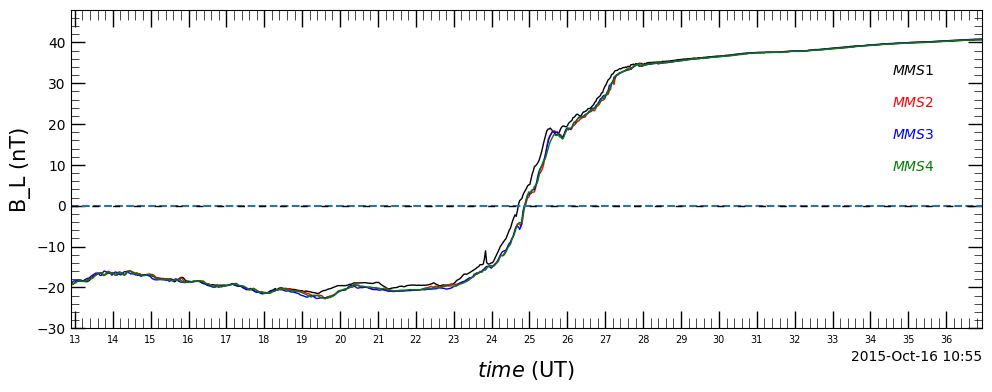

In [144]:
plt.style.use('default')

fig, axs = plt.subplots(1, 1, figsize=[10, 4], sharex=True)
axs.plot(lmn_b1.time.sel(time=slice(del3,del4)),lmn_b1.isel(LMN=0),c='k',lw=1, label='B_L')
axs.plot(lmn_b2.time.sel(time=slice(del3,del4)),lmn_b2.isel(LMN=0),c='r',lw=1, label='B_L')
axs.plot(lmn_b3.time.sel(time=slice(del3,del4)),lmn_b3.isel(LMN=0),c='b',lw=1, label='B_L')
axs.plot(lmn_b4.time.sel(time=slice(del3,del4)),lmn_b4.isel(LMN=0),c='g',lw=1, label='B_L')


#axs.plot(mms1i_bdataset.time.sel(time=slice(del3,del4)),mms1i_bdataset.mms1_fgm_b_gse_brst_l2.sel(v_dim=2,time=slice(del3,del4)) , c='k', lw=1,label='Bx')
#axs.plot(mms2i_bdataset.time.sel(time=slice(del3,del4)),mms2i_bdataset.mms2_fgm_b_gse_brst_l2.sel(v_dim=2,time=slice(del3,del4)) , c='r', lw=1,label='Bx')
#axs.plot(mms3i_bdataset.time.sel(time=slice(del3,del4)),mms3i_bdataset.mms3_fgm_b_gse_brst_l2.sel(v_dim=2,time=slice(del3,del4)), c='b', lw=1,label='Bx')
#axs.plot(mms4i_bdataset.time.sel(time=slice(del3,del4)),mms4i_bdataset.mms4_fgm_b_gse_brst_l2.sel(v_dim=2,time=slice(del3,del4)), c='g', lw=1,label='Bx')
axs.annotate(r'$\mathit{MMS1}$', xy=(0.9,0.8), xycoords='axes fraction', style='italic',
             fontsize=10, color='k', xytext=(1, -1), textcoords='offset points')  # Annotation for By in green
axs.annotate(r'$\mathit{MMS2}$', xy=(0.9, 0.7), xycoords='axes fraction', style='italic',
             fontsize=10, color='r', xytext=(1, -1), textcoords='offset points')  # Annotation for By in green
axs.annotate(r'$\mathit{MMS3}$', xy=(0.9, 0.6), xycoords='axes fraction', style='italic',
             fontsize=10, color='b', xytext=(1, -1), textcoords='offset points')  # Annotation for By in green
axs.annotate(r'$\mathit{MMS4}$', xy=(0.9, 0.5), xycoords='axes fraction', style='italic',
             fontsize=10, color='g', xytext=(1, -1), textcoords='offset points')  # Annotation for By in green
axs.set_ylabel(r'$\mathbf{\mathit{B_{L}}}$' + '\n' + r'$\mathit{[nT]}$', fontsize=10)
plt.grid(False)
plt.axhline(y=0, linestyle='--')

# Plot the data

plt.yticks(np.arange(np.round(np.min(lmn_b1.sel(LMN=0)), -B) - 10**B, 
                     np.round(np.max(lmn_b1), -B)+ 10**B, 
                     10 * B))
plt.yticks(np.arange(np.round(np.min(lmn_b1.sel(LMN=0)), -B) - 10**B, 
                     np.round(np.max(lmn_b1), -B)+ 10**B, 
                     2*B), 
           minor=True)

plt.xticks(xticks(del3,del4)[0])

    # Set minor x-axis ticks
plt.xticks(xticks(del3,del4)[1], minor=True)

#plt.axvline(Bz[0].values,ls='--',c='r') #value obtained form below,change to MP crossing timestamp accordingly
plt.axhline(y=0, c='k',  ls=(0, (5, 10)), lw=1)
# Axis labels
plt.xlabel(r'$\mathit{time}$ (UT)', fontsize=15, labelpad=10)
plt.ylabel('B_L (nT)', fontsize=15)

# Adjust tick parameters
plt.tick_params(axis='x', which='major', labelsize=7, size=12, width=1, length=15, pad=5, direction='in', top=True, bottom=True)
plt.tick_params(axis='x', which='minor', labelsize=7, size=7, width=0.5, length=9, pad=1, direction='in', top=True, bottom=True)
plt.tick_params(axis='y', which='major', direction='in', left=True, right=True, width=1, length=10, labelsize=10)
plt.tick_params(axis='y', which='minor', direction='in', left=True, right=True, width=0.5, length=6, labelsize=10)
plt.xlim(lmn_b1.time.sel(time=nested_mva.isel(intervals=400).time[0], method="nearest"), lmn_b1.time.sel(time=nested_mva.isel(intervals=400).time[1],method='nearest'))
plt.tight_layout(pad=1.0)
plt.savefig(os.path.join(output_folder, f"b{9}.png"), dpi=300)
plt.show()                            

# DeHoffman Teller Anlysis

In [59]:
vi = mms3i_idataset.mms3_dis_bulkv_gse_brst.sel(time=slice(del3,del4),v_dim=slice(0,3))
ve = mms3i_edataset.mms3_des_bulkv_gse_brst.sel(time=slice(del3,del4),v_dim=slice(0,3))
ni = mms3i_idataset.mms3_dis_numberdensity_brst.sel(time=slice(del3,del4))
mi = 1.67262192369e-27  # kg
me = 9.1093837015e-31  # kg
mu_0 = 4*np.pi * 1e-7*1e3
v_bulk = (mi*vi+me*ve)/(mi+me)
B  = get_data(del3,del4)[1].sel(spacecraft=2)

def compute_K_matrix(B_m):
    B_squared = np.dot(B_m, B_m)  # B^2 = B_x^2 + B_y^2 + B_z^2
    delta = np.eye(3)             # Kronecker delta, identity matrix of shape 3x3
    outer_product = np.outer(B_m, B_m)  # B_mu * B_nu

    # K(m) = B^2 * (delta - (B_mu * B_nu) / B^2)
    K_m = B_squared * (delta - outer_product / B_squared)
    return K_m

# Apply the function to all time steps
K_matrices = np.array([compute_K_matrix(B_m) for B_m in B])

from numpy.linalg import inv
# Number of measurements (time steps)
M = v_bulk.shape[0]

# Compute K_0 and the averaged term K(m) v(m)
K_0 = np.mean(K_matrices, axis=0)  # Averaged K(m)

# Compute K(m) v(m) for each time step and average
Kv_sum = np.zeros(3)
for m in range(M):
    Kv_sum += np.dot(K_matrices[m], v_bulk[m])

Kv_avg = Kv_sum / M
# Solve for V_HT
V_HT = np.dot(inv(K_0), Kv_avg)
V_ht = np.linalg.norm(V_HT)
V_HT,V_ht,np.dot(V_HT,n),V

(array([ -37.2846925 ,   45.82998109, -222.12387907]),
 np.float64(229.84680357866148),
 np.float64(45.96040200647471),
 np.float64(55.599439769666525))

In [61]:
# Assuming V_A and v_d are already defined with shape (n_samples, 3)
v_d = v_bulk-V_HT
V_A = B/np.sqrt(4*np.pi * 1e-7*1e3*ni*mi*1e6)

# Calculate the magnitudes of V_A and v_d
V_A_magnitude = np.linalg.norm(V_A, axis=1)  # Magnitude of V_A
v_d_magnitude = np.linalg.norm(v_d, axis=1)  # Magnitude of v_d



# MDD Analsysis


In [62]:
def mdd(t1,t2):
    B = get_data(t1,t2)[1].transpose('time','spacecraft','v_dim')
    R = get_data(t1,t2)[2].transpose('time','spacecraft','v_dim')

    delR12  = R.sel(spacecraft=1) - R.sel(spacecraft=0)
    delR13  = R.sel(spacecraft=2) - R.sel(spacecraft=0)
    delR14  = R.sel(spacecraft=3) - R.sel(spacecraft=0)
    delR24  = R.sel(spacecraft=3) - R.sel(spacecraft=1)
    delR34  = R.sel(spacecraft=3) - R.sel(spacecraft=2)
    delR23  = R.sel(spacecraft=2) - R.sel(spacecraft=1)

    unitb = B / np.sqrt(np.sum(B**2, axis=-1))
    #Bsqb = unitb*np.su
    
    Bsqb = B*np.sqrt(np.sum(B**2, axis=-1))

    k1 = xr.cross(delR23,delR24,dim='v_dim')
    k2 = -xr.cross(delR34,delR13,dim='v_dim')
    k3 = xr.cross(delR14,delR24,dim='v_dim')
    k4 = xr.cross(delR12,delR13,dim='v_dim')

    v1 = xr.dot(-delR12, xr.cross(delR23, delR24,dim='v_dim'),dim=['v_dim'])
    v2 = xr.dot(delR23, xr.cross(delR34, delR13,dim='v_dim'),dim=['v_dim'])
    v3 = xr.dot(-delR34, xr.cross(delR14, delR24,dim='v_dim'),dim=['v_dim'])
    v4 = xr.dot(delR14, xr.cross(delR12, delR13,dim='v_dim'),dim=['v_dim'])
    
    rec = xr.concat([k1/v1,k2/v2,k3/v3,k4/v4], dim='spacecraft').transpose('time','spacecraft','v_dim') # reciprocal vectors"

    divB = xr.dot(B,rec,dim='v_dim').sum(dim='spacecraft')
    curlB = xr.cross(rec,B,dim='v_dim').sum(dim='spacecraft')
    gradB = xr.apply_ufunc(np.matmul, B.transpose('time','v_dim','spacecraft'), rec, 
                       input_core_dims=[['v_dim', 'spacecraft'],['spacecraft','v_dim']], 
                       output_core_dims=[['dim1','dim2']],dask='parallelized', vectorize=True)
    gradb = xr.apply_ufunc(np.matmul, unitb.transpose('time','v_dim','spacecraft'), rec, 
                       input_core_dims=[['v_dim', 'spacecraft'],['spacecraft','v_dim']], 
                       output_core_dims=[['dim1','dim2']],dask='parallelized', vectorize=True)
    curvB = xr.apply_ufunc(np.matmul, Bsqb,gradb, 
                       input_core_dims=[['spacecraft','v_dim'],['dim1','dim2']], 
                       output_core_dims=[['spacecraft','curvature']],dask='parallelized', vectorize=True)

    # Construting symmetric matrix
    graBT_gradB = xr.apply_ufunc(np.matmul, gradB.transpose('time','dim2','dim1'), gradB.transpose('time','dim1','dim2'), 
                       input_core_dims=[['dim2', 'dim1'],['dim1','dim2']], 
                       output_core_dims=[['dim1','dim2']],dask='parallelized', vectorize=True)
    single_eigen_mdd = xr.apply_ufunc(np.linalg.eigh, graBT_gradB.mean(dim='time'), 
                       input_core_dims=[['dim1', 'dim2']], 
                       output_core_dims=[['dim1'],['dim1','dim2']],dask='parallelized', vectorize=True)
    multiple_eigen_mdd = xr.apply_ufunc(np.linalg.eigh, graBT_gradB, 
                       input_core_dims=[['dim1', 'dim2']], 
                       output_core_dims=[['dim1'],['dim1','dim2']],dask='parallelized', vectorize=True)
    w_single = single_eigen_mdd[0].values
    v_single = single_eigen_mdd[1].values
    
    w_index = np.abs(w_single)
    idx = np.flip(np.argsort(w_index))
    w = np.sort(w_single)[::-1]  # max(N),mid(M),min(L)
    v = v_single[:, idx]  # NML
    
    if v[0, 0] < 0:# Ensure maxgrad direction is along +x (for FAC system)
        v[:, 0] = - v[:, 0]
        
    if v[2,2] < 0:# Ensure mingrad direction is along +Z (for FAC system)
        v[:,2] = - v[:, 2]
       
    # Rotate intermediate var direction if system is not Right Handed
    if v[0, 0] * (v[1, 1] * v[2, 2] - v[2, 1] * v[1, 2]) > 0:
        v[:,1] = -v[:,1]
    # Calculate ratios of sorted eigenvalues
    lambda_n_m = w[0] / w[1]
    lambda_m_l = w[1] / w[2]
    v[:, [0, 2]] = v[:, [2, 0]]
    LMN = xr.Dataset({'eigenrat':xr.DataArray(np.array([lambda_m_l,lambda_n_m]),dims=['ratios']),
                      'eigenval':xr.DataArray(w,dims=['values']),
                      'eigenvec':xr.DataArray(v,dims=['vec','LMN'])})
    
    return [w,v,LMN,lambda_n_m,lambda_m_l,multiple_eigen_mdd,curlB]

In [63]:
fgm_j = xr.apply_ufunc(np.matmul,
                       mdd(del3,del4)[6],
                       v.eigenvec,
                       input_core_dims=[['time','v_dim'],['vec','LMN']],
                       output_core_dims=[['time','LMN']],
                       dask='allowed')
mu_0 = 4*np.pi * 1e-7*1e3

In [64]:
del3,del4

(np.datetime64('2015-10-16T10:55:10.000000000'),
 np.datetime64('2015-10-16T10:55:40.000000000'))

In [65]:
v2=mdd(del3,del4)[2]
v2

<xarray.Dataset> Size: 112B
Dimensions:   (ratios: 2, values: 3, vec: 3, LMN: 3)
Dimensions without coordinates: ratios, values, vec, LMN
Data variables:
    eigenrat  (ratios) float64 16B 2.867 11.09
    eigenval  (values) float64 24B 0.03498 0.003154 0.0011
    eigenvec  (vec, LMN) float64 72B 0.0296 0.7182 0.6952 ... 0.1613 -0.2077

In [66]:
L = v.eigenvec.sel(LMN=0).values
N = v1.eigenvec.sel(LMN=2).values
M = -np.cross(L,N)


v2 = xr.Dataset({'eigenvec':xr.DataArray(np.array([L,M,N]).T,dims=['vec','LMN'])})
v2.eigenvec

<xarray.DataArray 'eigenvec' (vec: 3, LMN: 3)> Size: 72B
array([[ 0.15836299,  0.79892011,  0.57896158],
       [ 0.10478103, -0.59664774,  0.79470756],
       [ 0.98180553, -0.06518807, -0.1781986 ]])
Dimensions without coordinates: vec, LMN

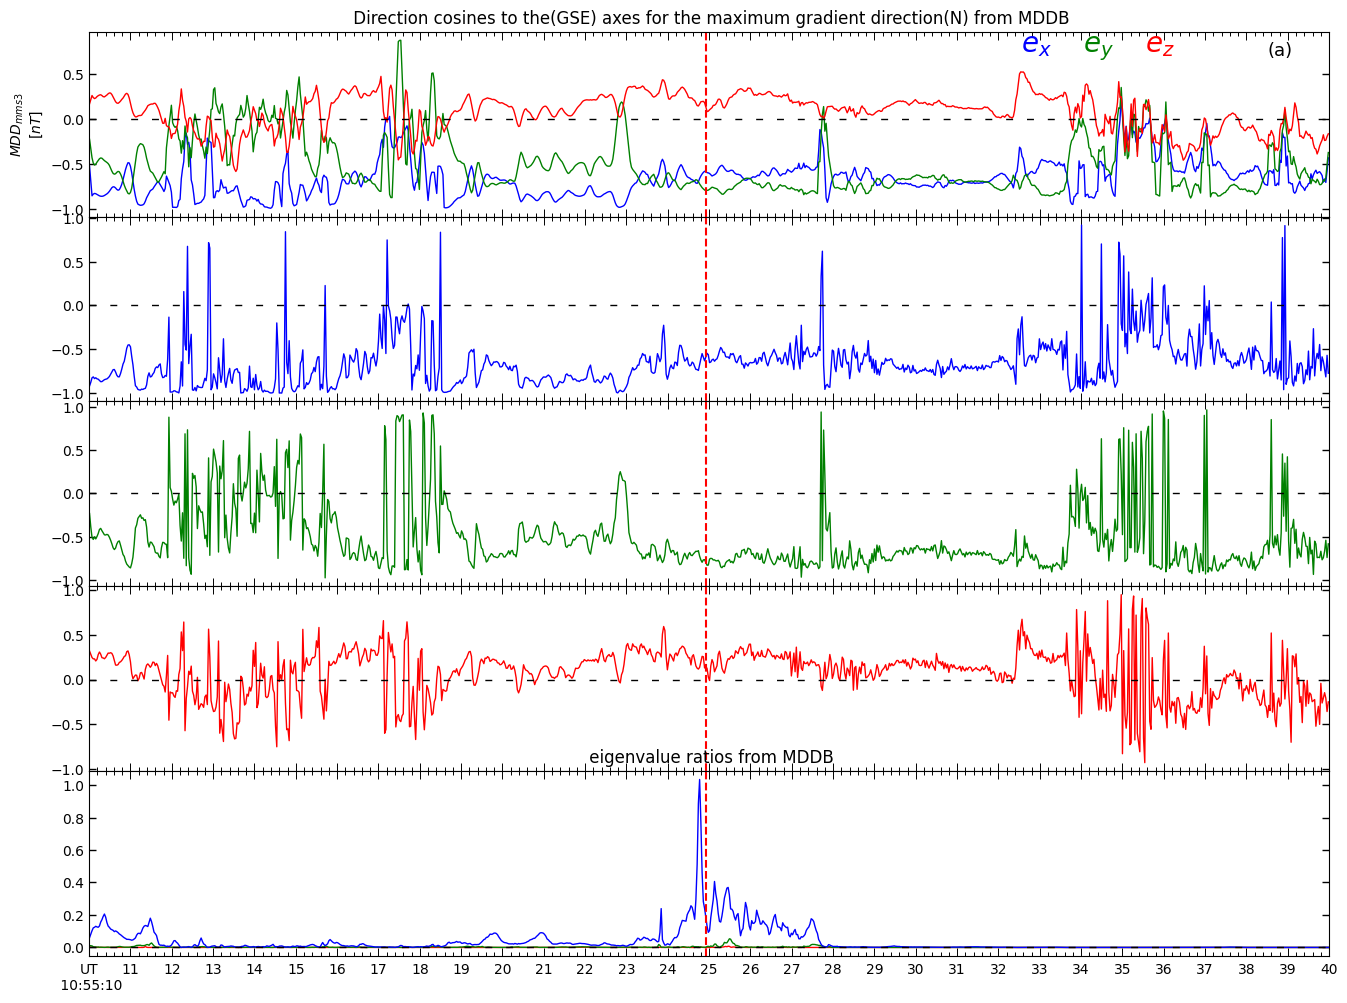

In [67]:
plt.style.use('default')

fig, axs = plt.subplots(5, 1, figsize=[16, 12], sharex=True, gridspec_kw={'hspace': 0})

# Plot data on the subplots
def convolve(data):
    return np.convolve(data, np.ones(5)/5, mode='same')
 
axs[0].plot(mdd(del3,del4)[5][1].time, xr.apply_ufunc(convolve,mdd(del3,del4)[5][1].isel(dim2=2,dim1=0)), c='b', lw=1,label='ex')
axs[0].plot(mdd(del3,del4)[5][1].time, xr.apply_ufunc(convolve,mdd(del3,del4)[5][1].isel(dim2=2,dim1=1)), c='g', lw=1,label='ey')
axs[0].plot(mdd(del3,del4)[5][1].time, xr.apply_ufunc(convolve,mdd(del3,del4)[5][1].isel(dim2=2,dim1=2)), c='r', lw=1,label='ez')

axs[0].text(0.95,0.95, '(a)', transform=axs[0].transAxes, fontsize=13, va='top')
axs[0].annotate(r'$\mathit{e_x}$', xy=(0.75, 0.9), xycoords='axes fraction', style='italic',
                fontsize=20, color='b', xytext=(1, -1), textcoords='offset points')  # Annotation for Bx in blue
axs[0].annotate(r'$\mathit{e_y}$', xy=(0.80, 0.9), xycoords='axes fraction', style='italic',
                fontsize=20, color='g', xytext=(1, -1), textcoords='offset points')  # Annotation for By in green
axs[0].annotate(r'$\mathit{e_z}$', xy=(0.85, 0.9), xycoords='axes fraction', style='italic',
                fontsize=20, color='r', xytext=(1, -1), textcoords='offset points')  # Annotation for Bz in red
axs[0].set_xlim(mdd(del3,del4)[5][1].time[0],mdd(del3,del4)[5][1].time[-1])
#axs[0].axvspan(timestamps_of_sign_changes.time[0].values,timestamps_of_sign_changes.time[1].values, color='yellow', alpha=0.5)  # highlight the region 
axs[0].set_ylabel(r'$\mathbf{\mathit{MDD_{mms3}}}$' + '\n' + r'$\mathit{[nT]}$', fontsize=10)
axs[0].set_title(' Direction cosines to the(GSE) axes for the maximum gradient direction(N) from MDDB', fontsize=12)

# normal mva_s
axs[1].plot(mdd(del3,del4)[5][1].time, mdd(del3,del4)[5][1].isel(dim2=2,dim1=0), c='b', lw=1,label='Bl')
axs[2].plot(mdd(del3,del4)[5][1].time, mdd(del3,del4)[5][1].isel(dim2=2,dim1=1), c='g', lw=1,label='Bm')
axs[3].plot(mdd(del3,del4)[5][1].time, mdd(del3,del4)[5][1].isel(dim2=2,dim1=2), c='r', lw=1,label='Bn')
axs[4].set_title(' eigenvalue ratios from MDDB', fontsize=12)
axs[4].plot(mdd(del3,del4)[5][0].time, mdd(del3,del4)[5][0].isel(dim1=0), c='r', lw=1)
axs[4].plot(mdd(del3,del4)[5][0].time, mdd(del3,del4)[5][0].isel(dim1=1), c='g', lw=1)
axs[4].plot(mdd(del3,del4)[5][0].time, mdd(del3,del4)[5][0].isel(dim1=2), c='b', lw=1)


for ax in axs:
    ax.tick_params(axis='x', which='major', labelsize=9,size=6,width=0.7,pad=5,direction='in',top=True,bottom=True)
    ax.tick_params(axis='x', which='minor', labelsize=9,size=3,width=0.7,pad=1,direction='in',top=True,bottom=True)
    ax.tick_params(axis='y', which='major', direction='in',left=True,right=True,
                 width=1, length=5,labelsize=10)  # Adjust width and length as needed
    ax.tick_params(axis='y', which='minor', direction='in',left=True,right=True, 
                   width=1, length=3,labelsize=10)
    #ax.tick_params(axis='both', which='major', direction='in',top=True,right=True,
    #             width=1, length=5,labelsize=10)  # Adjust width and length as needed
    #ax.tick_params(axis='both', which='minor', direction='in',top=True,right=True, 
    #               width=1, length=5,labelsize=10)
    # Set major x-axis ticks
    ax.set_xticks(xticks(del3,del4)[0])

    # Set minor x-axis ticks
    ax.set_xticks(xticks(del3,del4)[1], minor=True)

   # Format x-axis tick labels using the custom function
    ax.set_xticklabels(xticks(del3,del4)[2], rotation=0, fontsize=10)
    ax.axhline(y=0, c='k', ls=(0, (5, 10)), lw=1)
    ax.axvline(x=Bz[0].values,ls='--',c='r') #value obtained form below,change to MP crossing timestamp accordingly
    ax.axvline(x=np.datetime64('2015-10-16T13:05:43.5'),ls='-',c='y')
    ax.axvline(x=np.datetime64('2015-10-16T13:05:48'),ls='-',c='y')
plt.show()


In [68]:
del3,del4

(np.datetime64('2015-10-16T10:55:10.000000000'),
 np.datetime64('2015-10-16T10:55:40.000000000'))

In [69]:
v

<xarray.Dataset> Size: 112B
Dimensions:   (ratios: 2, values: 3, vec: 3, LMN: 3)
Dimensions without coordinates: ratios, values, vec, LMN
Data variables:
    eigenrat  (ratios) float64 16B 15.43 51.51
    eigenval  (values) float64 24B 618.8 40.09 0.7783
    eigenvec  (vec, LMN) float64 72B 0.1584 0.6995 0.6968 ... -0.03667 -0.1863

# Plasma Calculations

In [119]:
ni = mms3i_idataset.mms3_dis_numberdensity_brst.sel(time=slice(del3,del4))
ne = mms3i_edataset.mms3_des_numberdensity_brst.sel(time=slice(del3,del4))
vi = mms3i_idataset.mms3_dis_bulkv_gse_brst.sel(time=slice(del3,del4),v_dim=slice(0,3))
ve = mms3i_edataset.mms3_des_bulkv_gse_brst.sel(time=slice(del3,del4),v_dim=slice(0,3))

def alfven_speed(B,n_i):
    mu_0 = 4 * np.pi * 1e-7
    m = 1.67e-27
    alfven_speed = 1e-3 * np.abs(1e-9 * B)/np.sqrt(mu_0 * 1e6* n_i * m)
    return alfven_speed
def hall_current(i,e):
    q = 1e-19
    j_fpi = 1e6 * 1e9 * 1e3 * q * (i - e)
    return j_fpi
    

lmn_b = xr.apply_ufunc(np.matmul,
                       mms3i_brdataset.mms3_fgm_b_gse_brst_l2.sel(time=slice(del3,del4),v_dim=slice(0,3)),
                       v.eigenvec,
                       input_core_dims=[['time','v_dim'],['vec','LMN']],
                       output_core_dims=[['time','LMN']],
                       dask='allowed')
mag_lmn_b = np.sqrt((lmn_b**2).sum(dim='LMN'))

V_a = xr.apply_ufunc(alfven_speed,
            lmn_b.sel(LMN=0),
            mms3i_idataset.mms3_dis_numberdensity_brst.sel(time=slice(del3,del4)))
lmn_e = xr.apply_ufunc(np.matmul,
                       mms3i_Edataset.sel(time=slice(del3,del4),v_dim=slice(0,3)),
                       v.eigenvec,
                       input_core_dims=[['time','v_dim'],['vec','LMN']],
                       output_core_dims=[['time','LMN']],
                       dask='allowed')


j_fpi = xr.apply_ufunc(
    hall_current,
    ne*vi, ne*ve,
    input_core_dims=[['v_dim'], [ 'v_dim']],
    output_core_dims=[['v_dim']],
    vectorize=True)  # Set to True if your function can handle array inputs   

lmn_vi = xr.apply_ufunc(np.matmul,
                       mms3i_idataset.mms3_dis_bulkv_gse_brst.sel(time=slice(del3,del4),v_dim=slice(0,3)),
                       v.eigenvec,
                       input_core_dims=[['time','v_dim'],['vec','LMN']],
                       output_core_dims=[['time','LMN']],
                       dask='allowed')

lmn_ve = xr.apply_ufunc(np.dot,
               mms3i_edataset.mms3_des_bulkv_gse_brst.sel(time=slice(del3,del4),v_dim=slice(0,3)),
               v.eigenvec,
                input_core_dims = [['time','v_dim'],['vec']],
               output_core_dims=[['time']],
              vectorize=True)
lmn_vee =  xr.apply_ufunc(np.matmul,
                       mms3i_edataset.mms3_des_bulkv_gse_brst.sel(time=slice(del3,del4),v_dim=slice(0,3)),
                       v.eigenvec,
                       input_core_dims=[['time','v_dim'],['vec','LMN']],
                       output_core_dims=[['time','LMN']],
                       dask='allowed')
vib = -xr.cross(lmn_vi,lmn_b,dim='LMN')*1e-3
veb = -xr.cross(lmn_vee,lmn_b,dim='LMN')*1e-3

lmn_j = xr.apply_ufunc(np.matmul,
                       j_fpi,
                       v.eigenvec,
                       input_core_dims=[['time','v_dim'],['vec','LMN']],
                       output_core_dims=[['time','LMN']],
                       dask='allowed')

ln_b = lmn_b.sel(LMN=[0,2])/np.linalg.norm(lmn_b.sel(LMN=[0,2]),axis=1,keepdims=True)   # 2D B_{LN} unit vector
ln_j = xr.dot(ln_b,lmn_j.sel(LMN=[0,2]),dim=['LMN','LMN'])*ln_b   # 2D J_{LN} vector projected to 2D B_{LN} unit vector in 2D LN plane
par_ln_j = xr.dot(ln_j,ln_b, dim=['LMN','LMN'])  #  magnitude of 2D J_{LN} vector  parallel to B_{LN} 2D vector
perln_j = lmn_j.sel(LMN=[0,2]) - ln_j            # J_{LN} 2D vector perpendicular to B_{LN} 2D vector
per_ln_j = xr.apply_ufunc(np.linalg.norm,        # magnitude of J_{LN} 2D vector perpendicular to B_{LN} 2D unit vector
                          perln_j,
                          input_core_dims=[['LMN']],
                          output_core_dims=[[]],vectorize=True)

ln_e = xr.dot(ln_b,lmn_e.sel(LMN=[0,2]),dim=['LMN','LMN'])*ln_b   # 2D J_{LN} vector projected to 2D B_{LN} unit vector in 2D LN plane
par_ln_e = xr.dot(ln_e,ln_b, dim=['LMN','LMN'])  #  magnitude of 2D J_{LN} vector  parallel to B_{LN} 2D vector
perln_e = lmn_e.sel(LMN=[0,2]) - ln_e            # J_{LN} 2D vector perpendicular to B_{LN} 2D vector
per_ln_e = xr.apply_ufunc(np.linalg.norm,        # magnitude of J_{LN} 2D vector perpendicular to B_{LN} 2D unit vector
                          perln_e,
                          input_core_dims=[['LMN']],
                          output_core_dims=[[]],vectorize=True)

fgm_j = xr.apply_ufunc(np.matmul,
                       mdd(del3,del4)[6],
                       v.eigenvec,
                       input_core_dims=[['time','v_dim'],['vec','LMN']],
                       output_core_dims=[['time','LMN']],
                       dask='allowed')
mu_0 = 4*np.pi * 1e-7*1e3

In [71]:
Bl = find(lmn_b,LMN=0,d1=del3,d2=del4)[0].values
Bl

np.datetime64('2015-10-16T10:55:24.859474000')

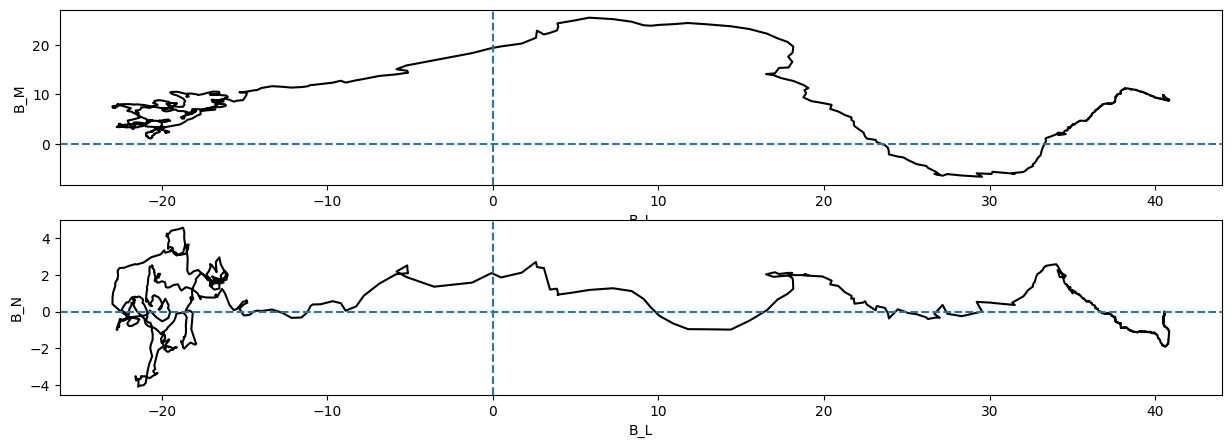

In [72]:
# Create subplots with 1 row and 2 columns
fig, ax = plt.subplots(2, 1, figsize=(15, 5), gridspec_kw={'wspace': 0.5})


# Plot for the first subplot (left column)
ax[0].plot( lmn_b.sel(LMN=0),lmn_b.sel(LMN=1),c='k')
ax[0].set_ylabel('B_M')
ax[0].set_xlabel('B_L')
ax[0].axhline(y=0,ls='--')
ax[0].axvline(x=0,ls='--')
# Plot for the second subplot (right column)
ax[1].plot(lmn_b.sel(LMN=0),lmn_b.sel(LMN=2),c='k')
ax[1].set_xlabel('B_L')  # Correctly set the x-axis label for the second plot
ax[1].set_ylabel('B_N')
ax[1].axhline(y=0,ls='--')
ax[1].axvline(x=0,ls='--')
# Adjust the layout and display the plots
plt.show()

In [120]:
del3,del4

('2015-10-16T10:55:19', '2015-10-16T10:55:34')

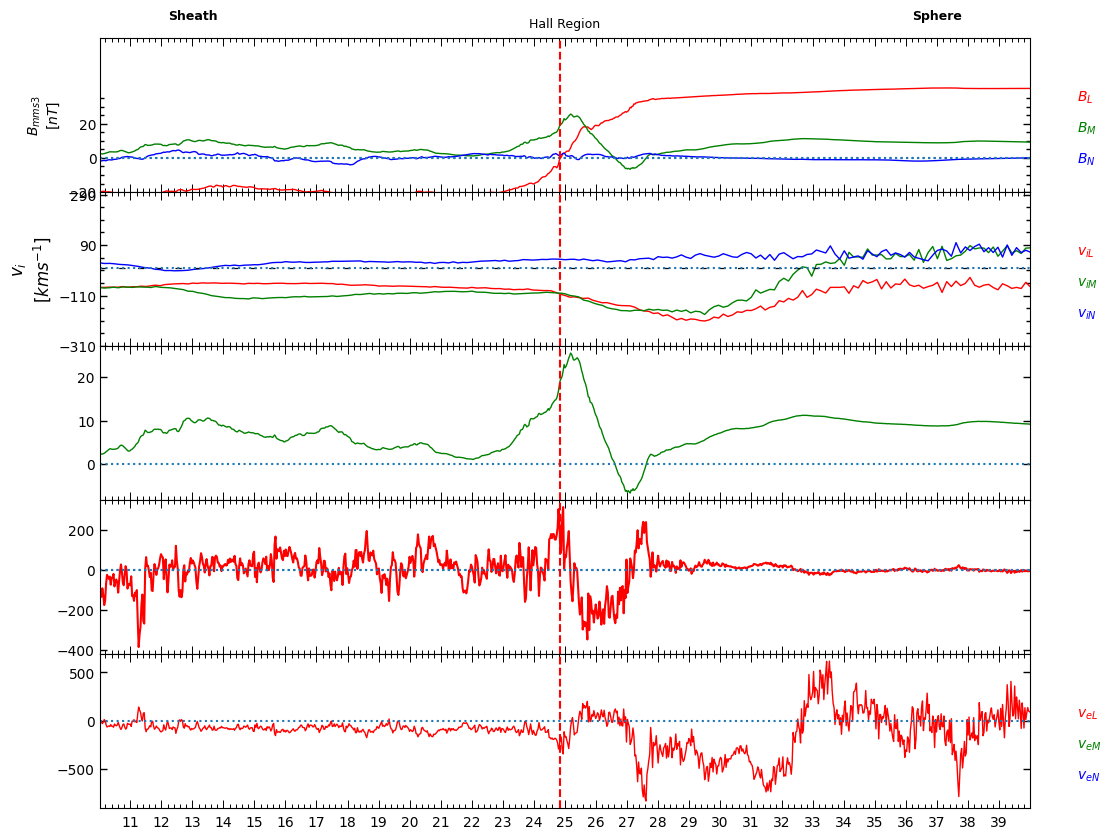

In [75]:
figb,axsb = plt.subplots(5,1, figsize=[12,10], sharex=True, gridspec_kw={'hspace': 0})

plasma_region = ['Sheath','Sphere']

if lmn_b.sel(LMN=0,time=slice(del3,del4)).values[0]>0:
    plasma_region = ['Sphere','Sheath']

axsb[0].annotate(f'{plasma_region[0]}', xy=(0.1, 1.1), xycoords='axes fraction',
                 xytext=(0, 5), textcoords='offset points',
                 ha='center', va='center', fontsize=9,fontweight='bold', color='black')
axsb[0].annotate('Hall Region', xy=(0.5, 1.05), xycoords='axes fraction',
                 xytext=(0, 5), textcoords='offset points',
                 ha='center', va='center', fontsize=9, color='black')
axsb[0].annotate(f'{plasma_region[1]}', xy=(0.9, 1.1), xycoords='axes fraction',
                 xytext=(0, 5), textcoords='offset points',
                 ha='center', va='center', fontsize=9, fontweight='bold',color='black')    

axsb[0].plot(lmn_b.time.sel(time=slice(del3,del4)),lmn_b.isel(LMN=0).sel(time=slice(del3,del4)),c='r',lw=1, label='E_L')
axsb[0].plot(lmn_b.time.sel(time=slice(del3,del4)),lmn_b.isel(LMN=1).sel(time=slice(del3,del4)),c='g',lw=1, label='E_M')
 -1), textcoords='offset points')  # Annotation for Bz in red
axsb[0].annotate(r'$\mathit{B_M}$', xy=(1.05, 0.4), xycoords='axes fraction', style='italic',
             fontsize=10, color='green', xytext=(1, -1), textcoords='offset points')  # Annotation for By in green
axsb[0].annotate(r'$\mathit{B_N}$', xy=(1.05, 0.2), xycoords='axes fraction', style='italic',
             fontsize=10, color='blue', xytext=(1, -1), textcoords='offset points')  # Annotation for Bx in blue
axsb[0].set_xlim(lmn_b.time.sel(time=slice(del3,del4))[0], lmn_b.time.sel(time=slice(del3,del4))[-1])
axsb[0].set_ylabel(r'$\mathbf{\mathit{B_{mms3}}}$' + '\n' + r'$\mathit{[nT]}$', fontsize=10)
axsb[0].set_yticks(np.arange(np.round(np.min(lmn_e.isel(LMN=0)),-1)-50, np.round(np.max(lmn_e.isel(LMN=0)),-1)+30, 20))
axsb[0].set_yticks(np.arange(np.round(np.min(lmn_e.isel(LMN=0)),-1)-50, np.round(np.max(lmn_e.isel(LMN=0)),-1), 5)+30, minor=True)
axsb[0].tick_params(axis='y', which='major', labelsize=7,size=6,pad=2,direction='in',left=True,right=True)
axsb[0].tick_params(axis='y', which='minor', labelsize=6,size=3,pad=1,direction='in',left=True,right=True)
axsb[0].set_ylim(np.round(np.min(lmn_b[:,0]),-1),np.round(np.max(lmn_b[:,0])+30,-1))


axsb[1].plot(lmn_vi.time.sel(time=slice(del3,del4)), 
           lmn_vi.isel(LMN=0).sel(time=slice(del3,del4)), c='r', lw=1,label='v_l')
axsb[1].plot(lmn_vi.time.sel(time=slice(del3,del4)), 
            lmn_vi.isel(LMN=1).sel(time=slice(del3,del4)), c='g', lw=1,label='v_m')
axsb[1].plot(lmn_vi.time.sel(time=slice(del3,del4)), 
            lmn_vi.isel(LMN=2).sel(time=slice(del3,del4)), c='b', lw=1,label='v_n')

axsb[1].axhline(y=0, c='k',  ls=(0, (5, 10)), lw=0.9)
axsb[1].set_ylabel(r'$\mathbf{\mathit{v_{i}}}$' + '\n' + r'$\mathit{[kms^{-1}]}$', fontsize=12)

axsb[1].annotate(r'$\mathit{v_{iL}}$', xy=(1.05, 0.6), xycoords='axes fraction', style='italic',
                fontsize=10, color='red', xytext=(1, -1), textcoords='offset points')  # Annotation for Bx in blue
axsb[1].annotate(r'$\mathit{v_{iM}}$', xy=(1.05, 0.4), xycoords='axes fraction', style='italic',
                fontsize=10, color='green', xytext=(1, -1), textcoords='offset points')  # Annotation for By in green
axsb[1].annotate(r'$\mathit{v_{iN}}$', xy=(1.05, 0.2), xycoords='axes fraction', style='italic',
                fontsize=10, color='blue', xytext=(1, -1), textcoords='offset points')  # Annotation for Bz in red
axsb[1].set_yticks(np.arange(np.round(np.min(lmn_vi), -1)-100, 
                            np.round(np.max(lmn_vi), -1)+400, 200))
axsb[1].set_yticks(np.arange(np.round(np.min(lmn_vi), -1)-100, 
                            np.round(np.max(lmn_vi), -1) + 200, 50), minor=True)
axsb[1].tick_params(axis='y', which='major', labelsize=7,size=6,pad=2,direction='in',left=True,right=True)
axsb[1].tick_params(axis='y', which='minor', labelsize=6,size=3,pad=1,direction='in',left=True,right=True)
axsb[1].set_ylim(np.round(np.min(lmn_vi), -1)-100,np.round(np.max(lmn_vi), -1)+200)

axsb[3].plot(lmn_j.time.sel(time=slice(del3,del4)),lmn_j.sel(LMN=0,time=slice(del3,del4)),c='r')
#axsb[3].plot(fgm_j.time.sel(time=slice(del3,del4)),fgm_j.sel(LMN=0,time=slice(del3,del4))/(mu_0),c='k')
axsb[3].axhline(y=0,ls=':')
axsb[4].plot(lmn_vee.time.sel(time=slice(del3,del4)), 
             lmn_vee.isel(LMN=0).sel(time=slice(del3,del4)), c='r', lw=1,label='v_l')
#axsb[3].plot(lmn_vee.time.sel(time=slice(del3,del4)), 
#            lmn_vee.isel(LMN=1).sel(time=slice(del3,del4)), c='g', lw=1,label='v_m')
#axsb[3].plot(lmn_vee.time.sel(time=slice(del3,del4)), 
#            lmn_vee.isel(LMN=2).sel(time=slice(del3,del4)), c='b', lw=1,label='v_n')
axsb[4].annotate(r'$\mathit{v_{eL}}$', xy=(1.05, 0.6), xycoords='axes fraction', style='italic',
                fontsize=10, color='red', xytext=(1, -1), textcoords='offset points')  # Annotation for Bx in blue
axsb[4].annotate(r'$\mathit{v_{eM}}$', xy=(1.05, 0.4), xycoords='axes fraction', style='italic',
                fontsize=10, color='green', xytext=(1, -1), textcoords='offset points')  # Annotation for By in green
axsb[4].annotate(r'$\mathit{v_{eN}}$', xy=(1.05, 0.2), xycoords='axes fraction', style='italic',
                fontsize=10, color='blue', xytext=(1, -1), textcoords='offset points')  # Annotation for Bz in red

axsb[2].plot(lmn_b.time.sel(time=slice(del3,del4)),lmn_b.isel(LMN=1).sel(time=slice(del3,del4)),c='g',lw=1, label='B_M')


# Custom formatting function
for ax in axsb:
    ax.tick_params(axis='x', which='major', labelsize=9,size=6,width=0.7,pad=5,direction='in',top=True,bottom=True)
    ax.tick_params(axis='x', which='minor', labelsize=9,size=3,width=0.7,pad=1,direction='in',top=True,bottom=True)
    ax.tick_params(axis='y', which='major', direction='in',left=True,right=True,
                 width=1, length=5,labelsize=10)  # Adjust width and length as needed
    ax.tick_params(axis='y', which='minor', direction='in',left=True,right=True, 
                   width=1, length=3,labelsize=10)
   
    # Set major x-axis ticks
    ax.set_xticks(xticks(del3,del4)[0])

    # Set minor x-axis ticks
    ax.set_xticks(xticks(del3,del4)[1], minor=True)

   # Format x-axis tick labels using the custom function
    ax.set_xticklabels(xticks(del3,del4)[2], rotation=0, fontsize=10)
    ax.axhline(y=0,ls=':')
    ax.axvline(x=Bl,ls='--',c='r')
    ax.set_xlim(lmn_b.time.sel(time=del3, method="nearest"), lmn_b.time.sel(time=del4,method='nearest'))

In [76]:
del3,del4,Bl

(np.datetime64('2015-10-16T10:55:10.000000000'),
 np.datetime64('2015-10-16T10:55:40.000000000'),
 np.datetime64('2015-10-16T10:55:24.859474000'))

In [77]:
del3 ='2015-10-16T10:55:19'
del4 ='2015-10-16T10:55:34'

In [78]:
def GF(BM_SH, BM_SP):
    # Calculate the net guide field strength and direction
    if BM_SH > 0 and BM_SP > 0:
        # Both sides have the same direction
        B_g = (abs(BM_SH) + abs(BM_SP)) / 2
    elif BM_SH < 0 and BM_SP < 0:
        # Both sides have the same negative direction
        B_g = -(abs(BM_SH) + abs(BM_SP)) / 2
    else:
        B_g = BM_SH + BM_SP
    return B_g


def B_G(t1,t2):
    if lmn_b.sel(LMN=0,time=slice(del3,Bl)).values[0]>0: # outbound crossing spheric to sheath
        print('MMS satellite crosses the reconnection region from the magnetosphere to the magnetosheath')
        b_sp = lmn_b.sel(time=slice(del3,t1)).mean(dim='time').values
        b_sh = lmn_b.sel(time=slice(t2,del4)).mean(dim='time').values
        
        BL_SP = lmn_b.sel(LMN=0,time=slice(del3,t1)).mean(dim='time').values
        BL_SH = lmn_b.sel(LMN=0,time=slice(t2,del4)).mean(dim='time').values
        BM_SP = lmn_b.sel(LMN=1,time=slice(del3,t1)).mean(dim='time').values
        BM_SH = lmn_b.sel(LMN=1,time=slice(t2,del4)).mean(dim='time').values
        BN_SP = lmn_b.sel(LMN=2,time=slice(del3,t1)).mean(dim='time').values
        BN_SH = lmn_b.sel(LMN=2,time=slice(t2,del4)).mean(dim='time').values

        N_SP = mms3i_idataset.mms3_dis_numberdensity_brst.sel(time=slice(del3,t1)).mean(dim='time').values
        N_SH = mms3i_idataset.mms3_dis_numberdensity_brst.sel(time=slice(t2,del4)).mean(dim='time').values 
        
        BM_G = lmn_b.sel(LMN=1,time=slice(t2,del4)).mean(dim='time').values 
        alf_sh = V_a.sel(time=slice(t2,del4)).mean().values
        vl_shmax = lmn_vi.sel(time=slice(t2,del4)).max()
    else: # inbound crossing sheath to spheric
        print('MMS satellite crosses the reconnection region from the magnetosheath to the magnetosphere')
        b_sp = lmn_b.sel(time=slice(t2,del4)).mean(dim='time').values
        b_sh = lmn_b.sel(time=slice(del3,t1)).mean(dim='time').values
        
        BL_SP = lmn_b.sel(LMN=0,time=slice(t2,del4)).mean(dim='time').values
       
        BL_SH = lmn_b.sel(LMN=0,time=slice(del3,t1)).mean(dim='time').values
        BM_SP = lmn_b.sel(LMN=1,time=slice(t2,del4)).mean(dim='time').values
        BM_SH = lmn_b.sel(LMN=1,time=slice(del3,t1)).mean(dim='time').values
        BN_SP = lmn_b.sel(LMN=2,time=slice(t2,del4)).mean(dim='time').values
        BN_SH = lmn_b.sel(LMN=2,time=slice(del3,t1)).mean(dim='time').values
        
        BM_G = lmn_b.sel(LMN=1,time=slice(del3,t1)).mean(dim='time').values 
        
        N_SP = mms3i_idataset.mms3_dis_numberdensity_brst.sel(time=slice(t2,del4)).mean(dim='time').values + \
        mms3i_edataset.mms3_des_numberdensity_brst.sel(time=slice(t2,del4)).mean(dim='time').values
        N_SH = mms3i_idataset.mms3_dis_numberdensity_brst.sel(time=slice(del3,t1)).mean(dim='time').values + \
        mms3i_edataset.mms3_des_numberdensity_brst.sel(time=slice(del3,t1)).mean(dim='time').values
    
        alf_sh = V_a.sel(time=slice(del3,t1)).mean().values
        vl_shmax = lmn_vi.sel(time=slice(del3,t1)).min()
        
    b_sh_mag = np.linalg.norm(b_sh)
    b_sp_mag = np.linalg.norm(b_sp)
    cos_theta = np.dot(b_sp,b_sh)/(b_sh_mag*b_sp_mag)
    theta_shear = np.degrees(np.arccos(cos_theta))
    
    B_SP = np.array([BL_SP, BM_SP])
    B_SH = np.array([BL_SH, BM_SH])
    B_SP_mag = np.linalg.norm(B_SP)
    B_SH_mag = np.linalg.norm(B_SH)
    B_G = GF(BM_SH,BM_SP)
    cos_theta = np.dot(B_SP, B_SH) / (B_SP_mag * B_SH_mag)
    
    theta_shear = np.degrees(np.arccos(cos_theta))

    #B_g = B_SP_mag *np.sin(np.arccos(cos_theta))
    B_M_min = lmn_b.sel(LMN=1,time=slice(t1,t2)).min(dim='time').values-B_G
    B_M_max = lmn_b.sel(LMN=1,time=slice(t1,t2)).max(dim='time').values-B_G
    lmn_b.sel(time=slice(t1,t2)).isel
    return [B_G/BL_SP,B_SP_mag/B_SH_mag,N_SH/N_SP,B_G,theta_shear,B_M_min,B_M_max,BL_SP,BM_SP,BL_SH,BM_SH,BN_SP,BN_SH,N_SP,N_SH,alf_sh,vl_shmax,B_SP_mag,B_SH_mag]
    
# Assuming the function B_G returns 6 values
t1 = np.datetime64(del3) + np.timedelta64(4400, 'ms')
t2 = np.datetime64(del4) - np.timedelta64(4000, 'ms')
new_values = B_G(t1, t2)

rounded_values = np.round(new_values, 2)
new_columns = ['$\\frac{B_{G}}{B_{L-SP}}$', '$\\frac{B_{SP}}{B_{SH}}$', '$\\frac{N_{SH}}{N_{SP}}$','B_g', 'shear', '$B_M_min$','$B_M_max$','$B_{LSP}$',
          '$B_{MSP}$','$B_{LSH}$','$B_{MSH}$','$B_{NSP}$','$B_{NSH}$','$N_{SP}$','$N_{SH}$','$alf_sh$','Vl_shmax','$B_SP$','$B_SH$']

# Create DataFrames for each set of values
df = pd.DataFrame([rounded_values], columns=new_columns)
df

MMS satellite crosses the reconnection region from the magnetosheath to the magnetosphere


,$\frac{B_{G}}{B_{L-SP}}$,$\frac{B_{SP}}{B_{SH}}$,$\frac{N_{SH}}{N_{SP}}$,B_g,shear,$B_M_min$,$B_M_max$,$B_{LSP}$,$B_{MSP}$,$B_{LSH}$,$B_{MSH}$,$B_{NSP}$,$B_{NSH}$,$N_{SP}$,$N_{SH}$,$alf_sh$,Vl_shmax,$B_SP$,$B_SH$
0,0.17,1.89,33.89,6.4,157.34,-13.08,19.16,38.29,9.75,-20.72,3.05,-0.73,0.79,1.14,38.59,101.94,-104.19,39.51,20.95


09-Jul-25 15:57:27: D:\hallsim\Lib\site-packages\xarray\core\dataarray.py:6309: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead of da.argmin() or da.argmax().
  result = self.variable.argmax(dim, axis, keep_attrs, skipna)



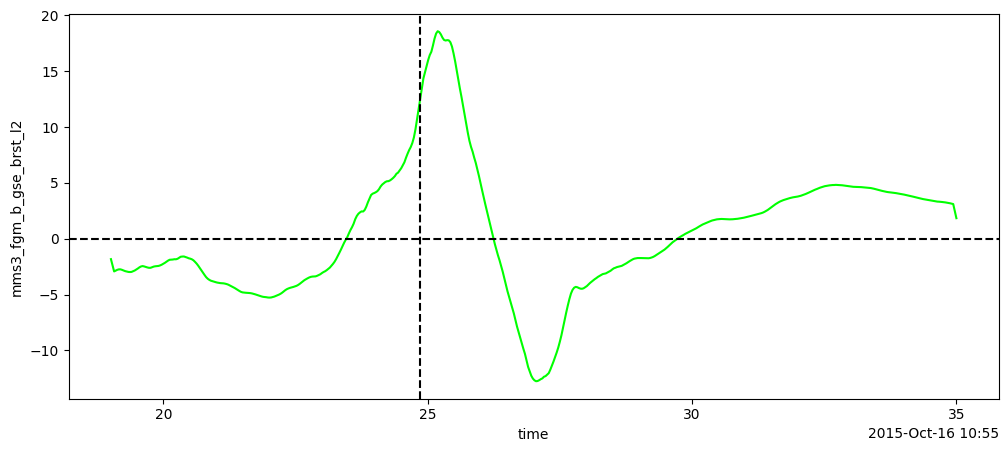

In [79]:
B_hm = lmn_b.sel(time=slice(del3,del4))-df['B_g'].values
B_hm.sel(LMN=1,time=slice(t1,t2)).argmax().values
th_max = B_hm.time.sel(time=slice(t1,t2)).isel(time=np.argmax(B_hm.sel(LMN=1,time=slice(t1,t2)).values)).values
th_min = B_hm.time.sel(time=slice(t1,t2)).isel(time=np.argmin(B_hm.sel(LMN=1,time=slice(t1,t2)).values)).values
#th_0 = find(B_hm,LMN=1,d1=th_min,d2=th_max)[0].values
#th_2 = find(B_hm,LMN=1,d1=th_max,d2=th_min)[0].values
#t_3 = find(B_hm,LMN=1,d1=t_min,d2=t2)[0].values
th_min,th_max
def convolve(data,window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')
xr.apply_ufunc(convolve, B_hm.sel(LMN=1), kwargs={'window_size': 5}).plot(figsize=(12,5), color=(0, 1, 0))
plt.axhline(y=0, ls='--',c='k')
plt.axvline(x=Bl, ls='--',c='k')
plt.savefig(os.path.join(output_folder, f"{taistarttime}_l.png"), dpi=1200, format='png', bbox_inches='tight')

In [121]:
del3,del4,t1,t2

('2015-10-16T10:55:19',
 '2015-10-16T10:55:34',
 np.datetime64('2015-10-16T10:55:23.400'),
 np.datetime64('2015-10-16T10:55:30.000'))

In [123]:
th_max = B_hm.time.sel(time=slice(t1,t2)).isel(time=np.argmax(B_hm.sel(LMN=1,time=slice(t1,t2)).values)).values
th_min = B_hm.time.sel(time=slice(t1,t2)).isel(time=np.argmin(B_hm.sel(LMN=1,time=slice(t1,t2)).values)).values
th_0 = find(B_hm,LMN=1,d1=th_max,d2=th_min)[0].values
#th_2 = find(B_hm,LMN=1,d1=th_max,d2=th_min)[0].values
#t_3 = find(B_hm,LMN=1,d1=t_min,d2=t2)[0].values
th_min,th_max,th_0

(np.datetime64('2015-10-16T10:55:27.109474000'),
 np.datetime64('2015-10-16T10:55:25.189474000'),
 np.datetime64('2015-10-16T10:55:26.239474000'))

09-Jul-25 17:25:47: <>:9: SyntaxWarning: invalid escape sequence '\m'

09-Jul-25 17:25:47: <>:31: SyntaxWarning: invalid escape sequence '\m'

09-Jul-25 17:25:47: <>:32: SyntaxWarning: invalid escape sequence '\m'

09-Jul-25 17:25:47: <>:9: SyntaxWarning: invalid escape sequence '\m'

09-Jul-25 17:25:47: <>:31: SyntaxWarning: invalid escape sequence '\m'

09-Jul-25 17:25:47: <>:32: SyntaxWarning: invalid escape sequence '\m'

09-Jul-25 17:25:47: C:\Users\DIPS\AppData\Local\Temp\ipykernel_2368\3463386363.py:9: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set_ylabel('$\mathit{B_M}$(nT)', fontsize=13)

09-Jul-25 17:25:47: C:\Users\DIPS\AppData\Local\Temp\ipykernel_2368\3463386363.py:31: SyntaxWarning: invalid escape sequence '\m'
  ax[1].set_xlabel('$\mathit{B_L}$(nT)', fontsize=13)

09-Jul-25 17:25:47: C:\Users\DIPS\AppData\Local\Temp\ipykernel_2368\3463386363.py:32: SyntaxWarning: invalid escape sequence '\m'
  ax[1].set_ylabel('$\mathit{B_N}$(nT)', fontsize=13)



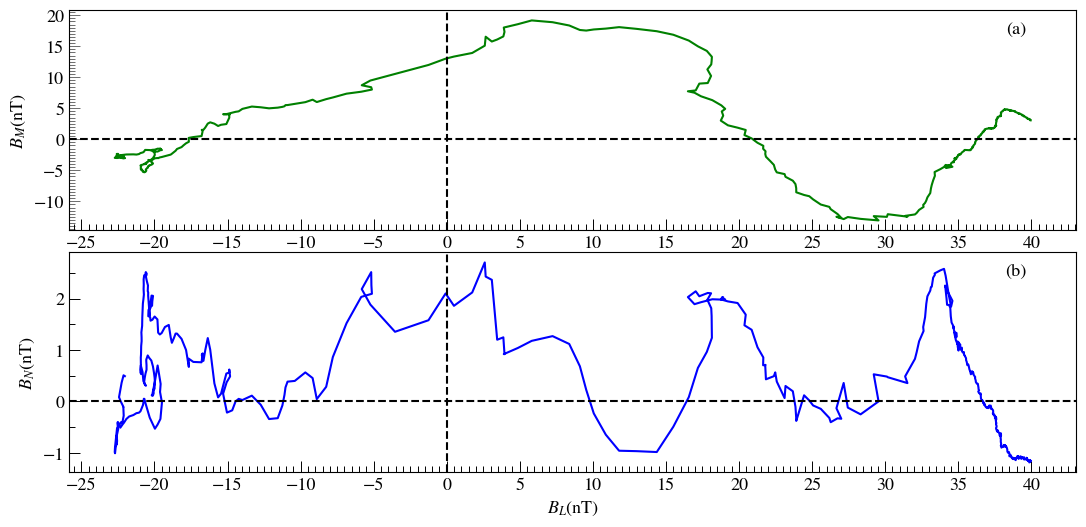

In [124]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os  # Ensure you have os for file saving

fig, ax = plt.subplots(2, 1, figsize=(13, 6), gridspec_kw={'hspace': 0.1})  # Increased spacing

# First subplot (top)
ax[0].plot(lmn_b.sel(LMN=0), lmn_b.sel(LMN=1, time=slice(del3, del4)) - df['B_g'].values, c='g')
ax[0].set_ylabel('$\mathit{B_M}$(nT)', fontsize=13)
ax[0].axhline(y=0, ls='--', c="k")
ax[0].axvline(x=0, ls='--', c="k")

# Label "(a)" in top-right corner
ax[0].text(0.95, 0.95, "(a)", transform=ax[0].transAxes, fontsize=13,  ha="right", va="top")

# Set tick mark font size and style for x and y axes
ax[0].tick_params(axis="x", which="major", direction="in", length=8, width=0.7, labelsize=13)
ax[0].tick_params(axis="x", which="minor", direction="in", length=4, width=0.7)

ax[0].tick_params(axis="y", which="major", direction="in", length=8, width=0.4, labelsize=13)
ax[0].tick_params(axis="y", which="minor", direction="in", length=4, width=0.4)

# Set tick intervals
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(5))
ax[0].xaxis.set_minor_locator(ticker.AutoMinorLocator(10))
ax[0].yaxis.set_major_locator(ticker.MultipleLocator(5))
ax[0].yaxis.set_minor_locator(ticker.AutoMinorLocator(10))

# Second subplot (bottom)
ax[1].plot(lmn_b.sel(LMN=0), lmn_b.sel(LMN=2), c='b')
ax[1].set_xlabel('$\mathit{B_L}$(nT)', fontsize=13)
ax[1].set_ylabel('$\mathit{B_N}$(nT)', fontsize=13)
ax[1].axhline(y=0, ls='--', c="k")
ax[1].axvline(x=0, ls='--', c="k")

# Label "(b)" in top-right corner
ax[1].text(0.95, 0.95, "(b)", transform=ax[1].transAxes, fontsize=13,  ha="right", va="top")

# Set tick mark font size and style for x and y axes
ax[1].tick_params(axis="x", which="major", direction="in", length=8, width=0.7, labelsize=13)
ax[1].tick_params(axis="x", which="minor", direction="in", length=4, width=0.7)

ax[1].tick_params(axis="y", which="major", direction="in", length=8, width=0.7, labelsize=13)
ax[1].tick_params(axis="y", which="minor", direction="in", length=4, width=0.7)

# Set tick intervals
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(5))
ax[1].xaxis.set_minor_locator(ticker.AutoMinorLocator(10))
ax[1].yaxis.set_major_locator(ticker.MultipleLocator(1))
ax[1].yaxis.set_minor_locator(ticker.AutoMinorLocator(2))

# Fine-tune layout and save the figure
plt.savefig(os.path.join(output_folder, f"{taistarttime}_m.png"), dpi=1200, format='png', bbox_inches='tight')
plt.show()


In [125]:
hall = lmn_b.sel(LMN=1, time=slice(del3, del4)) - df['B_g'].values

In [126]:
hall.max().values

array(19.16014103)

In [127]:
hall.min().values

array(-13.08279043)

In [128]:
B = int(np.floor(np.log10(abs(np.max(lmn_b[:,0])))))
N = int(np.floor(np.log10(abs(np.max(mms3i_idataset.mms3_dis_numberdensity_brst.sel(time=slice(del3,del4)))))))
VI = int(np.floor(np.log10(abs(np.min(lmn_vi[:,0])))))
VA = int(np.floor(np.log10(abs(np.max(V_a)))))-1
J = int(np.floor(np.log10(abs(np.max(lmn_j.sel(LMN=0))))))
JP = int(np.floor(np.log10(abs(np.max(np.max(par_ln_j))))))
VE = int(np.floor(np.log10(abs(np.max(lmn_ve)))))
E = int(np.floor(np.log10(abs(np.max(lmn_e)))))
TI = int(np.floor(np.log10(abs(np.max(mms3i_idataset.mms3_dis_temppara_brst.sel(time=slice(del3,del4)))))))
TE = int(np.floor(np.log10(abs(np.max(mms3i_idataset.mms3_dis_temppara_brst.sel(time=slice(del3,del4)))))))

In [129]:
bl = lmn_b.sel(LMN=0, time=slice(del3,del4))  # B_L
bm = lmn_b.sel(LMN=1, time=slice(del3,del4)) - df['B_g'].values  # B_M adjusted
bn = lmn_b.sel(LMN=2, time=slice(del3,del4))  # B_N
B_magnitude = np.sqrt(bl**2 + bm**2 + bn**2)

In [130]:
B_magnitude.min().values

array(9.73674272)

In [131]:
bl.max().values,bl.min().values

(array(39.95634305), array(-22.71724136))

In [132]:
bm.min().values,bm.max().values

(array(-13.08279043), array(19.16014103))

09-Jul-25 17:27:42: D:\hallsim\Lib\site-packages\matplotlib\cbook.py:1719: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return math.isfinite(val)

09-Jul-25 17:27:44: C:\Users\DIPS\AppData\Local\Temp\ipykernel_2368\1025298646.py:168: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1)  # Adjust padding



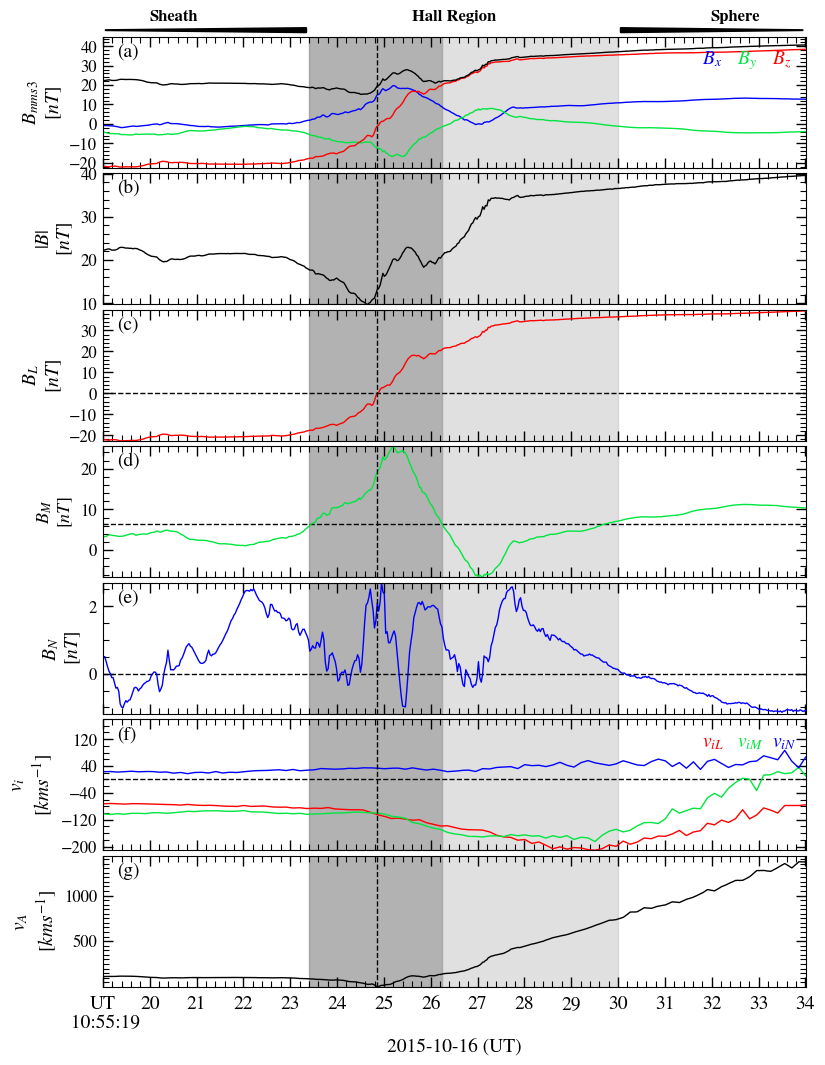

In [133]:
fig, axs = plt.subplots(7, 1, figsize=[8.27, 10], sharex=True, gridspec_kw={'hspace': 0.04})
   
axs[0].text(0.02,0.95, '(a)', transform=axs[0].transAxes, fontsize=14, va='top') 
axs[1].text(0.02,0.95, '(b)', transform=axs[1].transAxes, fontsize=14, va='top') 
axs[2].text(0.02,0.95, '(c)', transform=axs[2].transAxes, fontsize=14, va='top') 
axs[3].text(0.02,0.95, '(d)', transform=axs[3].transAxes, fontsize=14, va='top') 
axs[4].text(0.02,0.95, '(e)', transform=axs[4].transAxes, fontsize=14, va='top') 
axs[5].text(0.02,0.95, '(f)', transform=axs[5].transAxes, fontsize=14, va='top') 
axs[6].text(0.02,0.95, '(g)', transform=axs[6].transAxes, fontsize=14, va='top') 
#axs[7].text(0.95,0.95, '(h)', transform=axs[7].transAxes, fontsize=13, va='top') 

plasma_region = ['Sheath','Sphere']

if lmn_b.sel(LMN=0,time=slice(del3,del4)).values[0]>0:
    plasma_region = ['Sphere','Sheath']

axs[0].annotate(f'{plasma_region[0]}', xy=(0.1, 1.1), xycoords='axes fraction',
                 xytext=(0, 5), textcoords='offset points',
                 ha='center', va='center', fontsize=12,fontweight='bold', color='black')
axs[0].annotate('Hall Region', xy=(0.5, 1.1), xycoords='axes fraction',
                 xytext=(0, 5), textcoords='offset points',
                 ha='center', va='center', fontsize=12, fontweight='bold',color='black')
axs[0].annotate(f'{plasma_region[1]}', xy=(0.9, 1.1), xycoords='axes fraction',
                 xytext=(0, 5), textcoords='offset points',
                 ha='center', va='center', fontsize=12, fontweight='bold',color='black')  

axs[0].plot(mms3i_bdataset.time.sel(time=slice(del3,del4)), mms3i_bdataset.mms3_fgm_b_gse_brst_l2.sel(time=slice(del3,del4),v_dim=0), c='b', lw=1,label='Bx')
axs[0].plot(mms3i_bdataset.time.sel(time=slice(del3,del4)), mms3i_bdataset.mms3_fgm_b_gse_brst_l2.sel(time=slice(del3,del4),v_dim=1), c=((0/255, 230/255, 64/255)), lw=1,label='By')
axs[0].plot(mms3i_bdataset.time.sel(time=slice(del3,del4)), mms3i_bdataset.mms3_fgm_b_gse_brst_l2.sel(time=slice(del3,del4),v_dim=2), c='r', lw=1,label='Bz')
axs[0].plot(mms3i_bdataset.time.sel(time=slice(del3,del4)), mms3i_bdataset.mms3_fgm_b_gse_brst_l2.sel(time=slice(del3,del4),v_dim=3), c='k', lw=1,label='Bz')
axs[0].annotate(r'$\mathit{B_x}$', xy=(0.85, 0.8), xycoords='axes fraction', style='italic',
                fontsize=14, color='b', xytext=(1, -1), textcoords='offset points')  # Annotation for Bx in blue
axs[0].annotate(r'$\mathit{B_y}$', xy=(0.90, 0.8), xycoords='axes fraction', style='italic',
                fontsize=14, color=((0/255, 230/255, 64/255)), xytext=(1, -1), textcoords='offset points')  # Annotation for By in green
axs[0].annotate(r'$\mathit{B_z}$', xy=(0.95, 0.8), xycoords='axes fraction', style='italic',
                fontsize=14, color='r', xytext=(1, -1), textcoords='offset points')  # Annotation for Bz in red
axs[0].set_ylabel(r'$\mathbf{\mathit{B_{mms3}}}$' + '\n' + r'$\mathit{[nT]}$', fontsize=14)
axs[1].axhline(y=0,ls='--',lw=1,c='k')
axs[2].axhline(y=0,ls='--',lw=1,c='k')
axs[3].axhline(y=df['B_g'].values,ls='--',lw=1,c='k')
axs[4].axhline(y=0,ls='--',lw=1,c='k')
axs[5].axhline(y=0,ls='--',lw=1,c='k')

axs[1].plot(lmn_b.time.sel(time=slice(del3,del4)),B_magnitude,lw=1,c='k')
axs[2].plot(lmn_b.time.sel(time=slice(del3,del4)),lmn_b.sel(LMN=0,time=slice(del3,del4)),lw=1,c='r')
axs[3].plot(lmn_b.time.sel(time=slice(del3,del4)),lmn_b.sel(LMN=1,time=slice(del3,del4)),lw=1,c=(0/255, 230/255, 64/255)) 
#axs[3].axhline(y=df['B_g'].values, ls='--',c=(0/255, 230/255, 64/255), lw=1)
axs[4].plot(lmn_b.time.sel(time=slice(del3,del4)),lmn_b.sel(LMN=2,time=slice(del3,del4)),lw=1,c='b')

axs[0].set_ylabel(r'$\mathbf{\mathit{B_{mms3}}}$' + '\n' + r'$\mathit{[nT]}$', fontsize=14)
axs[0].set_yticks(np.arange(np.round(np.min(lmn_b.sel(LMN=0)),-B)-10**B, np.round(np.max(lmn_b[:,0]),-B)+10**B, 10*B))
axs[0].set_yticks(np.arange(np.round(np.min(lmn_b.sel(LMN=0)),-B)-10**B, np.round(np.max(lmn_b[:,0]),-B)+10**B, 2*B), minor=True)
axs[0].tick_params(axis='y', which='major', labelsize=12,size=6,pad=2,direction='in',left=True,right=True)
axs[0].tick_params(axis='y', which='minor', labelsize=10,size=3,pad=1,direction='in',left=True,right=True)
axs[0].set_ylim(np.min(lmn_b.sel(LMN=0,time=slice(del3,del4))),np.max(lmn_b.sel(LMN=0,time=slice(del3,del4)))+5)

axs[1].set_yticks(np.arange(np.round(np.min(B_magnitude),-B)-10**B, np.round(np.max(B_magnitude),-B)+10**B, 10*B))
axs[1].set_yticks(np.arange(np.round(np.min(B_magnitude),-B)-10**B, np.round(np.max(B_magnitude),-B)+10**B, 2*B), minor=True)
axs[1].tick_params(axis='y', which='major', labelsize=12,size=6,pad=2,direction='in',left=True,right=True)
axs[1].tick_params(axis='y', which='minor', labelsize=10,size=3,pad=1,direction='in',left=True,right=True)
axs[1].set_ylim(np.min(B_magnitude),np.max(B_magnitude))
axs[1].set_ylabel(r'$\mathbf{\mathit{|B|}}$' + '\n' + r'$\mathit{[nT]}$', fontsize=14) 

axs[2].set_yticks(np.arange(np.round(np.min(lmn_b.sel(LMN=0)),-B)-10**B, np.round(np.max(lmn_b[:,0]),-B)+10**B, 10*B))
axs[2].set_yticks(np.arange(np.round(np.min(lmn_b.sel(LMN=0)),-B)-10**B, np.round(np.max(lmn_b[:,0]),-B)+10**B, 2*B), minor=True)
axs[2].tick_params(axis='y', which='major', labelsize=12,size=6,pad=2,direction='in',left=True,right=True)
axs[2].tick_params(axis='y', which='minor', labelsize=10,size=3,pad=1,direction='in',left=True,right=True)
axs[2].set_ylim(np.min(lmn_b.sel(LMN=0)),np.max(lmn_b.sel(LMN=0)))
axs[2].set_ylabel(r'$\mathbf{\mathit{B_{L}}}$' + '\n' + r'$\mathit{[nT]}$', fontsize=14)          
axs[3].set_yticks(np.arange(np.round(np.min(lmn_b.sel(LMN=1)),-B)-10**B, np.round(np.max(lmn_b[:,1]),-B)+10**B, 10*B))
axs[3].set_yticks(np.arange(np.round(np.min(lmn_b.sel(LMN=1)),-B)-10**B, np.round(np.max(lmn_b[:,1]),-B)+10**B, 2*B), minor=True)
axs[3].tick_params(axis='y', which='major', labelsize=12,size=6,pad=2,direction='in',left=True,right=True)
axs[3].tick_params(axis='y', which='minor', labelsize=10,size=3,pad=1,direction='in',left=True,right=True)
axs[3].set_ylim(np.min(lmn_b.sel(LMN=1)),np.max(lmn_b.sel(LMN=1)))
axs[3].set_ylabel(r'$\mathbf{\mathit{B_{M}}}$' + '\n' + r'$\mathit{[nT]}$', fontsize=13)
from matplotlib.ticker import AutoMinorLocator
b_n = lmn_b.sel(LMN=2, time=slice(t1, t2))
bmin = np.floor(b_n.min().item())
bmax = np.ceil(b_n.max().item())  
plt.yticks(np.arange(bmin, bmax + B, B))
axs[4].set_ylim(np.min(lmn_b.sel(LMN=2)),np.max(lmn_b.sel(LMN=2)))
axs[4].yaxis.set_minor_locator(AutoMinorLocator())
axs[4].set_ylabel(r'$\mathbf{\mathit{B_{N}}}$' + '\n' + r'$\mathit{[nT]}$', fontsize=14)
axs[5].set_ylim(np.min(lmn_vi.sel(LMN=0,time=slice(del3,del4))),np.max(lmn_vi.sel(LMN=2,time=slice(del3,del4))))

# Plot data on the subplots
axs[5].plot(lmn_vi.time.sel(time=slice(del3,del4)), 
           lmn_vi.sel(LMN=0,time=slice(del3,del4)), c='r', lw=1,label='v_l')
axs[5].plot(lmn_vi.time.sel(time=slice(del3,del4)),lmn_vi.sel(LMN=1,time=slice(del3,del4)), c=(0/255, 230/255, 64/255), lw=1,label='v_m')
axs[5].plot(lmn_vi.time.sel(time=slice(del3,del4)), 
            lmn_vi.sel(LMN=2,time=slice(del3,del4)), c='b', lw=1,label='v_n')
axs[5].set_ylabel(r'$\mathbf{\mathit{v_{i}}}$' + '\n' + r'$\mathit{[kms^{-1}]}$', fontsize=14)
axs[5].annotate(r'$\mathit{v_{iL}}$', xy=(0.85, 0.8), xycoords='axes fraction', style='italic',
                fontsize=14, color='r', xytext=(1, -1), textcoords='offset points')  # Annotation for Bx in blue
axs[5].annotate(r'$\mathit{v_{iM}}$', xy=(0.90, 0.8), xycoords='axes fraction', style='italic',
                fontsize=14, color=(0/255, 230/255, 64/255), xytext=(1, -1), textcoords='offset points')  # Annotation for By in green
axs[5].annotate(r'$\mathit{v_{iN}}$', xy=(0.95, 0.8), xycoords='axes fraction', style='italic',
                fontsize=14, color='b', xytext=(1, -1), textcoords='offset points')  # Annotation for Bz in red
axs[5].set_yticks(np.arange(np.round(np.min(lmn_vi), -VI), np.round(np.max(lmn_vi), -VI)+10**VI, 4*10*VI))
axs[5].set_yticks(np.arange(np.round(np.min(lmn_vi), -VI), np.round(np.max(lmn_vi), -VI) + 10**VI, 10*VI), minor=True)

axs[6].plot(V_a.time,V_a,lw=1,c='k')
axs[6].set_yticks(np.arange(np.round(np.min(V_a), -VA), np.round(np.max(V_a), -VA)+2*10**VA, 250*VA))
axs[6].set_yticks(np.arange(np.round(np.min(V_a), -VA), np.round(np.max(V_a), -VA) + 2*10**VA, 25*VA), minor=True)
axs[6].set_ylim(np.min(V_a.sel(time=slice(del3,del4))),np.max(V_a.sel(time=slice(del3,del4)))+10)
axs[6].set_ylabel(r'$\mathbf{\mathit{v_{A}}}$' + '\n' + r'$\mathit{[kms^{-1}]}$', fontsize=14)
axs[6].set_xlabel('2015-10-16 (UT)', fontsize=14)


for ax in axs: 
    ax.set_xlim(lmn_b.time.sel(time=del3, method="bfill"), lmn_b.time.sel(time=del4,method='nearest'))
    # Get major/minor ticks and labels just ONCE
    major_ticks, minor_ticks, major_labels = xticks(del3, del4)
    major_labels[0] = (major_labels[0])
    # Set tick parameters
    # X-axis: major ticks
    ax.tick_params(axis='x', which='major',
               labelsize=12, length=7, width=1,
               direction='in', top=True, bottom=True, pad=6)

    # X-axis: minor ticks
    ax.tick_params(axis='x', which='minor',
               labelsize=10, length=4, width=0.8,
               direction='in', top=True, bottom=True, pad=5)

    # Y-axis: major ticks
    ax.tick_params(axis='y', which='major',
               labelsize=12, length=7, width=1,
               direction='in', left=True, right=True, pad=4)

    # Y-axis: minor ticks
    ax.tick_params(axis='y', which='minor',
               labelsize=10, length=4, width=0.8,
               direction='in', left=True, right=True, pad=3)
    # Apply major and minor x-ticks
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)

    # Set major tick labels with "UT\nHH:MM:SS" on the first tick
    ax.set_xticklabels(major_labels, rotation=0, fontsize=14)
    ax.axvline(x=Bl,ls='--',lw=1,c='k')
    ax.grid(False)
    ax.axvspan(t1, th_0,
           color=(0.5,0.5,0.5), alpha=0.6, label='Span 1 (Dark Grey)')
    ax.axvspan(th_0, t2,
            color=(0.7,0.7,0.7), alpha=0.4, label='Span 2 (Light Grey)')

# Convert a date to axis coordinates
def date_to_axis_coords(ax, date):
    if isinstance(date, np.datetime64):
        date = pd.to_datetime(date).to_pydatetime()  # Convert datetime64 to Python datetime
        date_num = mdates.date2num(date)
    else:
        date_num = mdates.datestr2num(date)  # If string, convert directly
    return ax.transAxes.inverted().transform((ax.transData.transform((date_num, 0))))[0]

# List of dates to process
dates = [del3, t1, t2, del4]
axis_coords = [date_to_axis_coords(axs[0], date) for date in dates]

# Annotate with arrows between specified coordinates
for (start, end) in [(0, 1), (3, 2)]:
    axs[0].annotate('', xy=(axis_coords[start], 1.05), xytext=(axis_coords[end], 1.05), 
                    xycoords='axes fraction', textcoords='axes fraction',
                    arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='wedge', lw=1.5))
plt.rc('mathtext', fontset='stix')
plt.rc('font', family='STIXGeneral')
plt.tight_layout(pad=1)  # Adjust padding
plt.subplots_adjust(top=0.97, bottom=0.02, left=0.1, right=0.95, hspace=0.1)
plt.savefig(os.path.join(output_folder, f"{taistarttime}_e.png"), dpi=1200, format='png', bbox_inches='tight')
plt.show()

In [91]:
# List of dates to process
dates = [del3, t1, t2, del4]
axis_coords = [date_to_axis_coords(axs[0], date) for date in dates]

# Annotate with arrows between specified coordinates
for (start, end) in [(0, 1), (3, 2)]:
    axs[0].annotate('', xy=(axis_coords[start], 1.05), xytext=(axis_coords[end], 1.05), 
                    xycoords='axes fraction', textcoords='axes fraction',
                    arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='wedge', lw=1.5))

In [92]:
axis_coords

[np.float64(-4.341358286752417e-09),
 np.float64(0.2931481957037085),
 np.float64(0.7328704523577257),
 np.float64(0.9993687903815784)]

In [93]:
t1,del4

(np.datetime64('2015-10-16T10:55:23.400'), '2015-10-16T10:55:34')

09-Jul-25 15:58:19: C:\Users\DIPS\AppData\Local\Temp\ipykernel_2368\3745870998.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1)  # Adjust padding



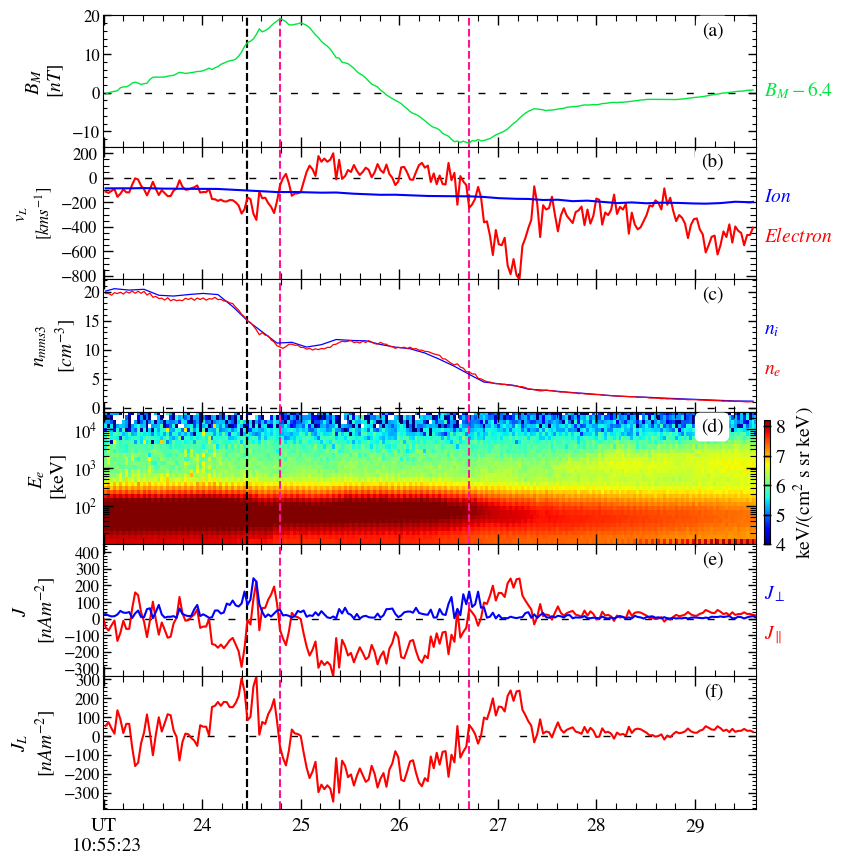

In [94]:
figb,axsb = plt.subplots(6, 1, figsize=[8.27, 8.27], sharex=True, gridspec_kw={'hspace': 0})

plasma_region = ['Sheath','Sphere']

# Custom formatting function
for ax in axsb:
    ax.set_xlim(lmn_b.time.sel(time=t1, method="nearest"), lmn_b.time.sel(time=t2,method='nearest'))
    # Get major/minor ticks and labels just ONCE
    major_ticks, minor_ticks, major_labels = xticks(t1, t2)
    major_labels[0] = (major_labels[0])
    # Set tick parameters
    # X-axis: major ticks
    ax.tick_params(axis='x', which='major',
               labelsize=12, length=7, width=1,
               direction='in', top=True, bottom=True, pad=6)

    # X-axis: minor ticks
    ax.tick_params(axis='x', which='minor',
               labelsize=10, length=4, width=0.8,
               direction='in', top=True, bottom=True, pad=5)

    # Y-axis: major ticks
    ax.tick_params(axis='y', which='major',
               labelsize=12, length=7, width=1,
               direction='in', left=True, right=True, pad=4)

    # Y-axis: minor ticks
    ax.tick_params(axis='y', which='minor',
               labelsize=10, length=4, width=0.8,
               direction='in', left=True, right=True, pad=3)
    # Apply major and minor x-ticks
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)

    # Set major tick labels with "UT\nHH:MM:SS" on the first tick
    ax.set_xticklabels(major_labels, rotation=0, fontsize=14)
    
    ax.axhline(y=0, c='k', ls=(0, (5, 10)), lw=1)
    ax.axvline(x=Bl,ls='--',c='k')
    ax.axvline(x=th_max,ls='--',c='#FF1493')
    ax.axvline(x=th_min,ls='--',c='#FF1493')

    ax.grid(False)
    ax.set_xlim(lmn_b.time.sel(time=t1, method="pad"), lmn_b.time.sel(time=t2,method='bfill'))
    ax.axvline(x=Bl,ls='--',c='k')
    
#axsb[0].plot(lmn_b.time.sel(time=slice(t1,t2)),lmn_b.sel(LMN=0,time=slice(t1,t2)),c='r',lw=1, label='B_M')
axsb[0].plot(lmn_b.time.sel(time=slice(t1,t2)),lmn_b.sel(LMN=1,time=slice(t1,t2))-df['B_g'].values,c=(0/255, 230/255, 64/255),lw=1, label='B_M')
#axsb[0].plot(lmn_b.time.sel(time=slice(t1,t2)),lmn_b.sel(LMN=2,time=slice(t1,t2)),c='b',lw=1, label='B_N')
axsb[0].set_yticks(np.arange(np.round(np.min(lmn_b.sel(LMN=1)),-B)-10**B, np.round(np.max(lmn_b[:,1]),-B)+10**B, 10*B))
axsb[0].set_yticks(np.arange(np.round(np.min(lmn_b.sel(LMN=1)),-B)-10**B, np.round(np.max(lmn_b[:,1]),-B)+10**B, 2*B), minor=True)

axsb[0].tick_params(axis='y', which='major', labelsize=12,size=6,pad=2,direction='in',left=True,right=True)
axsb[0].tick_params(axis='y', which='minor', labelsize=10,size=3,pad=1,direction='in',left=True,right=True)
axsb[0].set_ylim(np.min(B_hm.sel(LMN=1,time=slice(t1,t2))-1),np.max(B_hm.sel(LMN=1,time=slice(t1,t2)))+1)

#axsb[0].annotate(r'$\mathit{B_L}$', xy=(1.01, 0.6), xycoords='axes fraction', style='italic',
#           fontsize=14, color='r', xytext=(1, -1), textcoords='offset points')  # Annotation for Bz in red
axsb[0].annotate(r'$\mathit{B_M-6.4}$', xy=(1.01, 0.4), xycoords='axes fraction', style='italic',fontsize=14, color=(0/255, 230/255, 64/255), xytext=(1, -1), textcoords='offset points')  # Annotation for Bz in red
#axsb[0].annotate(r'$\mathit{B_N}$', xy=(1.01, 0.2), xycoords='axes fraction', style='italic',fontsize=14, color='b', xytext=(1, -1), textcoords='offset points')
#axsb[0].axhline(y=df['B_g'].values, c=(0/255, 230/255, 64/255), linestyle='--', linewidth=1)
axsb[0].set_ylabel(r'$\mathbf{\mathit{B_{M}}}$' + '\n' + r'$\mathit{[nT]}$', fontsize=14)

axsb[2].plot(mms3i_idataset.time.sel(time=slice(t1,t2)), 
            mms3i_idataset.mms3_dis_numberdensity_brst.sel(time=slice(t1,t2)), c='b', lw=0.9)
axsb[2].plot(mms3i_edataset.time.sel(time=slice(t1,t2)), 
            mms3i_edataset.mms3_des_numberdensity_brst.sel(time=slice(t1,t2)), c='r', lw=0.9)
axsb[2].set_ylabel(r'$\mathbf{\mathit{n_{mms3}}}$' + '\n' + r'$\mathit{[cm^{-3}]}$', fontsize=14)

axsb[2].annotate(r'$\mathit{n_i}$', xy=(1.01, 0.6), xycoords='axes fraction', style='italic',
                fontsize=14, color='blue', xytext=(1, -1), textcoords='offset points')  # Annotation for Bx in blue
axsb[2].annotate(r'$\mathit{n_e}$', xy=(1.01, 0.3), xycoords='axes fraction', style='italic',
                fontsize=14, color='red', xytext=(1, -1), textcoords='offset points')  # Annotation for By in green
axsb[2].set_yticks(np.arange(np.round(np.min(mms3i_idataset.mms3_dis_numberdensity_brst.sel(time=slice(t1,t2))), -N), 
                            np.round(np.max(mms3i_idataset.mms3_dis_numberdensity_brst.sel(time=slice(t1,t2))), -N)+5, N*5))
axsb[2].set_yticks(np.arange(np.round(np.min(mms3i_idataset.mms3_dis_numberdensity_brst.sel(time=slice(t1,t2))), -N), 
                            np.round(np.max(mms3i_idataset.mms3_dis_numberdensity_brst.sel(time=slice(t1,t2))),-N)+5, N*1), minor=True)
axsb[2].tick_params(axis='y', which='major', labelsize=12,size=6,pad=2,direction='in',left=True,right=True)
axsb[2].tick_params(axis='y', which='minor', labelsize=10,size=3,pad=1,direction='in',left=True,right=True)
axsb[2].set_ylim(np.min(mms3i_edataset.mms3_des_numberdensity_brst.sel(time=slice(del3,del4))-1),
                np.max(mms3i_edataset.mms3_des_numberdensity_brst.sel(time=slice(del3,del4)))+2)

# Plot using pcolormesh with LogNorm
specgram = axsb[3].pcolormesh(mms3i_edataset.mms3_des_energyspectr_omni_brst.time.sel(time=slice(del3,del4)),
                         mms3i_edataset.mms3_des_energyspectr_omni_brst.spec_bins.sel(time=slice(del3,del4)).mean(dim='time'),
                         mms3i_edataset.mms3_des_energyspectr_omni_brst.sel(time=slice(del3,del4)).T, cmap='jet',
                         norm=mcolors.LogNorm(vmin=1e4, vmax=1e8 * 10 ** 0.8), rasterized=True, shading="auto")
axsb[3].set_ylabel("$E_{e}$ \n [keV]",fontsize=14)
axsb[3].set_yscale('log')

# Create a new axis for the colorbar
cbar_ax = axsb[3].figure.add_axes([0.91, 0.34, 0.007, 0.15])  # Position for the colorbar
# 92% of the width of the figure from the left edge.
#10% of the height of the figure from the bottom edge.
#2% of the width of the figure.
#80% of the height of the figure
# Add colorbar
# Add colorbar
specgram.norm = mcolors.LogNorm(vmin=1e4, vmax=10 ** 8.2) 
cbar = plt.colorbar(specgram, cax=cbar_ax)

cbar.set_label("keV/(cm$^2$ s sr keV)", fontsize=14)

# Set ticks
ticks = np.arange(4, 9)
cbar.set_ticks(10 ** ticks)
cbar.ax.set_yticklabels([f'${{{tick}}}$' for tick in ticks], fontsize=14)

# Show tick marks on both sides (left and right of vertical colorbar)
cbar.ax.tick_params(axis='y', direction='in', length=5, width=1, left=True, right=True)
axsb[1].plot(lmn_ve.time.sel(time=slice(t1,t2)),lmn_vee.sel(LMN=0,time=slice(t1,t2)),c='r')
axsb[1].set_ylabel(r'$\mathbf{\mathit{v_L}}$' + '\n' + r'$\mathit{[kms^{-1}]}$', fontsize=12)
axsb[1].plot(lmn_vi.time.sel(time=slice(t1,t2)),lmn_vi.sel(LMN=0,time=slice(t1,t2)),c='b')
axsb[1].annotate(r'$Ion$', xy=(1.01, 0.6), xycoords='axes fraction', style='italic',
               fontsize=14, color='blue', xytext=(1, -1), textcoords='offset points')  # Annotation for Bx in blue
axsb[1].annotate(r'$Electron$', xy=(1.01, 0.3), xycoords='axes fraction', style='italic',
                fontsize=14, color='red', xytext=(1, -1), textcoords='offset points')  # Annotation for By in green
axsb[4].plot(par_ln_j.time,par_ln_j,c='r')
axsb[4].plot(par_ln_j.time,per_ln_j,c='b')
axsb[4].set_ylabel(r'$\mathbf{\mathit{J}}$' + '\n' + r'$\mathit{[nA m^{-2}]}$', fontsize=14)
axsb[4].set_yticks(np.arange(np.round(np.min(par_ln_j), -2), np.round(np.max(par_ln_j), -2) + 200, 100))
axsb[4].set_yticks(np.arange(np.round(np.min(par_ln_j), -2), np.round(np.max(par_ln_j), -2) + 200, 20), minor=True)
axsb[4].tick_params(axis='y', which='major', labelsize=12,size=6,pad=2,direction='in',left=True,right=True)
axsb[4].tick_params(axis='y', which='minor', labelsize=10,size=3,pad=1,direction='in',left=True,right=True)
axsb[4].set_ylim(np.round(np.min(par_ln_j), -2)-50,np.round(np.max(par_ln_j), -2)+50)

axsb[5].plot(lmn_j.time.sel(time=slice(t1,t2)),lmn_j.sel(LMN=0,time=slice(t1,t2)),c='r')
axsb[5].set_ylabel(r'$\mathbf{\mathit{J_L}}$' + '\n' + r'$\mathit{[nA m^{-2}]}$', fontsize=14)
axsb[5].set_yticks(np.arange(np.round(np.min(lmn_j), -2), np.round(np.max(lmn_j), -2) + 200, 100))
axsb[5].set_yticks(np.arange(np.round(np.min(lmn_j), -2), np.round(np.max(lmn_j), -2) + 200, 20), minor=True)
axsb[5].tick_params(axis='y', which='major', labelsize=12,size=6,pad=2,direction='in',left=True,right=True)
axsb[5].tick_params(axis='y', which='minor', labelsize=10,size=3,pad=1,direction='in',left=True,right=True)
axsb[5].set_ylim(np.min(lmn_j.sel(LMN=0)),np.max(lmn_j.sel(LMN=0)))

axsb[4].annotate(r'$J_{\perp}$', xy=(1.01, 0.6), xycoords='axes fraction', style='italic',
                fontsize=14, color='b', xytext=(1, -1), textcoords='offset points')  # Annotation for Bx in blue
axsb[4].annotate(r'$J_{\parallel}$', xy=(1.01, 0.3), xycoords='axes fraction', style='italic',
                fontsize=14, color='r', xytext=(1, -1), textcoords='offset points')  # Annotation for By in green
axsb[4].tick_params(axis='y', which='major', labelsize=12,size=6,pad=2,direction='in',left=True,right=True)
axsb[4].tick_params(axis='y', which='minor', labelsize=10,size=3,pad=1,direction='in',left=True,right=True)

axsb[1].set_yticks(np.arange(np.round(np.min(lmn_ve), -2), np.round(np.max(lmn_ve), -2) , 200))
axsb[1].set_yticks(np.arange(np.round(np.min(lmn_ve,), -2), np.round(np.max(lmn_ve), -2), 50), minor=True)
axsb[1].set_ylim(np.min(lmn_ve.sel(LMN=0,time=slice(t1,t2))),np.max(lmn_ve.sel(LMN=0,time=slice(t1,t2))+50))

for i, label in enumerate(['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']):
    axsb[i].text(0.95, 0.95, label, transform=axsb[i].transAxes,
                 fontsize=14, va='top', ha='right',
                 bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))
plt.tight_layout(pad=1)  # Adjust padding
plt.subplots_adjust(top=0.98, bottom=0.02, left=0.11, right=0.9, hspace=0.1)
plt.savefig(os.path.join(output_folder, f"{taistarttime}_h.png"), dpi=1200, format='png', bbox_inches='tight')
plt.show()

In [134]:
t1,t2,del3,del4

(np.datetime64('2015-10-16T10:55:23.400'),
 np.datetime64('2015-10-16T10:55:30.000'),
 '2015-10-16T10:55:19',
 '2015-10-16T10:55:34')

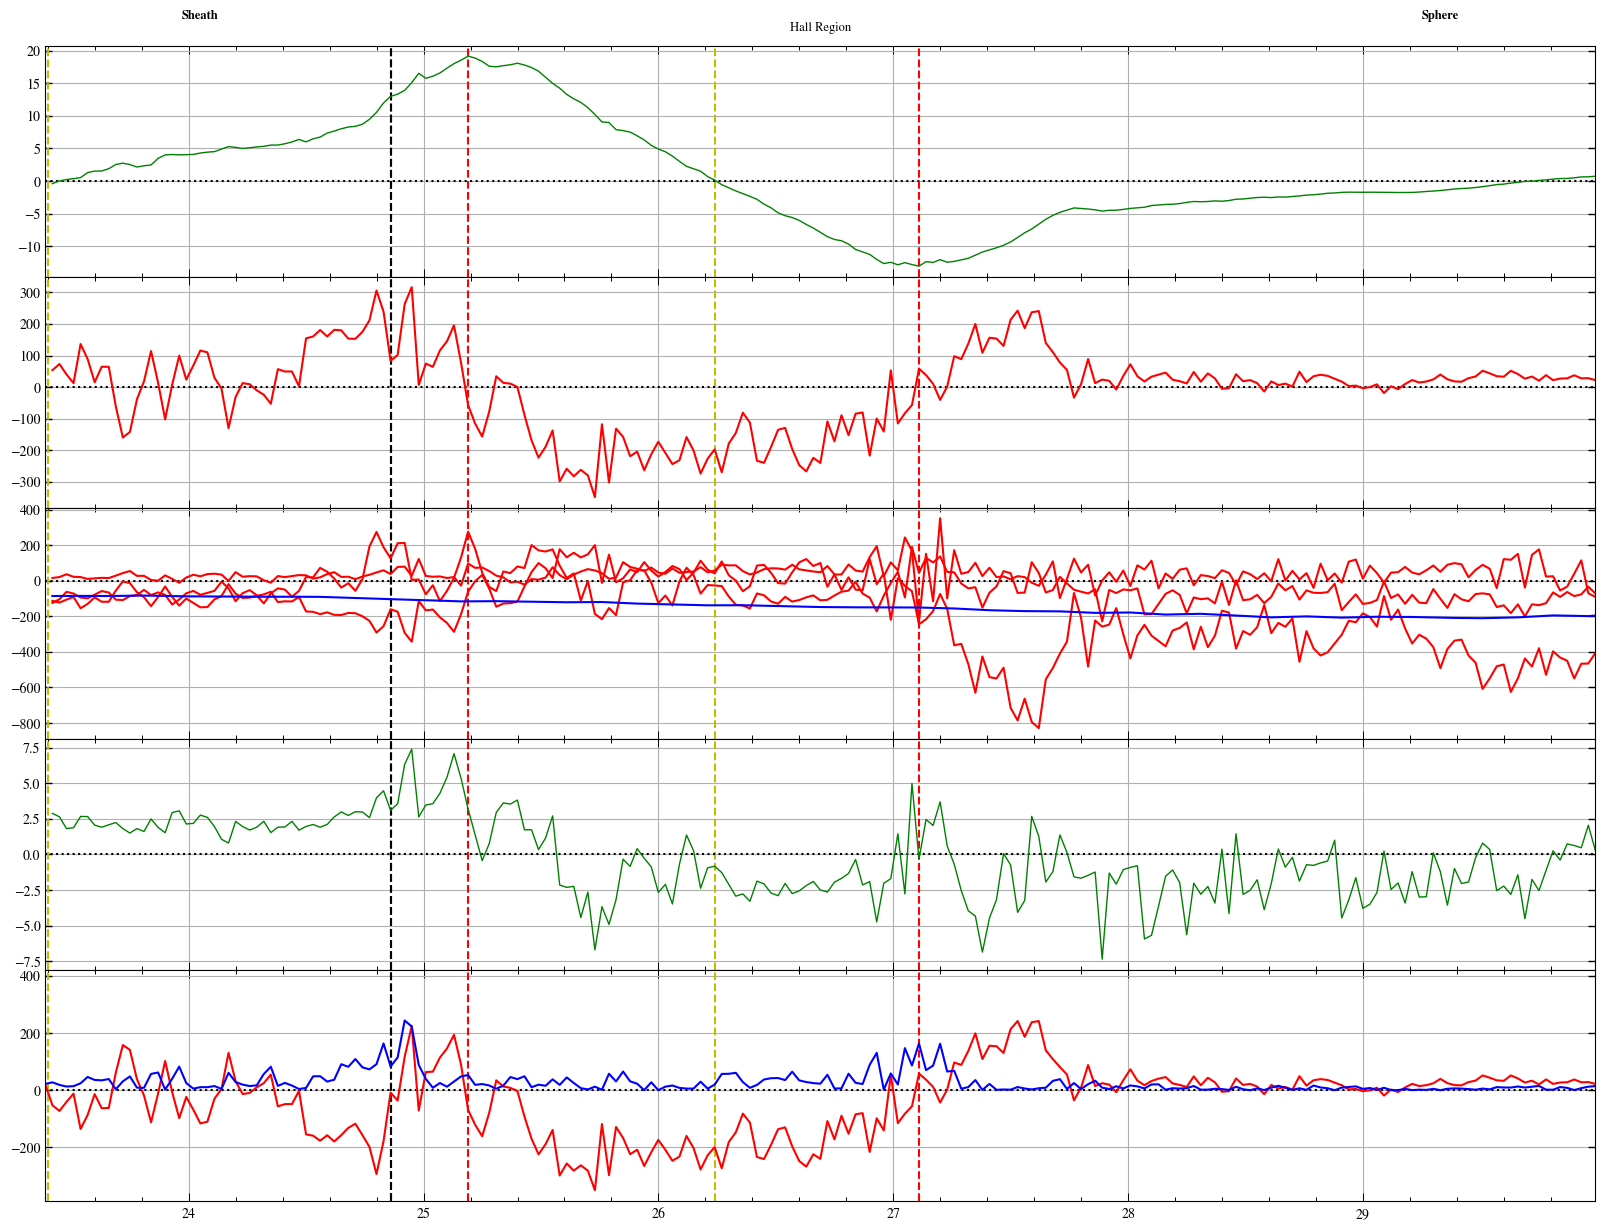

In [96]:
figb,axsb = plt.subplots(5, 1, figsize=[20, 15], sharex=True, gridspec_kw={'hspace': 0})

plasma_region = ['Sheath','Sphere']

if lmn_b.sel(LMN=0,time=slice(del3,del4)).values[0]>0:
    plasma_region = ['Sphere','Sheath']
# Custom formatting function
for ax in axsb:
    ax.tick_params(axis='x', which='major', labelsize=9,size=6,width=0.7,pad=5,direction='in',top=True,bottom=True)
    ax.tick_params(axis='x', which='minor', labelsize=9,size=3,width=0.7,pad=1,direction='in',top=True,bottom=True)
    ax.tick_params(axis='y', which='major', direction='in',left=True,right=True,
                 width=1, length=5,labelsize=10)  # Adjust width and length as needed
    ax.tick_params(axis='y', which='minor', direction='in',left=True,right=True, 
                   width=1, length=3,labelsize=10)
   
    # Set major x-axis ticks
    ax.set_xticks(xticks(del3,del4)[0])

    # Set minor x-axis ticks
    ax.set_xticks(xticks(del3,del4)[1], minor=True)

   # Format x-axis tick labels using the custom function
    ax.set_xticklabels(xticks(del3,del4)[2], rotation=0, fontsize=10)
    ax.axvline(x=t1,ls='--',c='y')
    ax.axvline(x=th_0,ls='--',c='y')
    
    ax.axhline(y=0,ls=':',c='k')
    ax.axvline(x=Bl,ls='--',c='k')
    ax.axvline(x=th_max,ls='--',c='r')
    ax.axvline(x=th_min,ls='--',c='r')
    
    ax.axvline(x=t2,ls='--',c='y')
    ax.grid(True)
    ax.set_xlim(lmn_b.time.sel(time=t1, method="nearest"), lmn_b.time.sel(time=t2,method='nearest'))
    ax.axvline(x=Bl,ls='--',c='k')
    
axsb[0].annotate(f'{plasma_region[0]}', xy=(0.1, 1.1), xycoords='axes fraction',
                 xytext=(0, 5), textcoords='offset points',
                 ha='center', va='center', fontsize=9,fontweight='bold', color='black')
axsb[0].annotate('Hall Region', xy=(0.5, 1.05), xycoords='axes fraction',
                 xytext=(0, 5), textcoords='offset points',
                 ha='center', va='center', fontsize=9, color='black')
axsb[0].annotate(f'{plasma_region[1]}', xy=(0.9, 1.1), xycoords='axes fraction',
                 xytext=(0, 5), textcoords='offset points',
                 ha='center', va='center', fontsize=9, fontweight='bold',color='black')   
axsb[0].plot(lmn_b.time.sel(time=slice(t1,t2)),lmn_b.sel(LMN=1,time=slice(t1,t2))-df['B_g'].values,c='g',lw=1, label='B_M^*')
axsb[1].plot(lmn_j.time.sel(time=slice(t1,t2)),lmn_j.sel(LMN=0,time=slice(t1,t2)),c='r')
axsb[2].plot(lmn_ve.time.sel(time=slice(t1,t2)),lmn_vee.sel(time=slice(t1,t2)),c='r')
axsb[2].plot(lmn_vi.time.sel(time=slice(t1,t2)),lmn_vi.sel(LMN=0,time=slice(t1,t2)),c='b')
axsb[3].plot(lmn_e.time.sel(time=slice(t1,t2)),veb.sel(LMN=2,time=slice(t1,t2)), c='g', lw=1, label='E_N')
axsb[4].plot(par_ln_j.time,par_ln_j,c='r')
axsb[4].plot(par_ln_j.time,per_ln_j,c='b')
plt.show()

In [97]:
t1,t2,del3,del4

(np.datetime64('2015-10-16T10:55:23.400'),
 np.datetime64('2015-10-16T10:55:30.000'),
 '2015-10-16T10:55:19',
 '2015-10-16T10:55:34')

In [98]:
# Physical constants
m_p = 1.6726219e-27  # Proton mass in kg
mu_0 = 4 * np.pi * 1e-7  # Vacuum permeability in T·m/A
e = 1.60217662e-19  # Elementary charge in C
n = df['$N_{SH}$'].values*1e6  # Example number density in m^-3

# Calculate lambda_i
lambda_i = np.sqrt(m_p / (mu_0 * e**2 * n))*1e-3

# Print the result
print('The ion inertial length of plasma in sheath is:', lambda_i)

The ion inertial length of plasma in sheath is: [36.65609338]


In [99]:
v_l_max = lmn_vi.sel(LMN=0).max().values# V_L peak_max
v_l_min = lmn_vi.sel(LMN=0).min().values # V_L peak_min
va_ratio1 = np.abs(v_l_max)/df['$alf_sh$'].values
va_ratio2 = np.abs(v_l_min)/df['$alf_sh$'].values

if np.abs(v_l_max) > np.abs(v_l_min):
    print('MMS crossed the northern branch of reconnection region. \n' 
          'B_L reversal is associated with Northern Ion outflow in +L direction')
else:
    print('MMS crossed the southern branch of reconnection region. \n'
          'B_L reversal is associated with Southern Ion outflow in -L direction')

[v_l_max,  
 v_l_min,  
 va_ratio1,
 va_ratio2]

MMS crossed the southern branch of reconnection region. 
B_L reversal is associated with Southern Ion outflow in -L direction


[array(-38.19997404),
 array(-210.82646963),
 array([0.37472998]),
 array([2.06814273])]

In [100]:
crossing_time = np.array((t2-t1),dtype='float')*1e-3
width= crossing_time*V 
delta = width/lambda_i  # in terms of ion inertial length
aspect_ratio = 10
#aspect_ratio = width/thickness = width/(2*Delta)
thickness = (aspect_ratio*width)/(2)
Delta = thickness/lambda_i  # in terms of ion inertial length
[width,delta],[thickness,Delta]

([np.float64(366.9563024797991), array([10.01078589])],
 [np.float64(1834.7815123989953), array([50.05392947])])

In [101]:
a = np.array([Bl-t1,t2-Bl],dtype='float')*1e-9
a

array([1.459474, 5.140526])

In [102]:
V*a[1]/lambda_i,V*a[0]/lambda_i,V*a[0],V*a[1],V*a[0]+V*a[1]

(array([7.79707654]),
 array([2.21370935]),
 np.float64(81.14593675839428),
 np.float64(285.8103657214048),
 np.float64(366.9563024797991))

In [103]:
a[1]/(a[0]+a[1])

np.float64(0.7788675757575757)

In [104]:
a[0],a[1]

(np.float64(1.4594740000000002), np.float64(5.140526))

In [105]:
a[1]/a[0]

np.float64(3.522177167938586)

In [106]:
e_magnitude = np.linalg.norm(lmn_vee.sel(time=slice(t1,t2)), axis=1)
vi_x_b_magnitude = np.linalg.norm(vib.sel(time=slice(t1,t2)), axis=1)
ve_x_b_magnitude = np.linalg.norm(veb.sel(time=slice(t1,t2)), axis=1)

# Calculate correlation coefficients for the magnitudes
correlation_e_vi = np.corrcoef(e_magnitude, vi_x_b_magnitude)[0, 1]
correlation_e_ve = np.corrcoef(e_magnitude, ve_x_b_magnitude)[0, 1]


print(f"Correlation coefficient between |E| and |-(Vi × B)|: {correlation_e_vi}")
print(f"Correlation coefficient between |E| and |-(Ve × B)|: {correlation_e_ve}")

# Hall electric field
EN_max = lmn_e.sel(LMN=2,time=slice(t1,t2)).max(dim='time').values
EN_min = lmn_e.sel(LMN=2,time=slice(t1,t2)).min(dim='time').values
print(EN_max,EN_min)

Correlation coefficient between |E| and |-(Vi × B)|: 0.6348315435984675
Correlation coefficient between |E| and |-(Ve × B)|: 0.34066395103436153
9.547754330559465 -11.19585451151784


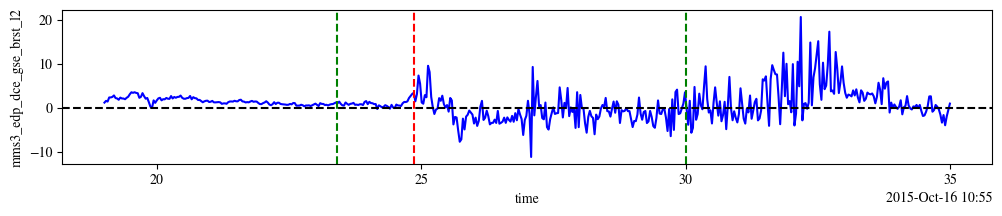

In [107]:
xr.apply_ufunc(convolve, lmn_e.sel(LMN=2,time=slice(del3,del4)), kwargs={'window_size': 1}).plot(figsize=(12, 2), color='b')
plt.axhline(y=0, ls='--',c='k')
plt.axvline(x=Bl, ls='--',c='r')
plt.axvline(x=t1, ls='--',c='g')
plt.axvline(x=t2, ls='--',c='g')

In [108]:
lmn_e.sel(LMN=2,time=slice(del3,t1)).mean().values,lmn_e.sel(LMN=2,time=slice(t2,del4)).mean().values

(array(1.51837522), array(2.2383503))

Upstreatm conditions

In [109]:
n_sh = mms3i_idataset.mms3_dis_numberdensity_brst.sel(time=slice(del3,t1)).mean(dim='time').values
t_sh = mms3i_idataset.mms3_dis_temppara_brst.sel(time=slice(del3,t1)).mean(dim='time').values
B_sh =   B_magnitude.sel(time=slice(del3,t1)).mean(dim='time').values# Magnetic field in nT 20.93 (sp)39.51(sh)


In [110]:
t_sp = mms3i_idataset.mms3_dis_temppara_brst.sel(time=slice(t2,del4)).mean(dim='time').values
n_sp = mms3i_idataset.mms3_dis_numberdensity_brst.sel(time=slice(t2,del4)).mean(dim='time').values
B_sp =   B_magnitude.sel(time=slice(t2,del4)).mean(dim='time').values# Magnetic field in nT 20.93 (sp)39.51(sh)


In [111]:
t_sh,t_sp,t_sp/t_sh

(array(240.53771793), array(2524.99923126), np.float64(10.497310995505106))

In [112]:
n_sh,n_sp,n_sh/n_sp,B_sp/B_sh

(array(19.73641637),
 array(0.60174925),
 np.float64(32.798406401696425),
 np.float64(1.8262343815856665))

Calculation of Plasma beta $\beta$: ratio of thermal and magnetic pressure

In [113]:
k_B = 1.38e-23  # Boltzmann constant (J/K)
eV_to_K = 11605  # Conversion factor from eV to Kelvin
mu_0 = 4 * np.pi * 1e-7  # Permeability of free space (N/A^2)
nT_to_T = 1e-9  # Conversion factor from nT to T
cm3_to_m3 = 1e6  # Conversion factor from cm^-3 to m^-3

def calculate_plasma_beta(B_nT, T_eV, n_cm3):
    # Convert inputs to SI units
    B_T = B_nT * nT_to_T  # Magnetic field in Tesla
    T_K = T_eV * eV_to_K  # Temperature in Kelvin
    n_m3 = n_cm3 * cm3_to_m3  # Number density in m^-3
    
    # Plasma pressure (P_plasma = n k_B T)
    P_plasma = n_m3 * k_B * T_K  # in Pascals (Pa)

    # Magnetic pressure (P_magnetic = B^2 / (2 * mu_0))
    P_magnetic = B_T**2 / (2 * mu_0)  # in Pascals (Pa)

    # Plasma beta
    beta = P_plasma / P_magnetic
    return beta

# Calculate plasma beta
beta_sheath = calculate_plasma_beta(B_sh, t_sh, n_sh)
beta_sheath

np.float64(4.308245021965498)

In [114]:
# Example inputs

#B_nT =   df['$B_SP$']
T_eV = t_sp # Temperature in eV 18.8(sh) 3.29(sh)
n_cm3 = n_sp  # Density in cm^-3

# Calculate plasma beta
beta_sphere = calculate_plasma_beta(B_sp, t_sp, n_sp)
beta_sphere

np.float64(0.4134401850589295)

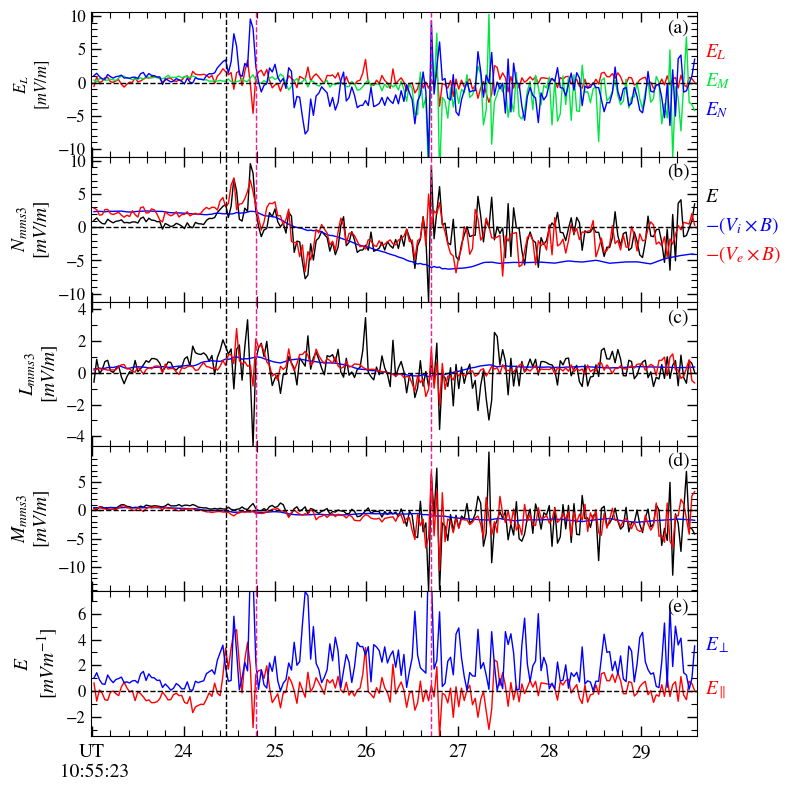

In [115]:
figb,axsb = plt.subplots(5, 1, figsize=[8.27, 8.27], sharex=True, gridspec_kw={'hspace': 0})

axsb[0].plot(lmn_e.time.sel(time=slice(t1,t2)),lmn_e.sel(LMN=0,time=slice(t1,t2)), c='r', lw=1, label='E_L')
axsb[0].plot(lmn_e.time.sel(time=slice(t1,t2)),lmn_e.sel(LMN=1,time=slice(t1,t2)), c=(0/255, 230/255, 64/255), lw=1, label='E_M')
axsb[0].plot(lmn_e.time.sel(time=slice(t1,t2)),lmn_e.sel(LMN=2,time=slice(t1,t2)), c='b', lw=1, label='E_N')
axsb[0].set_ylabel(r'$\mathbf{\mathit{E_L}}$' + '\n' + r'$\mathit{[mV/m]}$', fontsize=12)

axsb[0].set_yticks(np.arange(np.round(np.min(lmn_e.sel(LMN=2)),-E), np.round(np.max(lmn_e[:,2]),-E), 5*E))
axsb[0].set_yticks(np.arange(np.round(np.min(lmn_e.sel(LMN=2)),-E), np.round(np.max(lmn_e[:,2]),-E), 1*E), minor=True)
axsb[0].set_ylim(np.min(lmn_e.sel(LMN=2,time=slice(t1,t2))),np.max(lmn_e.sel(LMN=2,time=slice(t1,t2)))+1)
axsb[0].annotate(r'$\mathit{E}_L$', xy=(1.01, 0.7), xycoords='axes fraction', style='italic',
           fontsize=14, color='r', xytext=(1, -1), textcoords='offset points') 
axsb[0].annotate(r'$\mathit{E}_M$', xy=(1.01, 0.5), xycoords='axes fraction', style='italic',
           fontsize=14, color=(0/255, 230/255, 64/255), xytext=(1, -1), textcoords='offset points') 
axsb[0].annotate(r'$\mathit{E}_N$', xy=(1.01, 0.3), xycoords='axes fraction', style='italic',
           fontsize=14, color='b', xytext=(1, -1), textcoords='offset points') 


axsb[1].plot(lmn_e.time.sel(time=slice(t1,t2)),lmn_e.sel(LMN=2,time=slice(t1,t2)), c='k', lw=1, label='E_N')
axsb[1].plot(lmn_e.time.sel(time=slice(t1,t2)),vib.sel(LMN=2,time=slice(t1,t2)), c='b', lw=1, label='E_N')
axsb[1].plot(lmn_e.time.sel(time=slice(t1,t2)),veb.sel(LMN=2,time=slice(t1,t2)), c='r', lw=1, label='E_N')
axsb[1].annotate(r'$\mathit{E}$', xy=(1.01, 0.7), xycoords='axes fraction', style='italic',
           fontsize=14, color='k', xytext=(1, -1), textcoords='offset points') 
axsb[1].annotate(r'$-(\mathit{V_i\times B})$', xy=(1.01, 0.5), xycoords='axes fraction', style='italic',
           fontsize=14, color='b', xytext=(1, -1), textcoords='offset points') 
axsb[1].annotate(r'$-(\mathit{V_e\times B})$', xy=(1.01, 0.3), xycoords='axes fraction', style='italic',
           fontsize=14, color='r', xytext=(1, -1), textcoords='offset points')  
axsb[1].set_ylabel(r'$\mathbf{\mathit{N_{mms3}}}$' + '\n' + r'$\mathit{[mV/m]}$', fontsize=14)
axsb[1].set_yticks(np.arange(np.round(np.min(lmn_e.sel(LMN=2)),-E), np.round(np.max(lmn_e[:,2]),-E), 5*E))
axsb[1].set_yticks(np.arange(np.round(np.min(lmn_e.sel(LMN=2)),-E), np.round(np.max(lmn_e[:,2]),-E), 1*E), minor=True)
axsb[1].set_ylim(np.min(lmn_e.sel(LMN=2,time=slice(t1,t2))),np.max(lmn_e.sel(LMN=2,time=slice(t1,t2)))+1)

axsb[2].plot(lmn_e.time.sel(time=slice(t1,t2)),lmn_e.sel(LMN=0,time=slice(t1,t2)), c='k', lw=1, label='E_L')
axsb[2].plot(lmn_e.time.sel(time=slice(t1,t2)),vib.sel(LMN=0,time=slice(t1,t2)), c='b', lw=1, label='E_L')
axsb[2].plot(lmn_e.time.sel(time=slice(t1,t2)),veb.sel(LMN=0,time=slice(t1,t2)), c='r', lw=1, label='E_L')

#axsb[2].annotate(r'$\mathit{E}$', xy=(1.01, 0.7), xycoords='axes fraction', style='italic',
#          fontsize=14, color='k', xytext=(1, -1), textcoords='offset points') 
#axsb[2].annotate(r'$-(\mathit{V_i\times B})_L$', xy=(1.01, 0.5), xycoords='axes fraction', style='italic',
#           fontsize=14, color='b', xytext=(1, -1), textcoords='offset points') 
#axsb[2].annotate(r'$-(\mathit{V_e\times B})_L$', xy=(1.01, 0.3), xycoords='axes fraction', style='italic',
 #          fontsize=14, color='r', xytext=(1, -1), textcoords='offset points')  
axsb[2].set_ylabel(r'$\mathbf{\mathit{L_{mms3}}}$' + '\n' + r'$\mathit{[mV/m]}$', fontsize=14)
axsb[2].set_yticks(np.arange(np.round(np.min(lmn_e.sel(LMN=0)),-E)-4*E, np.round(np.max(lmn_e[:,0]),-E), 2*E))
axsb[2].set_yticks(np.arange(np.round(np.min(lmn_e.sel(LMN=0)),-E)-4*E, np.round(np.max(lmn_e[:,0]),-E), 1*E), minor=True)
axsb[2].set_ylim(np.min(lmn_e.sel(LMN=0,time=slice(t1,t2))),np.max(lmn_e.sel(LMN=0,time=slice(t1,t2)))+1)

axsb[3].plot(lmn_e.time.sel(time=slice(t1,t2)),lmn_e.sel(LMN=1,time=slice(t1,t2)), c='k', lw=1, label='E_M')
axsb[3].plot(lmn_e.time.sel(time=slice(t1,t2)),vib.sel(LMN=1,time=slice(t1,t2)), c='b', lw=1, label='E_M')
axsb[3].plot(lmn_e.time.sel(time=slice(t1,t2)),veb.sel(LMN=1,time=slice(t1,t2)), c='r', lw=1, label='E_M')
#axsb[3].annotate(r'$\mathit{E}$', xy=(1.01, 0.7), xycoords='axes fraction', style='italic',
#           fontsize=14, color='k', xytext=(1, -1), textcoords='offset points') 
#axsb[3].annotate(r'$-(\mathit{V_i\times B})_M$', xy=(1.01, 0.5), xycoords='axes fraction', style='italic',
#           fontsize=14, color='b', xytext=(1, -1), textcoords='offset points') 
#axsb[3].annotate(r'$-(\mathit{V_e\times B})_M$', xy=(1.01, 0.3), xycoords='axes fraction', style='italic',
#           fontsize=14, color='r', xytext=(1, -1), textcoords='offset points') 
axsb[3].set_ylabel(r'$\mathbf{\mathit{M_{mms3}}}$' + '\n' + r'$\mathit{[mV/m]}$', fontsize=14)
axsb[3].set_yticks(np.arange(np.round(np.min(lmn_e.sel(LMN=1)),-E), np.round(np.max(lmn_e[:,1]),-E), 5*E))
axsb[3].set_yticks(np.arange(np.round(np.min(lmn_e.sel(LMN=1)),-E), np.round(np.max(lmn_e[:,1]),-E), 1*E), minor=True)
axsb[3].set_ylim(np.min(lmn_e.sel(LMN=1,time=slice(t1,t2))),np.max(lmn_e.sel(LMN=1,time=slice(t1,t2)))+1)

axsb[4].plot(par_ln_e.time.sel(time=slice(t1,t2)),par_ln_e.sel(time=slice(t1,t2)),lw=1,c='r')
axsb[4].plot(par_ln_e.time.sel(time=slice(t1,t2)),per_ln_e.sel(time=slice(t1,t2)),lw=1,c='b')

axsb[4].tick_params(axis='y', which='major', labelsize=12,size=6,pad=2,direction='in',left=True,right=True)
axsb[4].tick_params(axis='y', which='minor', labelsize=10,size=3,pad=1,direction='in',left=True,right=True)
axsb[4].annotate(r'$E_{\perp}$', xy=(1.01, 0.6), xycoords='axes fraction', style='italic',
                fontsize=14, color='blue', xytext=(1, -1), textcoords='offset points')  # Annotation for Bx in blue
axsb[4].annotate(r'$E_{\parallel}$', xy=(1.01, 0.3), xycoords='axes fraction', style='italic',
                fontsize=14, color='red', xytext=(1, -1), textcoords='offset points')  # Annotation for By in green
axsb[4].set_ylabel(r'$\mathbf{\mathit{E}}$' + '\n' + r'$\mathit{[mV m^{-1}]}$', fontsize=14) 
axsb[4].set_yticks(np.arange(np.round(np.min(par_ln_e),-E)-4*E, np.round(np.max(par_ln_e),-E), 2*E))
axsb[4].set_yticks(np.arange(np.round(np.min(par_ln_e),-E)-4*E, np.round(np.max(par_ln_e),-E), 1*E), minor=True)
axsb[4].set_ylim(np.min(par_ln_e.sel(time=slice(t1,t2))),np.max(par_ln_e.sel(time=slice(t1,t2)))+3)
# Custom formatting function
for ax in axsb:
    ax.set_xlim(lmn_b.time.sel(time=t1, method="nearest"), lmn_b.time.sel(time=t2,method='nearest'))
    # Get major/minor ticks and labels just ONCE
    major_ticks, minor_ticks, major_labels = xticks(t1, t2)
    major_labels[0] = (major_labels[0])
    # Set tick parameters
    # X-axis: major ticks
    ax.tick_params(axis='x', which='major',
               labelsize=12, length=7, width=1,
               direction='in', top=True, bottom=True, pad=6)

    # X-axis: minor ticks
    ax.tick_params(axis='x', which='minor',
               labelsize=10, length=4, width=0.8,
               direction='in', top=True, bottom=True, pad=5)

    # Y-axis: major ticks
    ax.tick_params(axis='y', which='major',
               labelsize=12, length=7, width=1,
               direction='in', left=True, right=True, pad=4)

    # Y-axis: minor ticks
    ax.tick_params(axis='y', which='minor',
               labelsize=10, length=4, width=0.8,
               direction='in', left=True, right=True, pad=3)
    # Apply major and minor x-ticks
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)

    # Set major tick labels with "UT\nHH:MM:SS" on the first tick
    ax.set_xticklabels(major_labels, rotation=0, fontsize=14)
    ax.axvline(x=Bl,ls='--',lw=1,c='k')
    #ax.axvline(x=t1,ls='--',c='k')
    ax.axhline(y=0,ls='--',lw=1,c='k')
    #ax.axvline(x=t_1,ls='--',c='b')
    #ax.axvline(x=th_2,ls='--',c='k')
    #ax.axvline(x=t_3,ls='--',c='b')
    ax.axvline(x=th_max,ls='--',lw=1,c='#FF1493')
    ax.axvline(x=th_min,ls='--',lw=1,c='#FF1493')
    ax.grid(False)
    ax.set_xlim(lmn_b.time.sel(time=t1, method="pad"), lmn_b.time.sel(time=t2,method='bfill'))

axsb[0].text(0.95,0.95, '(a)', transform=axsb[0].transAxes, fontsize=14, va='top') 
axsb[1].text(0.95,0.95, '(b)', transform=axsb[1].transAxes, fontsize=14, va='top') 
axsb[2].text(0.95,0.95, '(c)', transform=axsb[2].transAxes, fontsize=14, va='top') 
axsb[3].text(0.95,0.95, '(d)', transform=axsb[3].transAxes, fontsize=14, va='top') 
axsb[4].text(0.95,0.95, '(e)', transform=axsb[4].transAxes, fontsize=14, va='top')     
plt.tight_layout(pad=2.0)

plt.savefig(os.path.join(output_folder, f"{taistarttime}_d.png"), dpi=1200, format='png', bbox_inches='tight')
plt.show()